# Sentence Embedding
Riordan Callil 2021
Honours research
Developing an instruction understanding robot
Current design: Instruction understanding using sentence embedding. Sentence embedding network will be trained in two phases. (1) Trained as a sentence autoencoder. Using the translation encoder-decoder framework. I will train the network to reconstruct the initial instruction from the latent representation. (2) I will fine tune the networks latent representations by training a classifier that uses the latent space to predict instruction action. (3) (FUTURE) As an additional step I might train the sentence autoencoder to translate high level instructions to low level instructions and visa versa. 

# Utils

In [1]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)
    plt.show()

# Dataset: ALFRED

In [25]:
import tqdm
import glob
import json
import string
import torchtext
from torchtext.data import get_tokenizer
from nltk.stem import WordNetLemmatizer

# Loading and Transforming the ALFRED dataset utilites

def load_next_alfred_data(ALFRED_JSON_PATTERN):
    """
     Get list of all instructions and their trajectories
     glob.glob gets all files and stores them. iglob makes an iterator.
     
    Paramaters:
        @alfred_json_pattern
        A string which represents the location of the data with glob style
        regex expressions to denote multiple subdirectories.
    """ 
    train_json_files = glob.glob(ALFRED_JSON_PATTERN)
    tokenizer = get_tokenizer("basic_english")
    wnl = WordNetLemmatizer()
    dataset = []
    
    stop_words = ["the", "and", "of", "a", "is", "over"]
    
    def preprocess_sentence(sentence):
        sentence = tokenizer(sentence)
        sentence = filter(lambda x: not x in string.punctuation, sentence)
        sentence = [wnl.lemmatize(word) for word in sentence]
        sentence = list(filter(lambda x: not x in stop_words, sentence))
        return sentence
    
    # Yeild an alfred json
    for json_file_idx in tqdm.tqdm(range(len(train_json_files))):
        data = json.load(open(train_json_files[json_file_idx]))
        annotations = data['turk_annotations']['anns']
        actions = data['plan']['high_pddl']
        scene = data['scene']
        scene['task_id'] = data['task_id']
        
        instruction_actions = []
        for d in annotations:
            votes = d['votes']
            if any(votes): # WARNING: Limiting dataset based on votes
                trajectory = {'task_desc': [], 'instructions': []}
                trajectory['task_desc'] = preprocess_sentence(d['task_desc'])
                for i in range(len(d['high_descs'])):
                    sanitized_instruction = preprocess_sentence(d['high_descs'][i])
                    instruction = {'instruction': sanitized_instruction, 
                                   'action': actions[i]['discrete_action']['action'],
                                   'argument_1': actions[i]['discrete_action']['args'][0] if 0 < len(actions[i]['discrete_action']['args']) else '<unk>', 
                                   'argument_2': actions[i]['discrete_action']['args'][1] if 1 < len(actions[i]['discrete_action']['args']) else '<unk>'}
                    trajectory['instructions'].append(instruction)
                instruction_actions.append(trajectory)

        if len(instruction_actions) > 0:
            dataset.append((instruction_actions, scene))
    return dataset

train_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/train/*/*/*.json")
eval_dataset = load_next_alfred_data("D:/Datasets/alfred/data/ALFRED_json_2.1.0/valid_unseen/*/*/*.json")

100%|███████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 309.47it/s]


In [26]:
import json
import os

class Language:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {}
        self.n_words = 0
    
    def add_sentence(self, sentence):
        for word in sentence:
            self.add_word(word)
    
    def add_word(self, word):
        if word not in self.word2index: # Add word to langauge if unseen 
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word(self, index):
        return self.index2word.get(str(index), f"<unk:{index}>")
    
    def index(self, word):
        return self.word2index.get(word, f"<unk:{word}>")
    
    def dump(self, filename):
        obj = {
            'word2index' : self.word2index,
            'word2count' : self.word2count,
            'index2word' : self.index2word,
            'n_words' : self.n_words
        }
        with open(filename, 'w') as fp:
            json.dump(obj, fp)
    
    def load(self, filename):
        with open(filename, 'r') as fp:
            obj = json.load(fp)
            self.word2index = obj['word2index']
            self.word2count = obj['word2count']
            self.index2word = obj['index2word']
            self.n_words = obj['n_words']
    
    def reset_counts(self):
        self.word2count = dict.fromkeys(self.word2count, 0)

# Check if backup, pickled, langauge object exists
lang = Language()
if os.path.isfile('instruction_language.json'):
    lang.load('instruction_language.json')
    lang.reset_counts()

action_lang = Language()
if os.path.isfile('action_language.json'):
    action_lang.load('action_language.json')
    action_lang.reset_counts()

argument_lang = Language()
if os.path.isfile('argument_language.json'):
    argument_lang.load('argument_language.json')
    argument_lang.reset_counts()

lang.add_sentence(["<SOS>", "<EOS>"])
action_lang.add_sentence(["<SOS>", "<EOS>"])
argument_lang.add_sentence(["<SOS>", "<EOS>"])

def add_dataset_to_language(lang, dataset):
    sentence_lengths = []
    # Add dataset to langauge object
    for task in tqdm.tqdm(dataset): 
        for trajectory in task[0]:
            lang.add_sentence(trajectory['task_desc'])
            sentence_lengths.append(len(trajectory['task_desc']))
            for instruction in trajectory['instructions']:
                instruction_text = instruction['instruction']
                instruction_action = instruction['action']
                instruction_arg_1 = instruction['argument_1']
                instruction_arg_2 = instruction['argument_2']
                if len(instruction_text) > 0:
                    lang.add_sentence(instruction_text)
                action_lang.add_word(instruction_action)
                if instruction_arg_1 != '<unk>':
                    lang.add_word(instruction_arg_1)
                    argument_lang.add_word(instruction_arg_1)
                if instruction_arg_2 != '<unk>':
                    lang.add_word(instruction_arg_2)
                    argument_lang.add_word(instruction_arg_2)
 
            sentence_lengths.append(len(instruction_text))
    return sentence_lengths
                    
sentence_lengths = add_dataset_to_language(lang, train_dataset)
eval_sentence_lengths = add_dataset_to_language(lang, eval_dataset)
sentence_lengths.extend(eval_sentence_lengths)

print('average sentence length = %.2f words' % (sum(sentence_lengths) / len(sentence_lengths)))

# Pickle the language as a backup
lang.dump('instruction_language.json')
action_lang.dump('action_language.json')
argument_lang.dump('argument_language.json')

print('vocab size =', lang.n_words)
print('most common words: ', sorted(lang.word2count.items(), key=lambda item: item[1], reverse=True)[:10])
print('most common actions: ', sorted(action_lang.word2count.items(), key=lambda item: item[1], reverse=True))
print('number of arguments = ', argument_lang.n_words)

print(action_lang.word2index)
print(argument_lang.word2index)

100%|█████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 12143.46it/s]

average sentence length = 6.92 words
vocab size = 2053
most common words:  [('to', 98305), ('turn', 72887), ('on', 56709), ('right', 44577), ('left', 43432), ('in', 38055), ('up', 32122), ('walk', 30867), ('put', 28952), ('table', 28084)]
most common actions:  [('GotoLocation', 70355), ('PickupObject', 31968), ('PutObject', 29426), ('SliceObject', 3152), ('HeatObject', 3079), ('CoolObject', 3059), ('CleanObject', 2955), ('ToggleObject', 2424), ('<SOS>', 1), ('<EOS>', 1)]
number of arguments =  83
{'GotoLocation': 0, 'PickupObject': 1, 'ToggleObject': 2, 'PutObject': 3, 'SliceObject': 4, 'CleanObject': 5, 'CoolObject': 6, 'HeatObject': 7, '<SOS>': 8, '<EOS>': 9}
{'dresser': 0, 'alarmclock': 1, 'desklamp': 2, 'desk': 3, 'shelf': 4, 'sidetable': 5, 'baseballbat': 6, 'basketball': 7, 'book': 8, 'bed': 9, 'bowl': 10, 'sofa': 11, 'box': 12, 'coffeetable': 13, 'diningtable': 14, 'floorlamp': 15, 'candle': 16, 'cd': 17, 'drawer': 18, 'garbagecan': 19, 'cellphone': 20, 'armchair': 21, 'ottoman'

In [31]:
###### Train Cirriculum ######
train_reconstruction = [] # [any text, any text]
train_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
train_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(train_dataset):
    for trajectory in task[0]:
        train_reconstruction.append(trajectory['task_desc'])
        for i, instruction in enumerate(trajectory['instructions']):
            instruction_text = instruction['instruction'].copy()
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                # Append previous instruction arguments
                if i > 0:
                    instruction_text.extend(train_low_action_argument_pairs[-1][2])
                
                train_reconstruction.append(instruction_text)
                train_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                train_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])
        
print('train reconstruction samples =', len(train_reconstruction))
print('train high -> low pairs =', len(train_high_low_pairs))
print('train low -> action / argument pairs =', len(train_low_action_argument_pairs))

###### Eval Cirriculum ######
eval_reconstruction = [] # [any text, any text]
eval_high_low_pairs = [] # [high level instruction, low level instruction] # Swap for variability
eval_low_action_argument_pairs = [] # [low level instructions, action, argument_1 argument_2]

# Add dataset to langauge object
for task in tqdm.tqdm(eval_dataset):
    for trajectory in task[0]:
        eval_reconstruction.append(trajectory['task_desc'])
        for i, instruction in enumerate(trajectory['instructions']):
            instruction_text = instruction['instruction'].copy()
            instruction_action = instruction['action']
            instruction_arg_1 = instruction['argument_1']
            instruction_arg_2 = instruction['argument_2']
            instruction_args = []
            
            if len(instruction_text) > 0:
                # Append previous instruction arguments
                if i > 0:
                    instruction_text.extend(eval_low_action_argument_pairs[-1][2])
                
                eval_reconstruction.append(instruction_text)
                eval_high_low_pairs.append([trajectory['task_desc'], instruction_text])
            
            if instruction_arg_1 != '<unk>':
                if instruction_arg_1 == 'wineglass':
                    print(instruction_text,instruction_arg_1 )
                instruction_args.append(instruction_arg_1)
            if instruction_arg_2 != '<unk>':
                instruction_args.append(instruction_arg_2)
            
            if len(instruction_args) > 0:
                eval_low_action_argument_pairs.append([instruction_text, [instruction_action], instruction_args])

print('eval reconstruction samples =', len(eval_reconstruction))
print('eval high -> low pairs =', len(eval_high_low_pairs))
print('eval low -> action / argument pairs =', len(eval_low_action_argument_pairs))

import torch
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device: {}'.format(device))

# Prepare data for tensor representation
def indices_from_sentence(lang, sentence):
    return [lang.index(word) for word in sentence]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(lang.index('<EOS>'))
    return torch.tensor(indices, dtype=torch.long, device=device).view(-1,1)

def tensors_from_pair(input_lang, output_lang, pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

rpair = random.choice(train_low_action_argument_pairs)
print(rpair)
print(tensors_from_pair(lang, action_lang, [rpair[0], rpair[1]]))
print(train_low_action_argument_pairs[0:5])
print(eval_low_action_argument_pairs[0:5])

100%|█████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 21248.16it/s]

train reconstruction samples = 162303
train high -> low pairs = 141278
train low -> action / argument pairs = 141278
eval reconstruction samples = 5961
eval high -> low pairs = 5140
eval low -> action / argument pairs = 5140
using device: cuda
[['turn', 'left', 'to', 'face', 'dishwasher', 'mug'], ['GotoLocation'], ['coffeemachine']]
(tensor([[   4],
        [   7],
        [  20],
        [   8],
        [ 928],
        [ 455],
        [2046]], device='cuda:0'), tensor([[0],
        [9]], device='cuda:0'))
[[['turn', 'left', 'face', 'dresser'], ['GotoLocation'], ['dresser']], [['pick', 'up', 'alarm', 'clock', 'from', 'dresser', 'dresser'], ['PickupObject'], ['alarmclock']], [['turn', 'left', 'look', 'then', 'face', 'lamp', 'alarmclock'], ['GotoLocation'], ['desklamp']], [['turn', 'lamp', 'on', 'desklamp'], ['ToggleObject'], ['desklamp']], [['move', 'to', 'white', 'dresser', 'to', 'left', 'bed'], ['GotoLocation'], ['dresser']]]
[[['turn', 'to', 'left', 'face', 'desk'], ['GotoLocation'],

# Model

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

MAX_LENGTH = 15

# Sourced from Pytorch Tutorial: Seq2Seq Translation Tutorial
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, _input, hidden, encoder_outputs):
        embedded = self.embedding(_input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Train - Action Decoder

In [105]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[lang.index('<SOS>')]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.01
epochs = 10
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))


start = time.time()
plot_every = 100
plot_losses = []
print_every = 100
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(action_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[1]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(action_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     action_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(action_decoder.state_dict(), 'action_decoder.pt')

show_plot(plot_losses)

updates:  54434
tensor([[-1.3582e+01, -1.4300e+01, -1.7508e-03, -6.4714e+00, -1.4388e+01,
         -8.6142e+00, -1.1047e+01, -1.4340e+01, -1.3927e+01, -1.4053e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


AssertionError: 

# Train - Argument Decoder

EncoderRNN(
  (embedding): Embedding(2053, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(83, 256)
  (attn): Linear(in_features=512, out_features=15, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=83, bias=True)
)
updates:  1293090
0m 11s (- 239m 13s) (1000 0%) 0.0892
0m 21s (- 231m 42s) (2000 0%) 0.0678
0m 31s (- 228m 9s) (3000 0%) 0.0488
0m 42s (- 229m 18s) (4000 0%) 0.0206
0m 53s (- 227m 51s) (5000 0%) 0.0470
1m 3s (- 226m 6s) (6000 0%) 0.0200
1m 13s (- 225m 51s) (7000 0%) 0.0232
1m 24s (- 225m 51s) (8000 0%) 0.0381
1m 35s (- 226m 28s) (9000 0%) 0.0736
1m 46s (- 227m 38s) (10000 0%) 0.0669
1m 57s (- 228m 50s) (11000 0%) 0.0491
2m 9s (- 229m 37s) (12000 0%) 0.0609
2m 20s (- 230m 2s) (13000 1%) 0.0582
2m 31s (- 230m 51s) (14000 1%) 0.0562
2m 42s (- 231m 9s) (15000 1%) 0.0495
2m 54s (- 231m 36s) (16000 1%) 0.0660
3m 5

37m 9s (- 203m 4s) (200000 15%) 0.0712
37m 19s (- 202m 49s) (201000 15%) 0.0934
37m 30s (- 202m 36s) (202000 15%) 0.0432
37m 42s (- 202m 26s) (203000 15%) 0.0396
37m 52s (- 202m 13s) (204000 15%) 0.0760
38m 3s (- 202m 0s) (205000 15%) 0.0280
38m 14s (- 201m 49s) (206000 15%) 0.0693
38m 25s (- 201m 35s) (207000 16%) 0.0932
38m 36s (- 201m 22s) (208000 16%) 0.0572
38m 46s (- 201m 9s) (209000 16%) 0.0772
38m 57s (- 200m 58s) (210000 16%) 0.0618
39m 8s (- 200m 45s) (211000 16%) 0.0380
39m 19s (- 200m 33s) (212000 16%) 0.0794
39m 30s (- 200m 21s) (213000 16%) 0.0651
39m 41s (- 200m 8s) (214000 16%) 0.0740
39m 52s (- 199m 56s) (215000 16%) 0.0732
40m 3s (- 199m 44s) (216000 16%) 0.0720
40m 13s (- 199m 30s) (217000 16%) 0.0648
40m 24s (- 199m 18s) (218000 16%) 0.0758
40m 36s (- 199m 9s) (219000 16%) 0.0545
40m 47s (- 198m 56s) (220000 17%) 0.0433
40m 58s (- 198m 44s) (221000 17%) 0.0675
41m 9s (- 198m 33s) (222000 17%) 0.0391
41m 20s (- 198m 23s) (223000 17%) 0.0525
41m 31s (- 198m 9s) (22400

74m 22s (- 164m 51s) (402000 31%) 0.0496
74m 33s (- 164m 41s) (403000 31%) 0.0509
74m 45s (- 164m 30s) (404000 31%) 0.0562
74m 56s (- 164m 19s) (405000 31%) 0.0750
75m 7s (- 164m 9s) (406000 31%) 0.0465
75m 19s (- 163m 58s) (407000 31%) 0.0560
75m 30s (- 163m 47s) (408000 31%) 0.0677
75m 41s (- 163m 36s) (409000 31%) 0.0821
75m 52s (- 163m 25s) (410000 31%) 0.0884
76m 3s (- 163m 14s) (411000 31%) 0.0622
76m 15s (- 163m 4s) (412000 31%) 0.0877
76m 26s (- 162m 54s) (413000 31%) 0.0234
76m 38s (- 162m 43s) (414000 32%) 0.0204
76m 49s (- 162m 33s) (415000 32%) 0.0471
77m 1s (- 162m 23s) (416000 32%) 0.0513
77m 12s (- 162m 12s) (417000 32%) 0.0531
77m 23s (- 162m 1s) (418000 32%) 0.0445
77m 35s (- 161m 51s) (419000 32%) 0.0788
77m 46s (- 161m 40s) (420000 32%) 0.0728
77m 57s (- 161m 29s) (421000 32%) 0.0660
78m 8s (- 161m 18s) (422000 32%) 0.0532
78m 20s (- 161m 8s) (423000 32%) 0.0362
78m 31s (- 160m 57s) (424000 32%) 0.0540
78m 42s (- 160m 46s) (425000 32%) 0.0640
78m 53s (- 160m 35s) (42

111m 29s (- 127m 35s) (603000 46%) 0.0669
111m 39s (- 127m 23s) (604000 46%) 0.0701
111m 50s (- 127m 11s) (605000 46%) 0.0585
112m 1s (- 127m 1s) (606000 46%) 0.0708
112m 12s (- 126m 49s) (607000 46%) 0.0490
112m 23s (- 126m 38s) (608000 47%) 0.0402
112m 34s (- 126m 27s) (609000 47%) 0.0565
112m 45s (- 126m 16s) (610000 47%) 0.0349
112m 56s (- 126m 5s) (611000 47%) 0.0459
113m 7s (- 125m 54s) (612000 47%) 0.0498
113m 18s (- 125m 42s) (613000 47%) 0.0665
113m 29s (- 125m 31s) (614000 47%) 0.0764
113m 40s (- 125m 19s) (615000 47%) 0.0490
113m 51s (- 125m 8s) (616000 47%) 0.0601
114m 2s (- 124m 57s) (617000 47%) 0.0286
114m 12s (- 124m 46s) (618000 47%) 0.0785
114m 23s (- 124m 34s) (619000 47%) 0.0702
114m 34s (- 124m 23s) (620000 47%) 0.0565
114m 45s (- 124m 12s) (621000 48%) 0.0410
114m 57s (- 124m 1s) (622000 48%) 0.0341
115m 8s (- 123m 50s) (623000 48%) 0.0535
115m 19s (- 123m 39s) (624000 48%) 0.0354
115m 30s (- 123m 28s) (625000 48%) 0.0371
115m 41s (- 123m 17s) (626000 48%) 0.0458


148m 15s (- 91m 5s) (801000 61%) 0.0197
148m 27s (- 90m 54s) (802000 62%) 0.0180
148m 39s (- 90m 43s) (803000 62%) 0.0444
148m 50s (- 90m 32s) (804000 62%) 0.0471
149m 2s (- 90m 22s) (805000 62%) 0.0486
149m 13s (- 90m 11s) (806000 62%) 0.0438
149m 25s (- 90m 0s) (807000 62%) 0.0825
149m 36s (- 89m 49s) (808000 62%) 0.0755
149m 47s (- 89m 38s) (809000 62%) 0.0663
149m 59s (- 89m 27s) (810000 62%) 0.0441
150m 11s (- 89m 16s) (811000 62%) 0.0315
150m 22s (- 89m 5s) (812000 62%) 0.0583
150m 33s (- 88m 54s) (813000 62%) 0.0693
150m 44s (- 88m 43s) (814000 62%) 0.0357
150m 56s (- 88m 32s) (815000 63%) 0.0632
151m 8s (- 88m 22s) (816000 63%) 0.0463
151m 20s (- 88m 11s) (817000 63%) 0.0674
151m 31s (- 88m 0s) (818000 63%) 0.0626
151m 43s (- 87m 49s) (819000 63%) 0.0403
151m 55s (- 87m 39s) (820000 63%) 0.0432
152m 7s (- 87m 28s) (821000 63%) 0.0682
152m 19s (- 87m 17s) (822000 63%) 0.0436
152m 30s (- 87m 6s) (823000 63%) 0.0360
152m 42s (- 86m 55s) (824000 63%) 0.0363
152m 53s (- 86m 45s) (82

187m 26s (- 54m 12s) (1003000 77%) 0.0491
187m 38s (- 54m 1s) (1004000 77%) 0.0458
187m 49s (- 53m 50s) (1005000 77%) 0.0280
188m 1s (- 53m 39s) (1006000 77%) 0.0585
188m 12s (- 53m 28s) (1007000 77%) 0.0584
188m 24s (- 53m 17s) (1008000 77%) 0.0520
188m 36s (- 53m 6s) (1009000 78%) 0.0349
188m 48s (- 52m 55s) (1010000 78%) 0.0285
188m 59s (- 52m 44s) (1011000 78%) 0.0513
189m 12s (- 52m 33s) (1012000 78%) 0.0281
189m 24s (- 52m 22s) (1013000 78%) 0.0307
189m 35s (- 52m 11s) (1014000 78%) 0.0428
189m 48s (- 52m 0s) (1015000 78%) 0.0296
190m 0s (- 51m 49s) (1016000 78%) 0.0325
190m 12s (- 51m 38s) (1017000 78%) 0.0379
190m 23s (- 51m 27s) (1018000 78%) 0.0483
190m 35s (- 51m 15s) (1019000 78%) 0.0220
190m 47s (- 51m 4s) (1020000 78%) 0.0309
190m 59s (- 50m 53s) (1021000 78%) 0.0233
191m 11s (- 50m 42s) (1022000 79%) 0.0253
191m 23s (- 50m 31s) (1023000 79%) 0.0357
191m 35s (- 50m 20s) (1024000 79%) 0.0257
191m 47s (- 50m 9s) (1025000 79%) 0.0420
191m 59s (- 49m 58s) (1026000 79%) 0.0309

225m 26s (- 17m 29s) (1200000 92%) 0.0565
225m 37s (- 17m 18s) (1201000 92%) 0.0575
225m 49s (- 17m 6s) (1202000 92%) 0.0328
226m 0s (- 16m 55s) (1203000 93%) 0.0568
226m 11s (- 16m 44s) (1204000 93%) 0.0390
226m 22s (- 16m 32s) (1205000 93%) 0.0637
226m 33s (- 16m 21s) (1206000 93%) 0.0585
226m 45s (- 16m 10s) (1207000 93%) 0.0315
226m 56s (- 15m 59s) (1208000 93%) 0.0439
227m 7s (- 15m 47s) (1209000 93%) 0.0661
227m 18s (- 15m 36s) (1210000 93%) 0.0412
227m 29s (- 15m 25s) (1211000 93%) 0.0323
227m 40s (- 15m 13s) (1212000 93%) 0.0358
227m 52s (- 15m 2s) (1213000 93%) 0.0350
228m 3s (- 14m 51s) (1214000 93%) 0.0586
228m 14s (- 14m 40s) (1215000 93%) 0.0561
228m 26s (- 14m 28s) (1216000 94%) 0.0439
228m 37s (- 14m 17s) (1217000 94%) 0.0519
228m 48s (- 14m 6s) (1218000 94%) 0.0401
229m 0s (- 13m 55s) (1219000 94%) 0.0397
229m 11s (- 13m 43s) (1220000 94%) 0.0741
229m 22s (- 13m 32s) (1221000 94%) 0.0478
229m 33s (- 13m 21s) (1222000 94%) 0.0316
229m 45s (- 13m 10s) (1223000 94%) 0.0353

<Figure size 432x288 with 0 Axes>

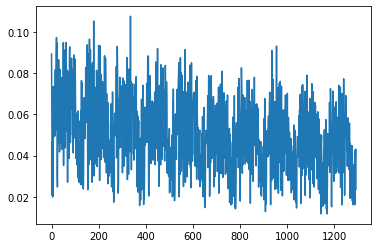

In [36]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([argument_lang.index('<SOS>')], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == lang.index('<EOS>'):
                break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

hidden_size = 256
learning_rate = 0.001
epochs = 10
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)
print(encoder)
print(argument_decoder)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

start = time.time()
plot_every = 1000
plot_losses = []
print_every = 1000
print_loss_total = 0  # Reset every print_every
plot_loss_total = 0  # Reset every plot_every
update = 0 # Counts updates

encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(argument_decoder.parameters(), lr=learning_rate)
training_pairs = [[sample[0], sample[2]] for sample in train_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
update_count = len(training_pairs) * epochs
print('updates: ', update_count)

criterion = nn.NLLLoss()

for epoch in range(epochs):
    for batch in training_pairs:
        update += 1
        training_pair = batch
        input_tensor = tensor_from_sentence(lang, training_pair[0])
        target_tensor = tensor_from_sentence(argument_lang, training_pair[1])

        loss = train(input_tensor, target_tensor, encoder,
                     argument_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if update % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (time_since(start, update / update_count),
                                         update, (update / update_count) * 100, print_loss_avg))

        if update % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        
    # Save model after every epoch
    torch.save(encoder.state_dict(), 'encoder.pt')
    torch.save(argument_decoder.state_dict(), 'argument_decoder.pt')

show_plot(plot_losses)

# Eval

In [70]:
def evaluate(encoder, decoder, sentence, encoder_lang, decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[encoder_lang.index('<SOS>')]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == encoder_lang.index('<EOS>'):
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(decoder_lang.word(topi.item()))

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    decoder.load_state_dict(torch.load('action_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in eval_pairs:
    output = evaluate(encoder, decoder, sample[0], lang, action_lang)
    print(f"{' '.join(sample[0])} ({sample[1][0]}) -> {output[0]} ({output[0][0] == sample[1][0]})")
    results.append(output[0][0] == sample[1][0])

samples: 1939
turn to the left and face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the clock that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left then face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the alarm clock on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
pick up the clock on the desk top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk to face right side of desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up red and grey bottle from desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to desk on right side of room (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on lamp on the desk (ToggleObject) -> ['PutObject', '<EOS>'] (False)
use the metal box to turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)

pick up the open box from the bottom shelf (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn on the light (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp that is to your left (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk forward turn right to face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the cd that is on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn the lamp on (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
walk to the right side of the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the cd from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
locate the lamp on the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
pick up the disc on the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and then turn back to the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the lam

turn right and head towards the cupboard (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cupboard and take out the newspaper (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left towards the standing light (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn on the standing light (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lap (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn on the lamp (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
go to the desk on your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab a pencil from the desk (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn the lamp on (ToggleObject) -> ['GotoLocation', '<EOS>'] (False)
turn to the right and face the desk (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick the pencil up from the desk (PickupObject) -> ['Pi

place the salt in the cabinet under the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
look up to see the cabinet at the top (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
move to the counter left of the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the salt from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
bring salt up the the cabinet above the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the salt shaker from the counter top (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left and walk in front of the oven (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open cabinet pick up salt from cabinet close cabinet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place salt in second drawer close drawer (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the salt shaker from the kitchen island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move left then right around the kitchen island (GotoLocation) -> ['Go

turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the glass with the knife inside the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the butter knife from beneath the sponge (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
grab the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around to the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the pan on the stove (PutObject) -> ['PutObject', '<EOS>'] (True)
grab the pan with the knife (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and take the 

put the green cup in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the fork next to the tomato (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the fork in the green cup (PutObject) -> ['PutObject', '<EOS>'] (True)
turn right then left back to the cabinet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cabinet above the coffee maker (PutObject) -> ['GotoLocation', '<EOS>'] (False)
turn left towards the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the glass vase in the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right to the cupboard and open them (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the glass vase on the gold plate (PutObject) -> ['PutObject', '<EOS>'] (True)
take them out of the cupboard (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn right and towards the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the vase and plate in the sink (PutObject) -> ['PutObject', '<EOS>'] (True

pick up the spoon on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the plate with the spoon on it (PickupObject) -> ['PickupObject', '<EOS>'] (True)
wash the bowl in the sink (CleanObject) -> ['CleanObject', '<EOS>'] (True)
pick up the dirty bowl on the island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around bring the bowl to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
fill the bowl with water from the sink (CleanObject) -> ['GotoLocation', '<EOS>'] (False)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn back around (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and move left to the toaster (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
wash the bowl in the sink (CleanObject) -> ['CleanObject',

look down to face the lettuce on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the lettuce on the counter into slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the knife in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the slice of lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and step forward to face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the lettuce slice in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
look down at the lettuce on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the lettuce on the counter (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn right and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up a slice of lettuce (PickupObject) 

place the plate on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
turn and go to the counter by the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a dirty plate on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn and go to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
wash the dish in the sink (CleanObject) -> ['CleanObject', '<EOS>'] (True)
turn and go to the counter by the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the plate on the counter by the stove (PutObject) -> ['PutObject', '<EOS>'] (True)
move back slightly away from the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around to face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around facing sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up bar of soap (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around take one step turn around (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk over t

pick up the head of lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk left back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the lettuce on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
chill the lettuce in the fridge (CoolObject) -> ['SliceObject', '<EOS>'] (False)
pick up the lettuce off of the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
put the lettuce down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the lettuce from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the lettuce to the refrigerator (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the lettuce on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left to face counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn left walk to fridge turn right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn right walk forward turn left to face counter (GotoLocation) -> ['

pick up the pan on the stove (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk left back to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk a few step right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
go left and stand in front of the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the pan on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
take a step to your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the pan on the front left burner (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick up the pan on the front left burner (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left to carry the pan to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the pan on the counter top (PutObject) -> ['PutObject', '<EOS>'] (True)
grab a pan from the stove (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the pan in the fridge then grab it (CoolObject) -> ['PickupObject', '<EOS>'] (False)
plac

pick up the knife from the center island (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to the counter next to the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the tomato on the counter with the knife (SliceObject) -> ['SliceObject', '<EOS>'] (True)
take the knife to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the knife in the fridge (PutObject) -> ['PutObject', '<EOS>'] (True)
go back to the tomato slice on the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up a tomato slice from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the tomato to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
set the tomato slice down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
slice the tomato (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife down in front of the keurig (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the right end of the tomato (PickupObject) -> ['PickupObjec

take two step to the right to face stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the apple slice on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife from the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple in the bin in to section (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife in the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up a section of apple (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn left move to in front of the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the cooked apple section in the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the butter knife on the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
slice the apple in the trash can (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the butter knife in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and go to the microwave (GotoLocation) -> ['GotoLocation',

heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
open the cabinet and place the cup inside (PutObject) -> ['PutObject', '<EOS>'] (True)
take a few step right to the microwave (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the coffee mug on the coffee maker (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take the mug out of the coffee maker (PickupObject) -> ['PickupObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
heat the mug in the microwave (HeatObject) -> ['HeatObject', '<EOS>'] (True)
take a step left (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
walk to face coffee maker (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
remove mug from inside coffee maker (PickupObject) -> ['Picku

turn left and go to the fridge (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the tomato from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
place the tomato inside of the bin (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and face the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick the tomato up from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the microwave above the stove (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the tomato in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and walk to the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the tomato from the sink (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and look up (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the tomato in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the tomato from the kitchen island (PickupObject) -> ['PickupObject', '<EOS>'] (Tr

turn left and head to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab the apple out of the trash can (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and head to the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the apple down on the counter (PutObject) -> ['PutObject', '<EOS>'] (True)
pick up the knife off of the counter (PickupObject) -> ['PickupObject', '<EOS>'] (True)
cut the apple into three slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
turn around and stop at the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
cut the apple in the sink into three slice (SliceObject) -> ['SliceObject', '<EOS>'] (True)
put the knife into the sink (PutObject) -> ['PutObject', '<EOS>'] (True)
grab one of the apple slice (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and face the counter (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the apple slice on the counter (PutObject) -> ['PutObject', '<EOS>'] (True

walk to face white couch (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up key from couch (PickupObject) -> ['PickupObject', '<EOS>'] (True)
walk to face small white safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put key inside safe (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around then face the couch to your right (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the key in the safe on the floor (PutObject) -> ['PutObject', '<EOS>'] (True)
place the key in the safe on the floor (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around go to the white sofa (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up the key-chain from the sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
pick the key-chain from that sofa (PickupObject) -> ['PickupObject', '<EOS>'] (True)
go back to the safe (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the key-chain inside the safe and close it (PutObject) -> ['PutObject', '<EOS>'] (True)
place the key in the

go to the toilet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
turn around and go to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn around and go to the toilet (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
grab a bar of soap off of the toilet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
turn around and go to the trash can (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
put the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
turn left and face the back of the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
place the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
place the soap in the trash can (PutObject) -> ['PutObject', '<EOS>'] (True)
move towards toilet to the right of the sink (GotoLocation) -> ['GotoLocation', '<EOS>'] (True)
pick up toilet roll from off the toilet (PickupObject) -> ['PickupObject', '<EOS>'] (True)
move

In [73]:
print(f"Success rate: {sum(results) / len(results)}")

Success rate: 0.9004641567818463


# Eval Action / Arguments

In [37]:
def evaluate(encoder, action_decoder, argument_decoder, sentence, encoder_lang, action_decoder_lang, argument_decoder_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(encoder_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        
        # Action Decoder
        action_decoder_input = torch.tensor([[action_decoder_lang.index('<SOS>')]], device=device)  # SOS
        action_decoder_hidden = encoder_hidden
        action_decoded_words = []
        action_decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, action_decoder_hidden, decoder_attention = action_decoder(
                action_decoder_input, action_decoder_hidden, encoder_outputs)
            action_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == action_decoder_lang.index('<EOS>'):
                action_decoded_words.append('<EOS>')
                break
            else:
                action_decoded_words.append(action_decoder_lang.word(topi.item()))
        
            action_decoder_input = topi.squeeze().detach()
        
        # Argument Decoder
        argument_decoder_input = torch.tensor([[argument_decoder_lang.index('<SOS>')]], device=device)  # SOS
        argument_decoder_hidden = encoder_hidden
        argument_decoded_words = []
        argument_decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, argument_decoder_hidden, decoder_attention = argument_decoder(
                argument_decoder_input, argument_decoder_hidden, encoder_outputs)
            argument_decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == argument_decoder_lang.index('<EOS>'):
                argument_decoded_words.append('<EOS>')
                break
            else:
                argument_decoded_words.append(argument_decoder_lang.word(topi.item()))

            argument_decoder_input = topi.squeeze().detach()

        return action_decoded_words, argument_decoded_words

hidden_size = 256
encoder = EncoderRNN(lang.n_words, hidden_size).to(device)
action_decoder = AttnDecoderRNN(hidden_size, action_lang.n_words, dropout_p=0.1).to(device)
argument_decoder = AttnDecoderRNN(hidden_size, argument_lang.n_words, dropout_p=0.1).to(device)

# Load state if exists, WARNING: DELETE FILES WHEN CHANGING MODEL 
if os.path.isfile('encoder.pt'):
    encoder.load_state_dict(torch.load('encoder.pt'))
if os.path.isfile('action_decoder.pt'):
    action_decoder.load_state_dict(torch.load('action_decoder.pt'))
if os.path.isfile('argument_decoder.pt'):
    argument_decoder.load_state_dict(torch.load('argument_decoder.pt'))

eval_pairs = [sample for sample in eval_low_action_argument_pairs if len(sample[0]) < MAX_LENGTH and len(sample[1]) < MAX_LENGTH]
results = []
print(f"samples: {len(eval_pairs)}")
for sample in tqdm.tqdm(eval_pairs):
    output = evaluate(encoder, action_decoder, argument_decoder, sample[0], lang, action_lang, argument_lang)
    arg_result = output[1][0] == sample[2][0]
    if len(sample[2]) > 1:
        arg_result &= output[1][1] == sample[2][1]
    print(' '.join(sample[0]), output[1][:-1], sample[2])
    #results.append(output[0][0] == sample[1][0] and arg_result)
    results.append(arg_result)

  0%|                                                                                 | 7/4627 [00:00<01:12, 63.64it/s]

samples: 4627
turn to left face desk ['desk'] ['desk']
pick up clock from back desk desk ['alarmclock'] ['alarmclock']
carry clock turn to right turn to left then face desk on left alarmclock ['shelf'] ['desklamp']
hold clock turn on lamp on right side desk desklamp ['desklamp'] ['desklamp']
turn around completely then turn right to face desk ['shelf'] ['desk']
pick up clock that on desk desk ['alarmclock'] ['alarmclock']
turn on lamp that sitting on desk desklamp ['desklamp'] ['desklamp']
turn around face desk ['diningtable'] ['desk']
grab canteen off desk desk ['cellphone'] ['alarmclock']
turn right find desk with lamp alarmclock ['desklamp'] ['desklamp']
turn lamp on desklamp ['desklamp'] ['desklamp']
turn left then face desk ['shelf'] ['desk']


  0%|▎                                                                               | 21/4627 [00:00<01:08, 66.91it/s]

pick up alarm clock on desk desk ['alarmclock'] ['alarmclock']
turn right then walk straight head to desk with lamp on your left alarmclock ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
move left to wood desk top where clock ['desk'] ['desk']
pick up clock on desk top desk ['alarmclock'] ['alarmclock']
carry clock to right side desk where lamp alarmclock ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk to face right side desk ['diningtable'] ['desk']
pick up red grey bottle from desk desk ['alarmclock'] ['alarmclock']
walk to desk on right side room alarmclock ['desk'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn around walk to right then turn left walk to desk ['diningtable'] ['desk']
pick up metal box that on top desk desk ['alarmclock'] ['alarmclock']
use metal box to turn on lamp desklamp ['desklamp'] ['desklamp']


  1%|▌                                                                               | 35/4627 [00:00<01:10, 65.46it/s]

turn around walk forward then turn left walk up to side wooden desk ['desk'] ['desk']
pick up alarm clock from desk desk ['alarmclock'] ['alarmclock']
walk forward around to right side desk alarmclock ['shelf'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn around walk to desk behind wall to your left ['diningtable'] ['desk']
pick up alarm clock on desk in front blue chair desk ['alarmclock'] ['alarmclock']
turn on lamp in front right corner desk desklamp ['desklamp'] ['desklamp']
walk forward bit towards baseball bat ['baseballbat'] ['baseballbat']
grab baseball bat leading against wall baseballbat ['baseballbat'] ['baseballbat']
turn walk to right side computer desk baseballbat ['desk'] ['desklamp']
turn on lamp on computer desk desklamp ['desklamp'] ['desklamp']
head towards bat on floor in front you ['baseballbat'] ['baseballbat']
pick up bat from floor baseballbat ['baseballbat'] ['baseballbat']


  1%|▊                                                                               | 49/4627 [00:00<01:08, 66.60it/s]

turn on lamp desklamp ['desklamp'] ['desklamp']
move to corner near door ['handtowelholder'] ['baseballbat']
pick up bat from floor baseballbat ['baseballbat'] ['baseballbat']
bring bat to desk baseballbat ['desklamp'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn around to face bat on ground ['baseballbat'] ['baseballbat']
pick up bat on ground baseballbat ['baseballbat'] ['baseballbat']
bring bat to lamp on desk baseballbat ['desklamp'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn around face wall with bat on floor ['baseballbat'] ['baseballbat']
pick baseball bat up off floor baseballbat ['baseballbat'] ['baseballbat']
turn around maneuver to desk at opposite corner room baseballbat ['shelf'] ['desklamp']
turn lamp on on desk desklamp ['desklamp'] ['desklamp']


  1%|█                                                                               | 63/4627 [00:00<01:11, 64.01it/s]

turn right head towards door turn right head towards bat on floor ['baseballbat'] ['baseballbat']
pick up bat from floor baseballbat ['baseballbat'] ['baseballbat']
turn on lamp desklamp ['desklamp'] ['desklamp']
go to baseball bat to right door ['baseballbat'] ['baseballbat']
pick up baseball bat next to door baseballbat ['baseballbat'] ['baseballbat']
go toward safe in far opposite corner turn right face desk with lamp baseballbat ['desklamp'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
head towards door turn right to face baseball bat on floor ['baseballbat'] ['baseballbat']
pick up bat from floor baseballbat ['baseballbat'] ['baseballbat']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk to door in front you turn right to face wall ['vase'] ['baseballbat']
pick up black bat leaning against wall baseballbat ['baseballbat'] ['baseballbat']
turn on small lamp desklamp ['desklamp'] ['desklamp']


  2%|█▎                                                                              | 77/4627 [00:01<01:12, 62.42it/s]

turn around go to foot bed ['bed'] ['basketball']
pick up basketball from floor basketball ['basketball'] ['basketball']
turn around go to desk in corner basketball ['desk'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn left walk to basketball on floor by bed ['basketball'] ['basketball']
pick up basketball from floor basketball ['basketball'] ['basketball']
turn left walk to lamp on desk which to left bed basketball ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
move to foot bed closest to wall ['bed'] ['basketball']
pick up basketball sitting on floor next to foot bed basketball ['basketball'] ['basketball']
carry basketball to left side wooden desk top basketball ['desklamp'] ['desklamp']
turn on lamp that on top desk desklamp ['desklamp'] ['desklamp']
walk to foot bed ['bed'] ['basketball']


  2%|█▍                                                                              | 85/4627 [00:01<01:09, 64.98it/s]

pick up basketball from floor basketball ['basketball'] ['basketball']
go to desk to your left basketball ['desk'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
move to right side foot bed closest to wall ['baseballbat'] ['basketball']
pick up basketball that on floor by foot bed basketball ['basketball'] ['basketball']
carry basketball to desk lamp on right side wood desk top basketball ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn right walk to face basketball underneath foot bed ['basketball'] ['basketball']
pick up basketball from under bed basketball ['basketball'] ['basketball']
turn left walk through room until desk turn left at desk face it basketball ['desk'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn right head to desk then turn left walk to basketball on floor ['basketball'] ['basketball']
pick up basketball from floor basketball ['basketball'] ['basketball']
turn on lamp desklamp ['desklamp'] ['d

  2%|█▋                                                                              | 99/4627 [00:01<01:10, 63.88it/s]

pick up basketball in front bed basketball ['basketball'] ['basketball']
turn on lamp desklamp ['desklamp'] ['desklamp']
pick up basketball that on floor basketball ['basketball'] ['basketball']
turn lamp on desklamp ['desklamp'] ['desklamp']
turn around walk to bed ['bed'] ['bed']
pick up what math book on bed bed ['book'] ['book']
walk around left side bed veer left to desk book ['cabinet'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn around go to foot bed ['bed'] ['bed']
pick up book from bed bed ['book'] ['book']
turn left go to desk in far corner room book ['desk'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn walk to bed ['bed'] ['bed']


  2%|█▉                                                                             | 113/4627 [00:01<01:09, 64.96it/s]

grab book that on bed bed ['book'] ['book']
carry book to night stand book ['sidetable'] ['desklamp']
hold book in front night stand desklamp ['desklamp'] ['desklamp']
turn right towards bed ['tennisracket'] ['bed']
pick up green book from bed bed ['book'] ['book']
turn around go to wall then turn to desk to left book ['desk'] ['desklamp']
turn on light desklamp ['desklamp'] ['desklamp']
turn right walk to bed ['bed'] ['bed']
pick up green book that say what math that sitting on bed bed ['book'] ['book']
turn around cross room then turn left at wall walk to desk book ['drawer'] ['desklamp']
turn on lamp that sitting on desk desklamp ['desklamp'] ['desklamp']
move to side bed facing green book on top bed ['bed'] ['bed']
pick up green book sitting on top bed bed ['book'] ['book']
carry book to desk in corner room with desk lamp on top it book ['desk'] ['desklamp']


  3%|██▏                                                                            | 128/4627 [00:01<01:06, 67.32it/s]

turn on lamp desklamp ['desklamp'] ['desklamp']
turn around take one step then turn left to bed ['bed'] ['bed']
pick up book behind computer on red sheet bed ['book'] ['book']
turn around walk toward wall stop at wall turn left towards computer table book ['desk'] ['desklamp']
turn on table lamp desklamp ['desklamp'] ['desklamp']
turn right go to side bed ['bed'] ['bed']
pick up book from bed bed ['book'] ['book']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn around walk to side bed ['bed'] ['bed']
grab book on bed bed ['book'] ['book']
turn around walk to side desk book ['desk'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
walk to end room ahead then turn right to face desk ['desk'] ['desk']


  3%|██▍                                                                            | 142/4627 [00:02<01:07, 66.05it/s]

grab clear bowl off table desk ['bowl'] ['bowl']
turn lamp on on right side desk desklamp ['desklamp'] ['desklamp']
go straight to desk chair then turn right to face desk ['shelf'] ['desk']
take bowl from desk desk ['bowl'] ['bowl']
turn lamp on desk on desklamp ['desklamp'] ['desklamp']
walk forward turn right to face desk closest to window ['desk'] ['desk']
pick up bowl from desk desk ['bowl'] ['bowl']
turn right walk to other desk bowl ['desk'] ['desklamp']
turn on desk lamp desklamp ['desklamp'] ['desklamp']
walk to left side desk in front you ['desk'] ['desk']
pick up bowl from desk desk ['bowl'] ['bowl']
turn right walk in front lamp that on desk to left bed bowl ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk around to front desk by chair ['desk'] ['desk']


  3%|██▋                                                                            | 157/4627 [00:02<01:05, 67.95it/s]

pick up bowl that closest to window desk ['bowl'] ['bowl']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
walk to window face desk ['desk'] ['desk']
pick up bowl on desk desk ['bowl'] ['bowl']
walk to second desk on other side room bowl ['desk'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn around go forward turn left go forward turn left face desk ['diningtable'] ['shelf']
pick up bowl from shelf shelf ['bowl'] ['bowl']
bring bowl to lamp on desk bowl ['desklamp'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
turn go right to face desk with lamp cup ['desklamp'] ['shelf']
pick bowl up from shelf shelf ['bowl'] ['bowl']
move to right face desk drawer bowl ['drawer'] ['desklamp']
turn lamp on desk on desklamp ['desklamp'] ['desklamp']


  4%|██▉                                                                            | 172/4627 [00:02<01:05, 67.58it/s]

move to wooden desk across from white safe ['desk'] ['shelf']
pick up clear bowl between book on desk shelf shelf ['bowl'] ['bowl']
carry clear bowl to face lamp on right desk bowl ['desklamp'] ['desklamp']
turn on lamp sitting on desk while holding bowl desklamp ['desklamp'] ['desklamp']
pick up box on blue chair armchair ['box'] ['box']
turn to right to face white couch then look up at wall box ['sofa'] ['floorlamp']
turn off lamp on left floorlamp ['floorlamp'] ['floorlamp']
walk to blue chair at top right corner room ['armchair'] ['armchair']
pick up empty box from chair armchair ['box'] ['box']
turn right face floor lamp next to chair box ['floorlamp'] ['floorlamp']
turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn to right then left to locate blue couch ['sofa'] ['armchair']
pick up box from couch armchair ['box'] ['box']


  4%|███▏                                                                           | 186/4627 [00:02<01:06, 66.55it/s]

take box turn right to other couch box ['sofa'] ['floorlamp']
turn lamp on in corner floorlamp ['floorlamp'] ['floorlamp']
turn right walk forward to large sofa ['sofa'] ['sofa']
pick up empty box from sofa sofa ['box'] ['box']
move slightly forward to face floor lamp next to sofa box ['floorlamp'] ['floorlamp']
turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn right walk to sofa ['sofa'] ['sofa']
grab box on sofa sofa ['box'] ['box']
turn to floor lamp by sofa box ['floorlamp'] ['floorlamp']
turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn to right walk to white couch across room ['sofa'] ['sofa']
pick up empty white box that to left cell phone sofa ['box'] ['box']
look up to left white couch box ['armchair'] ['floorlamp']
turn on lamp to left couch floorlamp ['floorlamp'] ['floorlamp']


  4%|███▎                                                                           | 193/4627 [00:02<01:07, 66.03it/s]

turn right move to fireplace turn left move to white shelf ['shelf'] ['shelf']
pick up open box on bottom shelf shelf ['box'] ['box']
turn around move across couch to right to lamp in corner box ['floorlamp'] ['floorlamp']
turn on tall lamp in corner floorlamp ['floorlamp'] ['floorlamp']
turn to right go forward to fireplace turn to left go forward to shelving ['shelf'] ['shelf']
pick up box on bottom shelf shelf ['box'] ['box']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk to shelf in front you to right ['shelf'] ['shelf']
pick up box on bottom shelf shelf ['box'] ['box']
turn to left walk to lamp in corner box ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn around head to white shelf on left side room ['shelf'] ['shelf']
pick up open box from bottom shelf shelf ['box'] ['box']


  4%|███▌                                                                           | 207/4627 [00:03<01:07, 65.74it/s]

turn around walk towards blue chair then turn right to face white sofa box ['sofa'] ['floorlamp']
turn on light floorlamp ['floorlamp'] ['floorlamp']
turn right walk towards tv turn left walk towards white shelf to right couch ['shelf'] ['shelf']
pick up box that on bottom shelf shelf ['box'] ['box']
turn on lamp that to your left floorlamp ['floorlamp'] ['floorlamp']
walk forward turn right to face desk ['desk'] ['desk']
pick up cd that on desk desk ['cd'] ['cd']
turn lamp on desklamp ['desklamp'] ['desklamp']
walk forward to wooden desk on your left ['countertop'] ['desk']
pick up disc on corner desk desk ['cd'] ['cd']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
move forward to desk turn to face desk ['diningtable'] ['desk']
pick up cd from right corner desk desk ['cd'] ['cd']


  5%|███▊                                                                           | 221/4627 [00:03<01:10, 62.87it/s]

turn on lamp that on desk desklamp ['desklamp'] ['desklamp']
go to garbage can on floor to right desk in front you ['garbagecan'] ['garbagecan']
remove cd from garbage bin garbagecan ['cd'] ['cd']
turn on lamp on front far right corner desk desklamp ['desklamp'] ['desklamp']
walk forward to gray trash can ['garbagecan'] ['garbagecan']
take cd out gray trash can garbagecan ['cd'] ['cd']
turn lamp on desklamp ['desklamp'] ['desklamp']
walk across room ['cart'] ['garbagecan']
pick up cd that in bin on floor garbagecan ['cd'] ['cd']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk to right side desk ['shelf'] ['shelf']
grab cd from desk shelf ['cd'] ['cd']


  5%|████                                                                           | 235/4627 [00:03<01:09, 63.09it/s]

locate lamp on desk cd ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
go to right end wooden desk in front you ['desk'] ['shelf']
pick up disc on desk shelf ['cd'] ['cd']
turn right then turn back to desk cd ['shelf'] ['desklamp']
turn on lamp on desk desklamp ['desklamp'] ['desklamp']
head to right side desk ['desk'] ['shelf']
take cd from desk shelf ['cd'] ['cd']
take step to right cd ['drawer'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk forward to dresser ['dresser'] ['dresser']
pick up cell phone from dresser dresser ['cellphone'] ['cellphone']
turn left go to lamp cellphone ['floorlamp'] ['floorlamp']


  5%|████▎                                                                          | 249/4627 [00:03<01:10, 62.20it/s]

hold cell phone turn lamp on floorlamp ['floorlamp'] ['floorlamp']
walk to dresser in front you ['dresser'] ['dresser']
pick up cell phone above left top drawer on dresser dresser ['cellphone'] ['cellphone']
go to lamp to your left in corner room cellphone ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk forward to dresser ['dresser'] ['dresser']
pick up phone that on dresser dresser ['cellphone'] ['cellphone']
take couple step to left to face lamp hold phone up cellphone ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
head to long black table on left in corner ['sidetable'] ['sidetable']
pick up phone on table sidetable ['cellphone'] ['cellphone']
turn around bring phone to lamp in corner cellphone ['floorlamp'] ['floorlamp']


  6%|████▎                                                                          | 256/4627 [00:03<01:10, 61.80it/s]

turn on lamp in corner floorlamp ['floorlamp'] ['floorlamp']
move to end table ahead you ['sidetable'] ['sidetable']
pick up phone from table sidetable ['cellphone'] ['cellphone']
move to lamp behind you cellphone ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move to front desk turn to face right side ['diningtable'] ['sidetable']
pick phone up from desk sidetable ['cellphone'] ['cellphone']
turn around cross room to stand in front lamp cellphone ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
turn left walk to white sofa turn left walk to blue sofa ['sofa'] ['armchair']
grab phone on blue sofa armchair ['cellphone'] ['cellphone']
turn right to lamp cellphone ['floorlamp'] ['floorlamp']


  6%|████▌                                                                          | 270/4627 [00:04<01:12, 60.29it/s]

turn on lamp floorlamp ['floorlamp'] ['floorlamp']
pick up cell phone on back arm chair s seat behind computer armchair ['cellphone'] ['cellphone']
turn to lamp at your right in corner cellphone ['floorlamp'] ['floorlamp']
turn on lamp in corner floorlamp ['floorlamp'] ['floorlamp']
move to couch to left fire place ['sofa'] ['armchair']
pick up phone from couch armchair ['cellphone'] ['cellphone']
move to left couch cellphone ['sofa'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move left then face right side large tan couch ['sofa'] ['sofa']
pick up red credit card on top couch sofa ['creditcard'] ['creditcard']
carry credit card to lamp in corner room creditcard ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']


  6%|████▊                                                                          | 283/4627 [00:04<01:14, 58.61it/s]

turn left walk towards blue chair then turn right to face couch ['sofa'] ['sofa']
pick up red credit card off couch sofa ['creditcard'] ['creditcard']
turn on light tall lamp floorlamp ['floorlamp'] ['floorlamp']
turn left take step then turn right face couch ['sofa'] ['sofa']
pick up red credit card that sitting on couch sofa ['creditcard'] ['creditcard']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move to left side tan sofa where credit card ['sofa'] ['sofa']
pick up credit card on top sofa sofa ['creditcard'] ['creditcard']
carry credit card to left corner room facing floor lamp creditcard ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk to face couch ['sofa'] ['sofa']
pick up red credit card from couch sofa ['creditcard'] ['creditcard']


  6%|█████                                                                          | 297/4627 [00:04<01:12, 60.13it/s]

walk left to face lamp creditcard ['floorlamp'] ['floorlamp']
turn on lamp near couch floorlamp ['floorlamp'] ['floorlamp']
turn around walk forward to face card on left end couch ['sidetable'] ['sofa']
pick up card on couch sofa ['creditcard'] ['creditcard']
look to left to face lamp in corner room creditcard ['floorlamp'] ['floorlamp']
cut on lamp to examine card floorlamp ['floorlamp'] ['floorlamp']
turn left walk to white couch on right ['sofa'] ['sofa']
pick up red credit card from right couch cushion sofa ['creditcard'] ['creditcard']
turn left walk to tall lamp in corner on right creditcard ['floorlamp'] ['floorlamp']
turn on tall lamp floorlamp ['floorlamp'] ['floorlamp']
turn left walk straight then turn right towards couch ['sofa'] ['sofa']
pick up credit card off couch sofa ['creditcard'] ['creditcard']


  7%|█████▎                                                                         | 310/4627 [00:04<01:12, 59.64it/s]

turn left then walk straight then turn right towards couch look up creditcard ['shelf'] ['floorlamp']
turn lamp on by couch floorlamp ['floorlamp'] ['floorlamp']
turn to left then right to face right side couch ['sofa'] ['sofa']
pick red credit card up from couch sofa ['creditcard'] ['creditcard']
turn to left stand on left side couch near floor lamp creditcard ['sofa'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
walk forward to safe then turn left walk to blue armchair ['armchair'] ['armchair']
pick up key chain in front remote control on armchair armchair ['keychain'] ['keychain']
turn right walk slightly forward to tall lamp in front you keychain ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
pick up leftmost set key from chair armchair ['keychain'] ['keychain']
turn right to carry key closer to lamp which between chair sofa keychain ['floorlamp'] ['floorlamp']


  7%|█████▍                                                                         | 317/4627 [00:04<01:11, 60.34it/s]

turn on lamp to look at key floorlamp ['floorlamp'] ['floorlamp']
turn around hang left to walk to blue armchair ['armchair'] ['armchair']
pick up leftmost key from blue armchair armchair ['keychain'] ['keychain']
turn to face tall lamp on right keychain ['floorlamp'] ['floorlamp']
turn on tall lamp floorlamp ['floorlamp'] ['floorlamp']
turn around walk to blue chair on right ['armchair'] ['armchair']
pick up set key in back right corner chair armchair ['keychain'] ['keychain']
turn right to face couch next to tall lamp keychain ['sofa'] ['floorlamp']
turn on tall lamp to left floorlamp ['floorlamp'] ['floorlamp']
turn around walk straight then turn right walk straight towards blue chair ['armchair'] ['armchair']
pick up key on chair armchair ['keychain'] ['keychain']
turn right look up at lamp keychain ['floorlamp'] ['floorlamp']


  7%|█████▋                                                                         | 331/4627 [00:05<01:11, 60.44it/s]

turn lamp on floorlamp ['floorlamp'] ['floorlamp']
turn around move forward then turn right go straight to blue chair ['armchair'] ['armchair']
pick up key from blue chair armchair ['keychain'] ['keychain']
turn right look up to face lamp keychain ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
pick up set key that are on bottom shelf shelf ['keychain'] ['keychain']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
go forward to couch then turn right to go to shelf up ahead ['shelf'] ['shelf']
pick up key from bottom shelf shelf ['keychain'] ['keychain']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
go right face white shelf with gold vase ['shelf'] ['shelf']
pick key up from bottom shelf cabinet shelf ['keychain'] ['keychain']


  7%|█████▉                                                                         | 345/4627 [00:05<01:11, 60.12it/s]

turn around cross room turn to right to face lamp in corner keychain ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
step forward then turn right to go to dresser ['dresser'] ['dresser']
pick up computer on dresser in front statue dresser ['laptop'] ['laptop']
turn right then go forward to go toward lamp laptop ['desklamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk to laptop computer on tall brown dresser ['dresser'] ['dresser']
close laptop pick it up dresser ['laptop'] ['laptop']
turn right walk to white sofa laptop ['sofa'] ['floorlamp']
look up turn on standing lamp next to sofa floorlamp ['floorlamp'] ['floorlamp']
turn right towards dresser with laptop ['desk'] ['dresser']
close lid laptop on dresser pick up laptop dresser ['laptop'] ['laptop']
turn right walk towards white sofa laptop ['sofa'] ['floorlamp']


  8%|██████                                                                         | 358/4627 [00:05<01:11, 59.64it/s]

raise laptop up turn on lamp on left floorlamp ['floorlamp'] ['floorlamp']
turn to right move across room to face dresser ['dresser'] ['dresser']
close lid laptop pick it up dresser ['laptop'] ['laptop']
turn to right move towards white couch laptop ['sofa'] ['floorlamp']
turn on lamp next to couch floorlamp ['floorlamp'] ['floorlamp']
turn to your right walk towards cabinet ['dresser'] ['dresser']
pick up laptop on cabinet dresser ['laptop'] ['laptop']
turn to your right walk straight to lamp on your left beside sofa laptop ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn right walk forward to dresser ['dresser'] ['dresser']
close computer that on dresser pick up computer dresser ['laptop'] ['laptop']
turn right walk forward to couch lift computer up to lamp laptop ['floorlamp'] ['floorlamp']


  8%|██████▎                                                                        | 370/4627 [00:05<01:11, 59.24it/s]

turn lamp on floorlamp ['floorlamp'] ['floorlamp']
turn to left then find desk ['desk'] ['dresser']
close laptop then pick it up dresser ['laptop'] ['laptop']
turn to right then stand in front couch laptop ['sofa'] ['floorlamp']
turn on lamp on your left floorlamp ['floorlamp'] ['floorlamp']
turn left head towards dresser ['desk'] ['dresser']
close lid laptop on right pick it up dresser ['laptop'] ['laptop']
turn right head towards white sofa laptop ['sofa'] ['floorlamp']
turn on lamp to left sofa floorlamp ['floorlamp'] ['floorlamp']
turn to your left walk to cabinet where laptop are ['desk'] ['dresser']
pick up laptop on right after closing it dresser ['laptop'] ['laptop']
turn to your right walk up to floor lamp between two chair laptop ['floorlamp'] ['floorlamp']


  8%|██████▌                                                                        | 383/4627 [00:06<01:11, 59.01it/s]

turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn left move to brown cabinet with two computer on top ['dresser'] ['dresser']
close computer on right pick it up dresser ['laptop'] ['laptop']
turn right carry computer to sofa laptop ['sofa'] ['floorlamp']
turn on light in corner to left sofa to look at computer floorlamp ['floorlamp'] ['floorlamp']
turn left walk to dresser ['dresser'] ['dresser']
close laptop in front pick it up dresser ['laptop'] ['laptop']
turn right walk to beige couch laptop ['sofa'] ['floorlamp']
turn on light next to beige couch floorlamp ['floorlamp'] ['floorlamp']
move to left facing large brown cabinet where laptop ['desk'] ['dresser']
pick up laptop on far left side on top cabinet dresser ['laptop'] ['laptop']
carry laptop to large floor lamp to left tan sofa laptop ['floorlamp'] ['floorlamp']


  9%|██████▋                                                                        | 395/4627 [00:06<01:11, 59.32it/s]

turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn to left take few step turn to left go to dresser ['dresser'] ['dresser']
close notebook computer pick up from dresser dresser ['laptop'] ['laptop']
turn to right go to white sofa laptop ['sofa'] ['floorlamp']
turn on lamp left white sofa floorlamp ['floorlamp'] ['floorlamp']
turn around head towards dresser with two laptop ['desk'] ['dresser']
close lid laptop on right pick it up dresser ['laptop'] ['laptop']
turn right head towards white couch laptop ['sofa'] ['floorlamp']
turn on lamp on left couch floorlamp ['floorlamp'] ['floorlamp']
turn around walk across room to large dresser ['dresser'] ['dresser']
close pick up right most laptop from dresser dresser ['laptop'] ['laptop']
turn right walk to floor lamp in corner laptop ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']


  9%|██████▉                                                                        | 408/4627 [00:06<01:09, 60.51it/s]

turn around head to dressed across room ['toilet'] ['dresser']
take laptop computer from dresser dresser ['laptop'] ['laptop']
turn to right head to couch laptop ['sofa'] ['floorlamp']
turn on lamp in corner floorlamp ['floorlamp'] ['floorlamp']
turn around walk to brown cabinet with laptop on face laptop ['desk'] ['dresser']
close lid laptop on right pick it up dresser ['laptop'] ['laptop']
turn right walk to cream colored couch face it laptop ['sofa'] ['floorlamp']
turn on light floorlamp ['floorlamp'] ['floorlamp']
walk to laptop ['sidetable'] ['dresser']
close one on right pick it up dresser ['laptop'] ['laptop']
take laptop to nightstand laptop ['desklamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
go to desk in front you then look up to shelf ['shelf'] ['shelf']


  9%|███████▏                                                                       | 422/4627 [00:06<01:08, 61.78it/s]

pick up mug from shelf shelf ['mug'] ['mug']
look down to lamp on desk mug ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk forward to mug on desk in front you ['shelf'] ['shelf']
pick up mug from desk shelf ['mug'] ['mug']
walk slightly to right stand in front lamp on desk mug ['desklamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
walk to computer desk in front you ['desk'] ['shelf']
grab cup from shelf on desk shelf ['mug'] ['mug']
go to right desk mug ['desk'] ['desklamp']
turn lamp on desklamp ['desklamp'] ['desklamp']
turn to your left go to desk in front you ['desk'] ['shelf']
pick up white coffee cup between computer lamp on desk shelf ['mug'] ['mug']


  9%|███████▎                                                                       | 429/4627 [00:06<01:08, 61.33it/s]

move to your right so that you are at right end desk mug ['desk'] ['desklamp']
turn on lamp on front right corner desk desklamp ['desklamp'] ['desklamp']
walk to face desk ['desk'] ['shelf']
pick up white mug from desk shelf ['mug'] ['mug']
step back slightly to continue to face desk mug ['cabinet'] ['desklamp']
turn on desk lamp on desk desklamp ['desklamp'] ['desklamp']
turn to your left walk to desk ['diningtable'] ['shelf']
pick up white mug sitting behind blue pencil between laptop lamp shelf ['mug'] ['mug']
move to your right stand in front lamp mug ['floorlamp'] ['desklamp']
turn lamp on desklamp ['desklamp'] ['desklamp']
pick up mug that on desk closest to wall desk ['mug'] ['mug']
turn on lamp that on desk desklamp ['desklamp'] ['desklamp']


 10%|███████▌                                                                       | 443/4627 [00:07<01:08, 60.72it/s]

pick up white mug from desk desk ['mug'] ['mug']
turn lamp on desklamp ['desklamp'] ['desklamp']
pick up mug nearest to wall on desk desk ['mug'] ['mug']
turn on lamp desklamp ['desklamp'] ['desklamp']
turn to left walk to sofa ['sofa'] ['sofa']
pick up newspaper from sofa sofa ['newspaper'] ['newspaper']
walk to floor lamp that to left sofa newspaper ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move to right side large tan sofa ['sofa'] ['sofa']
pick up newspaper on top sofa sofa ['newspaper'] ['newspaper']
carry newspaper to left side sofa where lamp newspaper ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']


 10%|███████▊                                                                       | 457/4627 [00:07<01:06, 62.87it/s]

turn to left twice take few step forward turn to right go to sofa ['sofa'] ['sofa']
pick up newspaper from sofa sofa ['newspaper'] ['newspaper']
turn to right go to blue chair turn to right newspaper ['sofa'] ['floorlamp']
turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn right head towards cupboard ['sidetable'] ['cabinet']
open cupboard take out newspaper cabinet ['newspaper'] ['newspaper']
turn left towards standing light newspaper ['floorlamp'] ['floorlamp']
turn on standing light floorlamp ['floorlamp'] ['floorlamp']
move to middle door large wooden cabinet ['cabinet'] ['cabinet']
open middle cabinet door remove newspaper sitting on bottom cabinet ['newspaper'] ['newspaper']
carry newspaper to floor lamp to left cabinet newspaper ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk forward turn right at cabinet approach computer ['shelf'] ['cabinet']
open left cabinet door remove newspaper close door cabinet ['newspaper'] ['newspaper']


 10%|████████                                                                       | 471/4627 [00:07<01:08, 60.36it/s]

turn left walk to trash can turn right put newspaper on top dresser newspaper ['newspaper', 'dresser'] ['floorlamp']
turn on lap floorlamp ['floorlamp'] ['floorlamp']
move to right side wood cupboard to left blue sofa ['laptop'] ['cabinet']
open right cupboard then remove newspaper in cupboard cabinet ['newspaper'] ['newspaper']
carry newspaper to lamp that left tan sofa newspaper ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk up to very last cabinet door on your left ['cabinet'] ['cabinet']
open door pick up newspaper that in cabinet cabinet ['newspaper'] ['newspaper']
turn to your right walk up to white sofa newspaper ['sofa'] ['floorlamp']
turn on lamp that to left white sofa floorlamp ['floorlamp'] ['floorlamp']
open cabinet door on far right bureau take out newspaper close cabinet door cabinet ['newspaper'] ['newspaper']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']


 10%|████████▏                                                                      | 478/4627 [00:07<01:07, 61.79it/s]

go to desk on your right ['desk'] ['desk']
grab pencil from desk desk ['pencil'] ['pencil']
walk to computer desk behind you to your left pencil ['desk'] ['desklamp']
turn lamp on desklamp ['desklamp'] ['desklamp']
move step forward face to desk on right ['desk'] ['desk']
pick up pencil from center desk desk ['pencil'] ['pencil']
hold pencil turn on lamp on right side desk desklamp ['desklamp'] ['desklamp']
turn to right face desk ['desk'] ['desk']
pick pencil up from desk desk ['pencil'] ['pencil']
turn to right then left turn left again to face lamp on desk pencil ['floorlamp'] ['desklamp']
turn lamp on desk on desklamp ['desklamp'] ['desklamp']
go to desk ['diningtable'] ['desk']
pick up pencil from desk desk

 11%|████████▍                                                                      | 492/4627 [00:07<01:08, 60.49it/s]

 ['pencil'] ['pencil']
take pencil to lamp pencil ['floorlamp'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
pick up pencil from desk which under cell phone desk ['pencil'] ['pencil']
walk slightly to right turn left to face lamp on desk pencil ['bowl'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
pick up pencil next to cell phone on desk desk ['pencil'] ['pencil']
move to right toward lamp pencil ['drawer'] ['desklamp']
turn on lamp desklamp ['desklamp'] ['desklamp']
cross room to left then turn to left face lamp on desk ['dresser'] ['shelf']
pick pencil up from shelf above computer on desk shelf ['pencil'] ['pencil']
look down at lamp pencil ['desklamp'] ['desklamp']


 11%|████████▋                                                                      | 506/4627 [00:08<01:07, 61.03it/s]

turn lamp on desklamp ['desklamp'] ['desklamp']
walk to right side wooden desk to your left ['desk'] ['shelf']
pick up pencil off middle shelf behind desk shelf ['pencil'] ['pencil']
look down at lamp on desk pencil ['bowl'] ['desklamp']
turn on light small lamp desklamp ['desklamp'] ['desklamp']
pick up white pencil that sitting on shelf above desk shelf ['pencil'] ['pencil']
lower pencil down to desk area pencil ['desk'] ['desklamp']
turn on lamp that sitting on desk desklamp ['desklamp'] ['desklamp']
turn to left then right to brown dresser ['dresser'] ['dresser']
pick up remote from middle dresser directly behind tissue dresser ['remotecontrol'] ['remotecontrol']
hold remote move step to left remotecontrol ['floorlamp'] ['floorlamp']
hold remote turn on lamp floorlamp ['floorlamp'] ['floorlamp']
pick up remote behind box tissue on dresser dresser ['remotecontrol'] ['remotecontrol']


 11%|████████▉                                                                      | 520/4627 [00:08<01:08, 59.58it/s]

turn on lamp in corner floorlamp ['floorlamp'] ['floorlamp']
hang right to walk towards dresser in corner ['sidetable'] ['dresser']
pick on remote that on dresser dresser ['remotecontrol'] ['remotecontrol']
turn to face lamp on right dresser remotecontrol ['floorlamp'] ['floorlamp']
turn on lamp next to dresser floorlamp ['floorlamp'] ['floorlamp']
pick up remote that on blue chair armchair ['remotecontrol'] ['remotecontrol']
turn right towards tan couch then point remote at wall remotecontrol ['sofa'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn left hang left at couch walk to blue chair ahead ['armchair'] ['armchair']
pick up remote control from back left corner cushion on chair armchair ['remotecontrol'] ['remotecontrol']
turn left walk to end couch ahead remotecontrol ['sofa'] ['floorlamp']
turn on tall lamp to left couch floorlamp ['floorlamp'] ['floorlamp']


 12%|█████████                                                                      | 533/4627 [00:08<01:08, 59.62it/s]

turn left walk ahead veering left to blue chair in corner ['armchair'] ['armchair']
pick up remote on chair armchair ['remotecontrol'] ['remotecontrol']
turn right walk to lamp in corner room remotecontrol ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
pick up remote to left cardboard box on chair armchair ['remotecontrol'] ['remotecontrol']
turn to lamp on your right between arm chair couch remotecontrol ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk to couch take left walk to blue chair ['armchair'] ['armchair']
pick up remote from blue chair armchair ['remotecontrol'] ['remotecontrol']
turn right to face couch lift remote to lamp remotecontrol ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']
walk forward make left until blue armchair reached ['armchair'] ['armchair']


 12%|█████████▏                                                                     | 540/4627 [00:08<01:08, 60.00it/s]

pick up remote from seat blue armchair armchair ['remotecontrol'] ['remotecontrol']
turn to face tall lamp on right blue armchair remotecontrol ['floorlamp'] ['floorlamp']
turn on tall lamp floorlamp ['floorlamp'] ['floorlamp']
turn around walk towards white shelf ['shelf'] ['shelf']
pick up statue trophy on top shelf shelf ['statue'] ['statue']
turn left walk towards tall lamp statue ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn around face shelf behind you ['shelf'] ['shelf']
pick up statue from top shelf shelf ['statue'] ['statue']
turn around walk in front couch to lamp statue ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn around go forward to shelf ['shelf'] ['shelf']
pick up statue on top shelf shelf ['statue'] ['statue']


 12%|█████████▍                                                                     | 554/4627 [00:08<01:05, 62.56it/s]

turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move to dresser behind you ['dresser'] ['dresser']
pick up statue from dresser dresser ['statue'] ['statue']
move to lamp to left statue ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn around walk to dresser ['dresser'] ['dresser']
pick up black statue that sitting on dresser to left open box dresser ['statue'] ['statue']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn around walk to face bureau drawer with statue box on top ['dresser'] ['dresser']
pick up human figure statue from top bureau dresser ['statue'] ['statue']
walk left to face left edge bureau drawer floor lamp statue ['dresser'] ['floorlamp']
turn on floor lamp floorlamp ['floorlamp'] ['floorlamp']
turn right walk towards door then hang right walk up to wooden dresser ['shelf'] ['dresser']


 12%|█████████▋                                                                     | 568/4627 [00:09<01:04, 62.99it/s]

pick up leftmost black statue off wooden dresser dresser ['statue'] ['statue']
turn left walk to lamp that to left wooden dresser statue ['floorlamp'] ['floorlamp']
turn on light lamp floorlamp ['floorlamp'] ['floorlamp']
walk to front dresser where statue are ['dresser'] ['dresser']
pick up statue from dresser dresser ['statue'] ['statue']
walk statue to lamp on stand raise statue statue ['floorlamp'] ['floorlamp']
turn lamp on to look at statue floorlamp ['floorlamp'] ['floorlamp']
move right then right again go straight to wood end table ['sidetable'] ['dresser']
pick up statue on top end table dresser ['statue'] ['statue']
move slightly left to face floor lamp to left end table statue ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk forward across room then turn right go to large wooden cabinet ['dresser'] ['cabinet']
open bottom left cabinet door remove tissue box from it cabinet ['tissuebox'] ['tissuebox']


 13%|█████████▉                                                                     | 582/4627 [00:09<01:02, 64.46it/s]

move few foot to left to face floor lamp in corner tissuebox ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk forward veer all way right to left side dresser on far wall ['dresser'] ['cabinet']
take tissue box out bottom left cabinet cabinet ['tissuebox'] ['tissuebox']
turn left look at lamp tissuebox ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk forward to end room then hang right go forward to other end room ['cloth'] ['cabinet']
open up cabinet door grab box tissue out it cabinet ['tissuebox'] ['tissuebox']
move left bit face lamp to left cabinet tissuebox ['desklamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn right turn left walk to cabinet ['dresser'] ['cabinet']
open closet at right bottom take tissue box out close closet cabinet ['tissuebox'] ['tissuebox']
turn right walk to white sofa tissuebox ['sofa'] ['floorlamp']


 13%|██████████▏                                                                    | 596/4627 [00:09<01:03, 63.84it/s]

turn on lamp by sofa floorlamp ['floorlamp'] ['floorlamp']
move to dresser to left blue chair ['dresser'] ['cabinet']
turn to right move to left arm white couch look up at lampshade tissuebox ['coffeetable'] ['floorlamp']
turn on floor lamp in between blue chair white couch floorlamp ['floorlamp'] ['floorlamp']
walk to wooden cabinet next to couch ['sidetable'] ['cabinet']
grab box tissue out from bottom right cabinet cabinet ['tissuebox'] ['tissuebox']
walk to lamp in corner room tissuebox ['floorlamp'] ['floorlamp']
turn on lamp in corner room floorlamp ['floorlamp'] ['floorlamp']
turn to dresser on your right ['dresser'] ['dresser']
pick up box tissue dresser ['tissuebox'] ['tissuebox']
turn go to lamp in corner on your left tissuebox ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn right move to dresser ['dresser'] ['dresser']


 13%|██████████▍                                                                    | 610/4627 [00:09<01:03, 63.51it/s]

pick up box tissue from dresser dresser ['tissuebox'] ['tissuebox']
head to lamp at left dresser tissuebox ['desklamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
walk to right reach cross to wooded brown dresser with computer ['dresser'] ['dresser']
grab tissue paper from dresser dresser ['tissuebox'] ['tissuebox']
walk to right for two pace you reach corner lamp tissuebox ['floorlamp'] ['floorlamp']
carry tissue you turn on lamp floorlamp ['floorlamp'] ['floorlamp']
pick up golden vase that sitting on shelf shelf ['vase'] ['vase']
lift up vase turn on lamp floorlamp ['floorlamp'] ['floorlamp']
go forward to right to face white shelf with gold vase ['shelf'] ['shelf']
pick vase up from shelf shelf ['vase'] ['vase']
turn around cross room to face lamp to right blue chair vase ['floorlamp'] ['floorlamp']
turn lamp on floorlamp ['floorlamp'] ['floorlamp']


 13%|██████████▋                                                                    | 624/4627 [00:09<01:01, 65.56it/s]

pick up gold vase on left side white shelf shelf ['vase'] ['vase']
turn around walk across room to lamp between blue white couch vase ['floorlamp'] ['floorlamp']
turn on lamp in corner room floorlamp ['floorlamp'] ['floorlamp']
turn right then head towards desk ['desk'] ['cabinet']
open left door in desk cabinet ['baseballbat'] ['vase']
pick up brass candy dish inside then close door vase ['plate'] ['floorlamp']
turn left then turn on lamp against wall floorlamp ['floorlamp'] ['floorlamp']
walk towards door then hang right walk to wooden dresser ['dresser'] ['cabinet']
open leftmost cabinet door below dresser take out golden vase then close door cabinet ['vase'] ['vase']
turn on light tall lamp floorlamp ['floorlamp'] ['floorlamp']
move to bottom left side cabinet ['cabinet'] ['cabinet']
pick up gold vase in cabinet cabinet ['vase'] ['vase']
carry gold vase to floor lamp on right vase ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']


 14%|██████████▊                                                                    | 632/4627 [00:10<00:59, 67.01it/s]

turn left walk to cabinet ['dresser'] ['cabinet']
open second door from right take vase out cabinet ['glassbottle'] ['vase']
turn right walk to corner vase ['safe'] ['floorlamp']
turn on lamp on end table floorlamp ['floorlamp'] ['floorlamp']
move to middle wood cupboard wood table ['cabinet'] ['cabinet']
open middle cupboard remove gold vase in cupboard shut cupboard cabinet ['vase'] ['vase']
carry gold vase to floor lamp on left vase ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
move to end table dresser to left blue arm chair ['sidetable'] ['cabinet']
pick up vase from cabinet cabinet ['vase'] ['vase']
move to lamp to right vase ['floorlamp'] ['floorlamp']
turn on lamp floorlamp ['floorlamp'] ['floorlamp']
turn right move towards chair turn left move towards door ['countertop'] ['baseballbat']
pick up bat baseballbat ['baseballbat'] ['baseballbat']


 14%|███████████                                                                    | 647/4627 [00:10<00:59, 66.98it/s]

turn around move towards chair then turn right move towards bed baseballbat ['bed'] ['bed']
drop bat on bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
pick up black bat lying in corner room baseballbat ['baseballbat'] ['baseballbat']
head to corner room with baseball bat ['baseballbat'] ['baseballbat']
pick up baseball bat against wall baseballbat ['baseballbat'] ['baseballbat']
bring bat to bed baseballbat ['bed'] ['bed']
put bat on top bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
turn around walk to door ['sidetable'] ['baseballbat']
pick up baseball bat in corner baseballbat ['baseballbat'] ['baseballbat']
turn around walk around bed baseballbat ['bed'] ['bed']
put bat on bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
turn around walk to bat leaning against wall ['tennisracket'] ['baseballbat']
pick up bat leaning against wall baseballbat ['baseballbat'] ['baseballbat']


 14%|███████████▎                                                                   | 662/4627 [00:10<00:58, 68.32it/s]

turn around walk to left side bed baseballbat ['bed'] ['bed']
place bat on top bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
turn around walk towards door turn right walk towards bat on floor ['baseballbat'] ['baseballbat']
pick up bat from floor baseballbat ['baseballbat'] ['baseballbat']
turn right head towards desk turn right head towards bed baseballbat ['bed'] ['bed']
place bat on bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
turn left walk to opposite corner room by door ['drawer'] ['baseballbat']
pick up baseball bat from corner room baseballbat ['baseballbat'] ['baseballbat']
turn around walk to side bed baseballbat ['bed'] ['bed']
put bat down on bed just right green book bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
pick up bat leaning against wall baseballbat ['baseballbat'] ['baseballbat']
place bat on bed in front right laptop bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
pick up bat on wall baseballbat ['baseballbat'] ['baseballbat']
take right wal

 15%|███████████▌                                                                   | 677/4627 [00:10<00:58, 67.22it/s]

set bat down on bed bed ['baseballbat', 'bed'] ['baseballbat', 'bed']
grab white mug sitting on shelf between book shelf ['mug'] ['mug']
put mug down on desk so it s between water bottle disc desk ['mug', 'desk'] ['mug', 'desk']
move to left end desk mug ['desk'] ['desk']
place white cup back on desk directly in front blue office chair desk ['mug', 'desk'] ['mug', 'desk']
turn to face desk top shelf above desk ['shelf'] ['shelf']
pick up white mug from shelf second from desk top shelf ['mug'] ['mug']
walk to left side desk mug ['desk'] ['desk']
put mug on desk top on cd desk ['mug', 'desk'] ['mug', 'desk']
walk around to desk face middle row book ['desk'] ['shelf']
pick up white mug from top shelf shelf ['mug'] ['mug']
walk mug around to side desk mug ['desk'] ['desk']
set mug on desk desk ['mug', 'desk'] ['mug', 'desk']
pick up mug on shelf shelf ['mug'] ['mug']


 15%|███████████▊                                                                   | 691/4627 [00:10<01:00, 64.69it/s]

turn around move to side desk closer to bed face side desk mug ['desk'] ['desk']
put mug on desk desk ['mug', 'desk'] ['mug', 'desk']
walk around bed to front computer desk on your left ['diningtable'] ['shelf']
pick up coffee cup from top shelf desk shelf ['mug'] ['mug']
walk to side computer desk mug ['desk'] ['desk']
place cup on edge desk desk ['mug', 'desk'] ['mug', 'desk']
go to desk that in front book shelf with computer on it ['desk'] ['shelf']
pick up white coffee mug from book shelf shelf ['mug'] ['mug']
go to left end desk mug ['desk'] ['desk']
place mug on left end desk desk ['mug', 'desk'] ['mug', 'desk']
pick up cup from shelf shelf ['cup'] ['mug']
carry cup turn to left then face desk on right side mug ['desk'] ['desk']


 15%|███████████▉                                                                   | 698/4627 [00:11<01:00, 64.91it/s]

place cup on short side desk close to you desk ['mug', 'desk'] ['mug', 'desk']
pick up white coffee mug that s on desk shelf ['mug'] ['mug']
turn around walk to bed turn right at bed mug ['bed'] ['desk']
put coffee mug back down on left side desk to right bed desk ['mug', 'desk'] ['mug', 'desk']
turn to right ['sidetable'] ['desk']
head to desk in corner desk ['desk'] ['pencil']
take pencil from desk pencil ['shelf'] ['shelf']
turn around twice put pencil on desk shelf ['pencil', 'shelf'] ['pencil', 'shelf']
pick up white pencil on desk desk ['pencil'] ['pencil']
turn around in circle pencil ['shelf'] ['shelf']
put pencil back down on desk by book shelf ['pencil', 'shelf'] ['pencil', 'shelf']
pick up pencil on desk to right lamp desk ['pencil'] ['pencil']
place pencil back on desk in front key shelf ['pencil', 'shelf'] ['pencil', 'shelf']
pick up pencil in middle desk between clear bowl key desk ['pencil'] ['pencil']


 15%|████████████▏                                                                  | 714/4627 [00:11<00:57, 67.92it/s]

place pencil in front book that are directly behind glass bowl on desk shelf ['pencil', 'shelf'] ['pencil', 'shelf']
pick up pencil that on desk desk ['pencil'] ['pencil']
turn around take step turn right take step turn right to face desk pencil ['shelf'] ['shelf']
put pencil next to dish on desk shelf ['pencil', 'shelf'] ['pencil', 'shelf']
turn right head to desk ['desk'] ['desk']
take pencil from desk desk ['pencil'] ['pencil']
turn around take few step to right face desk pencil ['shelf'] ['shelf']
put pencil on desk shelf ['pencil', 'shelf'] ['pencil', 'shelf']
pick up pencil near edge desk desk ['pencil'] ['pencil']
turn around take one step then turn back around to face desk pencil ['shelf'] ['shelf']
put pencil down directly in front set book on left shelf ['pencil', 'shelf'] ['pencil', 'shelf']
go to right side wooden desk in front you ['desk'] ['desk']
pick up white pencil on desk desk ['pencil'] ['pencil']
turn around look behind you then turn back around pencil ['cabinet'] [

 16%|████████████▍                                                                  | 728/4627 [00:11<00:58, 66.13it/s]

place white pencil on desk near book shelf ['pencil', 'desk'] ['pencil', 'shelf']
walk forward left to face desk ['desk'] ['desk']
pick up white pencil from desk desk ['pencil'] ['pencil']
turn to face desk pencil ['desk'] ['shelf']
pick up salt shaker from counter countertop ['saltshaker'] ['peppershaker']
turn right then left stand at drawer to left stove peppershaker ['drawer'] ['drawer']
open middle drawer put shaker in shut drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn to left go to door then turn left go to kitchen island ['countertop'] ['countertop']
pick up salt shaker in middle kitchen island countertop ['saltshaker'] ['peppershaker']
turn right towards cabinet go to drawer next to stove peppershaker ['drawer'] ['drawer']
open middle drawer place salt shaker in corner then close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left walk to window turn left walk to side counter ['diningtable'] ['countertop']
grab salt bottle on cou

 16%|████████████▋                                                                  | 742/4627 [00:11<01:02, 62.64it/s]

turn right turn left walk to drawer on left side peppershaker ['drawer'] ['drawer']
open second drawer put salt in drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn walk to far side kitchen island by window ['countertop'] ['countertop']
pick up salt shaker from kitchen island countertop ['saltshaker'] ['peppershaker']
continue around island walk into kitchen just past oven peppershaker ['countertop'] ['drawer']
open top drawer left oven put salt shaker in it drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
pick up salt shaker from counter countertop ['saltshaker'] ['peppershaker']
open middle drawer place salt shaker inside drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
grab salt that to left red vase countertop ['saltshaker'] ['peppershaker']
open second drawer from top place salt inside then close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left walk to counter ['countertop'] ['countertop']
take salt bottle near coffee ma

 16%|████████████▉                                                                  | 756/4627 [00:11<01:01, 62.67it/s]

open second drawer from top put salt in drawer close it drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left face coffee machine ['coffeemachine'] ['countertop']
pick up salt shaker in front coffee machine countertop ['saltshaker'] ['peppershaker']
turn left stand so oven to your right peppershaker ['cabinet'] ['drawer']
turn left then straight back to counter top ['countertop'] ['countertop']
pick up salt shaker on top table countertop ['saltshaker'] ['peppershaker']
turn left move to drawer in middle to right dishwasher peppershaker ['drawer'] ['drawer']
place salt shaker in drawer then shut drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left go forward to counter with coffee machine ['countertop'] ['countertop']
take salt from counter countertop ['saltshaker'] ['peppershaker']
turn left go forward stop at stove peppershaker ['cabinet'] ['drawer']
put salt in front corner middle drawer between stove dishwasher drawer ['saltshaker', 'drawer'] ['

 17%|█████████████▏                                                                 | 770/4627 [00:12<01:02, 61.73it/s]

turn left move towards counter area to right oven ['countertop'] ['countertop']
pick up salt shaker in front coffee maker countertop ['saltshaker'] ['peppershaker']
turn left move to area that between sink drawer to left oven peppershaker ['drawer'] ['drawer']
go counter in front coffee machine ['countertop'] ['countertop']
pick up pepper shaker from counter countertop ['saltshaker'] ['peppershaker']
turn walk to your left stop when you reach sink peppershaker ['cabinet'] ['drawer']
put shaker in bottom drawer on right drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn around walk to coffee maker on counter ['countertop'] ['countertop']
pick up salt shaker to left coffee maker countertop ['saltshaker'] ['peppershaker']
turn left go to shelf in between stove dishwasher peppershaker ['shelf'] ['drawer']
put salt shaker in second drawer to left silverware drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
pick up salt shaker from counter top countertop ['saltshaker'] 

 17%|█████████████▍                                                                 | 784/4627 [00:12<01:02, 61.06it/s]

open middle drawer left oven put salt shaker in drawer close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn around go to kitchen counter with coffee maker on it ['coffeemachine'] ['countertop']
pick up salt shaker to left coffee maker countertop ['saltshaker'] ['peppershaker']
put salt shaker in second drawer from top under counter to left stove drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left towards window then turn left walk towards coffee maker ['countertop'] ['countertop']
pick up salt shaker to left coffee maker countertop ['saltshaker'] ['peppershaker']
turn left head towards drawer in between oven dishwasher peppershaker ['drawer'] ['drawer']
pull out middle drawer place salt shaker in it close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left walk to coffee maker ['countertop'] ['countertop']
pick up salt shaker countertop ['saltshaker'] ['peppershaker']
turn left walk past stove peppershaker ['countertop'] 

 17%|█████████████▌                                                                 | 791/4627 [00:12<01:03, 60.85it/s]

pick up salt shaker off counter countertop ['saltshaker'] ['peppershaker']
turn left walk past oven open top drawer in between oven dish washer peppershaker ['drawer'] ['drawer']
open drawer place salt shaker inside then close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
walk forward four step turn left for four step stop to left toilet ['countertop'] ['plunger']
pick up plunger from floor between sink toilet plunger ['plunger'] ['plunger']
turn around walk three step turn around again face sink plunger ['cabinet'] ['cabinet']
open left cabinet door under sink place plunger in cabinet on front right cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
move forward towards shower stall then turn left face sink ['countertop'] ['plunger']
pick up turquoise toilet plunger from floor between sink toilet plunger ['soapbottle'] ['plunger']
turn around move towards bathroom door then turn around face bathroom vanity plunger ['cabinet'] ['cabinet']
move left towards toilet

 17%|█████████████▊                                                                 | 806/4627 [00:12<01:00, 63.01it/s]


move left towards cupboard plunger ['cabinet'] ['cabinet']
drop plunger inside cupboard cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
move to right facing plunger on floor to left toilet ['plunger'] ['plunger']
pick up plunger on floor plunger ['plunger'] ['plunger']
move to left facing white cabinet door plunger ['cabinet'] ['cabinet']
open cabinet place plunger inside cabinet close cabinet cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
walk to sink to your right ['cabinet'] ['plunger']
pick up green plunger from floor between sink toilet plunger ['plunger'] ['plunger']
back up approach cabinet under sink plunger ['cabinet'] ['cabinet']
open left side cabinet place plunger in cabinet cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
turn around towards sink toilet ['handtowelholder'] ['plunger']
pick up plunger from between sink toilet plunger ['plunger'] ['plunger']
turn towards sink to left plunger ['cabinet'] ['cabinet']
open cabinet just to left place plunger i

 18%|██████████████                                                                 | 820/4627 [00:13<01:02, 60.80it/s]

turn around to toilet ['toilet'] ['plunger']
grab plunger on floor behind toilet plunger ['plunger'] ['plunger']
turn around turn around plunger ['cabinet'] ['cabinet']
open second from right cabinet door put plunger in cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
turn around to face right side sink ['countertop'] ['plunger']
pick up plunger from in between sink toilet plunger ['plunger'] ['plunger']
move slightly to left to face cabinet under sink plunger ['cabinet'] ['cabinet']
open left cabinet door place plunger inside cabinet cabinet ['plunger', 'cabinet'] ['plunger', 'cabinet']
turn around to face sink toilet ['toiletpaperhanger'] ['plunger']
pick up aqua plunger that sitting in between sink toilet plunger ['plunger'] ['plunger']
take step backwards continue to face sink toilet plunger ['cabinet'] ['cabinet']
walk towards wooden shelf on your left side ['shelf'] ['shelf']


 18%|██████████████                                                                 | 827/4627 [00:13<01:02, 60.36it/s]

pick up salt shaker on middle shelf shelf ['saltshaker'] ['saltshaker']
open cabinet place shaker in it close door cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
head to three brown shelf ['shelf'] ['shelf']
grab salt shaker off brown shelf shelf ['saltshaker'] ['saltshaker']
walk to fridge saltshaker ['fridge'] ['cabinet']
place salt shaker in cabinet to bottom right fridge cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
move to wooden rack ['shelf'] ['shelf']
pick up salt from rack shelf ['saltshaker'] ['saltshaker']
bring salt to cabinet right fridge saltshaker ['cabinet'] ['cabinet']
put salt in that cabinet cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
turn to left make an semi circle to reach wooden table ['diningtable'] ['shelf']


 18%|██████████████▎                                                                | 840/4627 [00:13<01:03, 59.18it/s]

take only salt container from table shelf ['saltshaker'] ['saltshaker']
turn left to your right with salt container saltshaker ['drawer'] ['cabinet']
place container under cabin drawer under in drawer on left cabinet ['soapbottle', 'cabinet'] ['saltshaker', 'cabinet']
turn around head towards wooden shelf ['shelf'] ['shelf']
pick up salt shaker on top shelf shelf ['saltshaker'] ['saltshaker']
turn around head towards fridge to your left saltshaker ['fridge'] ['cabinet']
open lower cabinet to left fridge place shaker in it close door cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
move to wooden shelf ['shelf'] ['shelf']
pick up salt from shelf shelf ['saltshaker'] ['saltshaker']
bring salt to counter right fridge saltshaker ['countertop'] ['cabinet']
place salt in cabinet under counter cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
turn around walk towards fridge turn right towards tomato on counter to your left ['countertop'] ['countertop']


 18%|██████████████▌                                                                | 853/4627 [00:13<01:03, 59.42it/s]

pick up salt shaker next to tomato on counter countertop ['saltshaker'] ['saltshaker']
look up to see cabinet at top saltshaker ['cabinet'] ['cabinet']
open cabinet door place shaker in it close door cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
move to counter left stove ['countertop'] ['countertop']
pick up salt from counter countertop ['saltshaker'] ['saltshaker']
bring salt up cabinet above counter saltshaker ['cabinet'] ['cabinet']
put salt in cabinet above counter to left microwave cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
move to counter top to left stove ['countertop'] ['countertop']
pick up salt shaker from counter top countertop ['saltshaker'] ['saltshaker']
open cabinet above place salt shaker came from saltshaker ['saltshaker', 'cabinet'] ['cabinet']
put salt shaker inside cabinet close door cabinet ['saltshaker', 'cabinet'] ['saltshaker', 'cabinet']
turn right walk to wall then turn left walk to counter ['countertop'] ['cabinet']


 19%|██████████████▊                                                                | 865/4627 [00:13<01:07, 55.43it/s]

take salt shaker from cupboard above coffee maker cabinet ['saltshaker'] ['saltshaker']
turn left walk in front oven saltshaker ['cabinet'] ['drawer']
put salt shaker in middle drawer between dishwasher oven drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
open upper cabinet in front you take out salt shaker then close cabinet cabinet ['saltshaker'] ['saltshaker']
open middle drawer to left oven put salt shaker inside then close drawer drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
turn right go around counter to cabinet above coffee maker ['cabinet'] ['cabinet']
open cabinet pick up salt from cabinet close cabinet cabinet ['saltshaker'] ['saltshaker']
turn left go to second drawer to left stove saltshaker ['drawer'] ['drawer']
place salt in second drawer close drawer drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
grab salt shaker out cabinet below kitchen counter cabinet ['saltshaker'] ['saltshaker']
turn left walk to kitchen counter space to right dishwash

 19%|██████████████▉                                                                | 877/4627 [00:14<01:06, 56.53it/s]

turn right walk to where coffee machine on counter ['countertop'] ['cabinet']
turn around take step forward then turn right walk forward stop before sink saltshaker ['drawer'] ['drawer']
go right then right again to stand facing counter with coffee maker to left ['countertop'] ['cabinet']
open cabinet below coffee maker pick salt shaker up from cabinet cabinet ['saltshaker'] ['saltshaker']
turn around stand to side drawer to left stove saltshaker ['drawer'] ['drawer']
open drawer to left stove put shaker in shut drawer drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
turn around walk to window turn left walk forward turn left to face counter ['drawer'] ['countertop']
pick up salt shaker that on counter countertop ['saltshaker'] ['saltshaker']
turn right take step turn left walk forward two step saltshaker ['cabinet'] ['drawer']
open drawer on right put salt shaker in shut it drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
turn to right then walk forward make left face 

 19%|███████████████▏                                                               | 890/4627 [00:14<01:04, 58.20it/s]

move left then right around kitchen island saltshaker ['drawer'] ['drawer']
open drawer next to dishwasher put away salt shaker drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
pick up salt shaker from island countertop ['saltshaker'] ['saltshaker']
turn toward your right then go to drawer to left stove saltshaker ['drawer'] ['drawer']
put salt shaker in second drawer from top drawer ['saltshaker', 'drawer'] ['saltshaker', 'drawer']
go to sink on your right ['countertop'] ['countertop']
pick up bottle hand soap that closest to you from between two sink countertop ['soapbottle'] ['soapbottle']
turn right walk to toilet soapbottle ['toilet'] ['toilet']
put bottle soap on back toilet toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
turn right walk up to counter between sink ['countertop'] ['countertop']
pick up pump bottle nearest counter s edge from counter countertop ['soapbottle'] ['soapbottle']
turn right walk up to toilet soapbottle ['toilet'] ['toilet']


 20%|███████████████▍                                                               | 904/4627 [00:14<01:02, 60.04it/s]

put pump bottle on back toilet toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
walk towards sink on your right ['spoon'] ['countertop']
pick up bottle on right which closest to you countertop ['winebottle'] ['soapbottle']
turn around head towards toilet soapbottle ['toilet'] ['toilet']
place bottle on toilet basin next to wall toilet ['spraybottle', 'toilet'] ['soapbottle', 'toilet']
turn left towards sink ['cabinet'] ['countertop']
pick up green bottle in between two faucet countertop ['winebottle'] ['soapbottle']
turn right towards toilet soapbottle ['toilet'] ['toilet']
place bottle on toilet basin toilet ['spraybottle', 'toilet'] ['soapbottle', 'toilet']
turn left walk to sink ['countertop'] ['countertop']
grab green bottle in between sink countertop ['winebottle'] ['soapbottle']
turn right walk to toilet soapbottle ['toilet'] ['toilet']
put green bottle by white bottle on toilet near wall toilet ['spraybottle', 'toilet'] ['soapbottle', 'toilet']


 20%|███████████████▋                                                               | 918/4627 [00:14<01:01, 60.25it/s]

move to sink ['cabinet'] ['countertop']
pick up soap from sink countertop ['soapbottle'] ['soapbottle']
bring soap to toilet soapbottle ['toilet'] ['toilet']
put soap on toilet tank lid toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
turn left walk to bathroom sink ['countertop'] ['countertop']
grab soap dispenser off countertop countertop ['soapbottle'] ['soapbottle']
turn around to face toilet soapbottle ['toilet'] ['toilet']
place soap dispenser on top toilet toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
move towards shower stall then turn left move to counter area between two sink ['countertop'] ['countertop']
take soap dispenser between two sink to right spray bottle countertop ['soapbottle'] ['soapbottle']
turn right move towards toilet between sink shower stall soapbottle ['toilet'] ['toilet']
place soap dispenser on top toilet cistern to right toilet paper bar soap toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']


 20%|███████████████▊                                                               | 925/4627 [00:14<01:00, 61.08it/s]

turn left walk towards counter stop to face counter between sink ['countertop'] ['countertop']
pick up soap bottle that on counter countertop ['soapbottle'] ['soapbottle']
turn right walk towards toilet soapbottle ['toilet'] ['toilet']
put soap bottle on to back toilet toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
turn left walk to sink ['countertop'] ['countertop']
pick up soap dispenser that in between two sink countertop ['soapbottle'] ['soapbottle']
turn right walk to toilet soapbottle ['toilet'] ['toilet']
place soap on top toilet tank toilet ['soapbottle', 'toilet'] ['soapbottle', 'toilet']
turn around cross room to face white shelf ['shelf'] ['shelf']
pick gold vase up from shelf shelf ['vase'] ['vase']
move to right face safe on floor vase ['safe'] ['safe']
put gold vase in safe shut door safe ['vase', 'safe'] ['vase', 'safe']
turn around to your left then head to shelf beside sofa ['shelf'] ['shelf']


 20%|████████████████                                                               | 939/4627 [00:15<01:01, 60.40it/s]

pick up yellow vase under shelf shelf ['vase'] ['vase']
turn around then head to vault on your left vase ['safe'] ['safe']
open vault then put in vase then close it safe ['vase', 'safe'] ['vase', 'safe']
pick up golden vase that sitting on bottom shelf book shelf shelf ['vase'] ['vase']
open safe place vase inside safe then close door safe ['vase', 'safe'] ['vase', 'safe']
go right then left to cross room face dresser with computer on it ['dresser'] ['dresser']
pick gold vase up from dresser dresser ['vase'] ['vase']
go right turn right again stand at white safe on floor vase ['safe'] ['safe']
put gold vase in safe shut door safe ['vase', 'safe'] ['vase', 'safe']
turn to right then left to find computer ['desk'] ['dresser']
pick up vase from back dresser dresser ['vase'] ['vase']
carry vase turn to right then right again to find tall white bookshelf vase ['shelf'] ['safe']


 21%|████████████████▎                                                              | 953/4627 [00:15<00:59, 61.34it/s]

open safe on floor place vase inside shut door safe ['vase', 'safe'] ['vase', 'safe']
walk to dresser ahead you ['dresser'] ['dresser']
grab vase from dresser dresser ['vase'] ['vase']
walk to shelf behind you on your right vase ['shelf'] ['safe']
place vase in safe safe ['vase', 'safe'] ['vase', 'safe']
pick up gold vase that on shelf shelf ['vase'] ['vase']
turn in circle face white safe on floor next to shelf vase ['safe'] ['safe']
open safe place vase inside safe shut safe safe ['vase', 'safe'] ['vase', 'safe']
take left at black table ahead walk to white book case to right couch ['coffeetable'] ['shelf']
pick up gold bottle on shelf above black statue on book case shelf ['vase'] ['vase']
put gold bottle inside safe close door safe ['vase', 'safe'] ['vase', 'safe']
grab golden object from shelf shelf ['vase'] ['vase']
turn to right to face safe vase ['safe'] ['safe']


 21%|████████████████▌                                                              | 967/4627 [00:15<00:59, 61.99it/s]

place golden object into safe safe ['vase'] ['vase', 'safe']
turn right take step forward then turn left walk up to large wooden dresser ['dresser'] ['dresser']
pick up watch that on top large wooden dresser dresser ['watch'] ['watch']
open small white safe place watch inside then close safe door safe ['watch', 'safe'] ['watch', 'safe']
go to chest drawer ahead you ['drawer'] ['dresser']
pick up brown banded watch dresser ['watch'] ['watch']
take watch across room toward safe watch ['watch'] ['safe']
open safe set watch inside safe close safe safe ['keychain', 'safe'] ['watch', 'safe']
turn right then turn left towards dresser ['dresser'] ['dresser']
pick up watch from dresser dresser ['watch'] ['watch']
turn right walk towards sofa then turn right again towards safe box watch ['safe'] ['safe']
place watch in safe box safe ['watch', 'safe'] ['watch', 'safe']


 21%|████████████████▋                                                              | 981/4627 [00:15<00:58, 61.90it/s]

turn right walk to cabinet ['dresser'] ['drawer']
open first drawer under newspaper in cabinet grab watch from drawer drawer ['watch'] ['watch']
turn right walk to white sofa turn right walk to white safe watch ['safe'] ['safe']
open safe put watch in close safe safe ['watch', 'safe'] ['watch', 'safe']
turn around turn left to face drawer walk to drawer ['cabinet'] ['drawer']
open drawer to grab watch drawer ['watch'] ['watch']
open safe to place watch inside close safe safe ['watch', 'safe'] ['watch', 'safe']
turn right walk to dresser ['dresser'] ['drawer']
open drawer dresser under newspaper take out watch drawer ['watch'] ['watch']
turn around walk to safe watch ['safe'] ['safe']
put watch in safe safe ['watch', 'safe'] ['watch', 'safe']
walk to shelf that are immediately to left safe ['shelf'] ['shelf']
pick up watch from top shelf shelf ['watch'] ['watch']


 21%|████████████████▊                                                              | 988/4627 [00:15<00:59, 61.43it/s]

walk to safe immediately to your right watch ['safe'] ['safe']
open safe put watch in it then close safe safe ['watch', 'safe'] ['watch', 'safe']
move across room to face white shelf on right side ['shelf'] ['shelf']
pick up watch that sitting on shelf shelf ['watch'] ['watch']
carry watch turn right towards white safe watch ['safe'] ['safe']
place watch inside safe to right gold vase shut safe safe ['watch', 'plate'] ['watch', 'safe']
head to left face shelf on right ['shelf'] ['shelf']
pick up watch on shelf shelf ['watch'] ['watch']
head right bring watch to safe on ground watch ['safe'] ['safe']
put watch in safe safe ['watch', 'safe'] ['watch', 'safe']
walk to face counter to left stove ['countertop'] ['countertop']
pick up butter knife from counter countertop ['butterknife'] ['butterknife']


 22%|████████████████▉                                                             | 1002/4627 [00:16<00:58, 61.68it/s]

turn around to face sink butterknife ['apple'] ['cup']
put knife into green cup inside sink cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup from sink basin butterknife cup ['cup'] ['cup']
turn around to face counter top cup ['cabinet'] ['countertop']
put cup on counter top countertop ['cup', 'countertop'] ['cup', 'countertop']
turn right move to face tomato on counter left stove ['countertop'] ['countertop']
pick up smaller silver knife on counter countertop ['butterknife'] ['butterknife']
turn around bring knife to sink butterknife ['potato'] ['cup']
put knife in green cup in sink cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up cup with knife in sink butterknife cup ['cup'] ['cup']
turn around bring cup to counter cup ['countertop'] ['countertop']
put cup with knife on counter in front spoon plate countertop ['cup', 'countertop'] ['cup', 'countertop']
turn around walk to counter on left room on left side stove ['countertop'] ['countertop']


 22%|█████████████████▏                                                            | 1016/4627 [00:16<00:59, 60.37it/s]

pick up butter knife beside tomato on counter countertop ['butterknife'] ['butterknife']
turn around move to sink directly in front you butterknife ['sinkbasin'] ['cup']
put butter knife into green cup in sink cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup with butter knife in it butterknife cup ['cup'] ['cup']
turn around move to counter above dishwasher cup ['countertop'] ['countertop']
put cup with butter knife down onto counter above dishwasher countertop ['cup', 'countertop'] ['cup', 'countertop']
pick up butter knife off counter countertop ['butterknife'] ['butterknife']
turn to left then right then left again to brown shelf butterknife ['cup'] ['cup']
place knife inside green cup on shelf cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup with knife inside butterknife cup ['cup'] ['cup']
place green cup knife on to counter countertop ['cup', 'countertop'] ['cup', 'countertop']
pick up rightmost butter knife on kitchen island countertop ['but

 22%|█████████████████▎                                                            | 1030/4627 [00:16<00:57, 62.48it/s]

turn around move forward then go to shelf to your right butterknife ['tomato'] ['cup']
put butter knife in green cup on top shelf cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup from top shelf butterknife cup ['cup'] ['cup']
put green cup on counter above dishwasher countertop ['cup', 'countertop'] ['cup', 'countertop']
pick up rightmost butter knife off kitchen island in front you countertop ['butterknife'] ['butterknife']
put butter knife in green cup on top shelf wooden shelving unit cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup with butter knife in it butterknife cup ['cup'] ['cup']
turn right walk forward then hang right walk to counter where toaster cup ['cabinet'] ['countertop']
turn right walk up to kitchen island counter ahead ['countertop'] ['countertop']
grab butter knife off kitchen island counter space there countertop ['butterknife'] ['butterknife']
pick up green up from out cabinet above microwave butterknife cup ['cup'] ['cup']


 22%|█████████████████▍                                                            | 1037/4627 [00:16<00:57, 62.82it/s]

place cup down on kitchen counter space countertop ['cup', 'countertop'] ['cup', 'countertop']
walk to counter on right ['cabinet'] ['countertop']
pick up knife in front sink on left side on counter countertop ['butterknife'] ['butterknife']
open upper cabinet put knife inside green glass on left side cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green glass with knife inside close door butterknife cup ['cup'] ['cup']
turn right walk to counter with coffee maker on left cup ['countertop'] ['countertop']
put glass with knife inside on counter to left coffee maker countertop ['cup', 'countertop'] ['cup', 'countertop']
turn right take step to your left then walk to counter in front you ['countertop'] ['countertop']
pick up butter knife that s in front you countertop ['butterknife'] ['butterknife']
pick up green cup with knife in it close cupboard butterknife cup ['cup'] ['cup']
take few step to your right to face coffee maker cup ['countertop'] ['countertop']
put cup under to 

 23%|█████████████████▋                                                            | 1051/4627 [00:16<00:57, 62.11it/s]

look in microwave remove green cup microwave ['cup'] ['cup']
turn around go to sink to your left cup ['sinkbasin'] ['sinkbasin']
put green cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up knife in sink cup sinkbasin ['butterknife'] ['butterknife']
place knife inside green cup butterknife ['butterknife', 'cup'] ['butterknife', 'cup']
go to microwave ['sidetable'] ['microwave']
take out green cup microwave ['cup'] ['cup']
take cup to sink cup ['sinkbasin'] ['sinkbasin']
put cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up knife from sink on left cup sinkbasin ['butterknife'] ['butterknife']
put knife back in sink on right butterknife ['butterknife', 'sinkbasin'] ['butterknife', 'cup']
walk to face microwave ['countertop'] ['microwave']
remove green cup from microwave microwave ['cup'] ['cup']


 23%|█████████████████▉                                                            | 1065/4627 [00:17<00:56, 62.57it/s]

walk to face sink cup ['sinkbasin'] ['sinkbasin']
put green cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up butter knife from sink cup sinkbasin ['butterknife'] ['butterknife']
put butter knife into green cup inside sink butterknife ['butterknife', 'cup'] ['butterknife', 'cup']
go toward fridge turn right move forward then turn left to face sink ['sinkbasin'] ['sinkbasin']
pick up butter knife in sink sinkbasin ['butterknife'] ['butterknife']
turn left go to wall then turn left look up to cabinet butterknife ['potato'] ['cup']
open cabinet put butter knife in rightmost cup cup ['butterknife', 'cup'] ['butterknife', 'cup']
take rightmost cup from cabinet butterknife cup ['cup'] ['cup']
turn left move forward then turn left to face sink cup ['sinkbasin'] ['sinkbasin']
put cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']


 23%|██████████████████▏                                                           | 1079/4627 [00:17<00:56, 63.09it/s]

turn walk to sink on right ['cabinet'] ['sinkbasin']
pick up butter knife from sink sinkbasin ['butterknife'] ['butterknife']
open both cabinet door put knife down in glass on right cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up glass from cabinet close door butterknife cup ['cup'] ['cup']
turn left walk to sink on left cup ['countertop'] ['sinkbasin']
put glass inside sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
turn right move to stand in front sink ['sinkbasin'] ['sinkbasin']
pick up butter knife from inside sink sinkbasin ['butterknife'] ['butterknife']
turn left move to stand in front coffee maker right after stove butterknife ['potato'] ['cup']
open cupboard above coffee maker place knife in green cup on right cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up cup with knife inside from cupboard butterknife cup ['cup'] ['cup']
turn left carry cup knife to sink cup ['sinkbasin'] ['sinkbasin']
place cup with knife inside in sink sinkbasin ['cup', 'sink

 24%|██████████████████▍                                                           | 1094/4627 [00:17<00:54, 64.66it/s]

walk to face counter behind sink ['countertop'] ['countertop']
pick up butter knife from under sponge on counter countertop ['butterknife'] ['butterknife']
walk to face counter to left stove butterknife ['countertop'] ['cup']
put knife into green cup on left on counter cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green cup from counter butterknife cup ['cup'] ['cup']
turn to face kitchen sink cup ['sinkbasin'] ['sinkbasin']
put green cup into sink basin sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
turn right hang left at wall walk to counter on left ['countertop'] ['countertop']
pick up knife under green sponge on counter countertop ['butterknife'] ['butterknife']
put knife inside green glass in front spatula in middle counter cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up green glass with knife on counter butterknife cup ['cup'] ['cup']
turn around walk to sink cup ['microwave'] ['sinkbasin']
put glass with knife inside sink sinkbasin ['cup', 'sinkbasin'

 24%|██████████████████▌                                                           | 1101/4627 [00:17<00:55, 63.51it/s]

pick up butter knife from beneath sponge countertop ['butterknife'] ['butterknife']
place knife in green cup closest to wall behind counter cup ['butterknife', 'cup'] ['butterknife', 'cup']
pick up cup with knife in it from counter butterknife cup ['cup'] ['cup']
turn around face sink cup ['cabinet'] ['sinkbasin']
place cup with knife inside in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
turn around go to end kitchen island then turn left ['cabinet'] ['countertop']
pick up butter knife on kitchen island in front fork countertop ['butterknife'] ['butterknife']
turn left go straight then turn left to face stove butterknife ['potato'] ['pan']
put butter knife in pan on stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick up pan on stove with butter knife in it butterknife pan ['pan'] ['pan']
turn left move forward then turn left to face sink pan ['sinkbasin'] ['sinkbasin']
put pan in sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']


 24%|██████████████████▊                                                           | 1115/4627 [00:17<00:55, 63.07it/s]

turn around walk to counter at end on left ['countertop'] ['countertop']
grab knife from counter countertop ['knife'] ['butterknife']
turn around to stove butterknife ['tomato'] ['pan']
put knife in pan on stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
grab pan with knife butterknife pan ['pan'] ['pan']
turn around to sink pan ['sinkbasin'] ['sinkbasin']
put pan in sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
turn around go to end island ['countertop'] ['countertop']
pick up knife from counter countertop ['knife'] ['butterknife']
turn around take knife to stove butterknife ['potato'] ['pan']
put knife in pan on front left stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick up pan knife from stove butterknife pan ['pan'] ['pan']
turn around to sink pan ['sinkbasin'] ['sinkbasin']


 24%|███████████████████                                                           | 1130/4627 [00:18<00:52, 66.39it/s]

put pan knife in sink sinkbasin ['plate', 'sinkbasin'] ['pan', 'sinkbasin']
go right right again then right to face counter with tomato on it ['countertop'] ['countertop']
pick knife up from counter countertop ['knife'] ['butterknife']
go to left then turn left to face stove butterknife ['potato'] ['pan']
put knife in pan pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick pan up from stove butterknife pan ['pan'] ['pan']
turn around face sink pan ['countertop'] ['sinkbasin']
put pan in sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
pick up butter knife off right side kitchen island countertop ['butterknife'] ['butterknife']
turn left walk forward then hang left walk up to stove butterknife ['pot'] ['pan']
put knife handle down in frying pan that on front left burner stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick up frying pan with knife in it off stove butterknife pan ['pan'] ['pan']
turn left take step forward then turn left again walk up to sink pan ['sink

 25%|███████████████████▎                                                          | 1145/4627 [00:18<00:52, 66.33it/s]

grab knife on counter countertop ['knife'] ['butterknife']
turn around walk to stove butterknife ['tomato'] ['pan']
put knife in pan on stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
grab pan from stove butterknife pan ['pan'] ['pan']
turn around to sink pan ['sinkbasin'] ['sinkbasin']
put pan in sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
turn left walk to counter to left stove ['countertop'] ['countertop']
pick up knife behind glass vase on counter countertop ['butterknife'] ['butterknife']
walk to pan on stove butterknife ['pot'] ['pan']
place knife in pan on stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick up pan on stove butterknife pan ['pan'] ['pan']
turn around walk to sink pan ['sinkbasin'] ['sinkbasin']
place pan in sink sinkbasin ['pot', 'sinkbasin'] ['pan', 'sinkbasin']


 25%|███████████████████▍                                                          | 1153/4627 [00:18<00:51, 67.87it/s]

turn to left head to stove ['stoveburner'] ['countertop']
take knife from counter countertop ['knife'] ['butterknife']
take couple step to right face stove butterknife ['potato'] ['pan']
put knife on plate on stove pan ['butterknife', 'pan'] ['butterknife', 'pan']
take plate with knife butterknife pan ['pan'] ['pan']
turn around head to sink pan ['sinkbasin'] ['sinkbasin']
put plate with knife in sink sinkbasin ['plate', 'sinkbasin'] ['pan', 'sinkbasin']
pick up knife off kitchen counter countertop ['knife'] ['butterknife']
move step to your right face stove butterknife ['potato'] ['pan']
drop knife in to frying pan pan ['butterknife', 'pan'] ['butterknife', 'pan']
pick up frying pan with knife in it butterknife pan ['pan'] ['pan']
turn right around face sink pan ['countertop'] ['sinkbasin']
drop frying pan in to sink sinkbasin ['sinkbasin', 'sinkbasin'] ['pan', 'sinkbasin']
pick up egg from counter in front bread countertop ['egg'] ['egg']

 25%|███████████████████▋                                                          | 1168/4627 [00:18<00:52, 66.22it/s]


carry egg to right to coffee machine egg ['countertop'] ['bowl']
open bottom cabinet place egg in bowl bowl ['egg', 'bowl'] ['egg', 'bowl']
pick up bowl from cabinet shut door egg bowl ['bowl'] ['bowl']
bring bowl up toward counter bowl ['cabinet'] ['countertop']
place bowl egg on left side counter countertop ['bowl', 'countertop'] ['bowl', 'countertop']
turn around cross room turning right into kitchen ['stoveburner'] ['countertop']
turn to counter pick up egg countertop ['egg'] ['egg']
turn right cross kitchen turn right to counter egg ['countertop'] ['bowl']
open cabinet place egg in bowl bowl ['egg', 'bowl'] ['egg', 'bowl']
remove bowl in cabinet egg bowl ['bowl'] ['bowl']
while holding egg in bowl close cabinet door bowl ['bowl'] ['countertop']
place bowl on counter countertop ['cup', 'countertop'] ['bowl', 'countertop']
pick up brown ball from counter top countertop ['potato'] ['egg']


 26%|███████████████████▉                                                          | 1182/4627 [00:18<00:53, 64.25it/s]

turn to right go to wall turn to left facing counter egg ['countertop'] ['bowl']
open up counter cabinet door put brown ball in bowl in cabinet bowl ['potato', 'bowl'] ['egg', 'bowl']
pick up bowl with brown ball in it close cabinet door egg bowl ['bowl'] ['bowl']
look up to counter top bowl ['countertop'] ['countertop']
put bowl with brown ball in it on left bottom corner counter top countertop ['pot', 'countertop'] ['bowl', 'countertop']
turn to wooden shelf on our right ['shelf'] ['shelf']
pick up tan bowl on third shelf shelf ['bowl'] ['bowl']
pace bowl on left front corner counter countertop ['countertop'] ['bowl', 'countertop']
pick up egg to left coffee maker bowl countertop ['egg'] ['egg']
place egg in bowl on front left corner counter egg ['egg', 'countertop'] ['egg', 'bowl']
move to shelf to right you ['shelf'] ['shelf']
pick up bowl from shelf shelf ['bowl'] ['bowl']


 26%|████████████████████▏                                                         | 1196/4627 [00:19<00:53, 63.99it/s]

move to counter to right stove bowl ['countertop'] ['countertop']
put bowl on counter countertop ['cup', 'countertop'] ['bowl', 'countertop']
pick up egg from counter bowl countertop ['egg'] ['egg']
put egg on bowl on counter egg ['egg', 'countertop'] ['egg', 'bowl']
walk to shelf on your left ['countertop'] ['shelf']
grab plate from second bottom shelf shelf ['plate'] ['bowl']
walk to coffee maker on your left bowl ['coffeemachine'] ['countertop']
place cup on counter countertop ['mug', 'countertop'] ['bowl', 'countertop']
grab potato from counter bowl countertop ['potato'] ['egg']
place potato in cup egg ['potato', 'microwave'] ['egg', 'bowl']
head past right side island to coffee machine on counter ['diningtable'] ['cabinet']
open cabinet under coffee machine pick up big bowl in there cabinet ['bowl'] ['bowl']
bring bowl up to counter bowl ['cabinet'] ['countertop']


 26%|████████████████████▍                                                         | 1210/4627 [00:19<00:53, 63.40it/s]

put bowl on counter next to coffee machine countertop ['bowl', 'countertop'] ['bowl', 'countertop']
pick up egg on back counter bowl countertop ['egg'] ['egg']
put egg in bowl on counter egg ['egg', 'countertop'] ['egg', 'bowl']
open cabinet below coffee maker remove bowl cabinet ['cup'] ['bowl']
step closer to cabinet in front you bowl ['cabinet'] ['countertop']
set bowl on counter in front you countertop ['cup', 'countertop'] ['bowl', 'countertop']
pick up egg on counter that furthest to back bowl countertop ['egg'] ['egg']
place egg in bowl on counter egg ['egg', 'countertop'] ['egg', 'bowl']
open cabinet below coffee machine take out bowl then close cabinet cabinet ['bowl'] ['bowl']
bend up from cabinet face counter top bowl ['countertop'] ['countertop']
put bowl on counter top in front apple countertop ['bowl', 'countertop'] ['bowl', 'countertop']
pick up egg in back from counter top bowl countertop ['egg'] ['egg']
put egg in bowl egg ['egg', 'countertop'] ['egg', 'bowl']


 26%|████████████████████▋                                                         | 1225/4627 [00:19<00:51, 65.87it/s]

grab fork off kitchen counter there countertop ['fork'] ['fork']
turn around walk to fridge on left fork ['cup'] ['cup']
place fork inside fridge inside green cup cup ['fork', 'cup'] ['fork', 'cup']
grab cup up out fridge fork cup ['fridge'] ['cup']
turn right walk forward bit to first kitchen counter on left cup ['countertop'] ['countertop']
place cup down on kitchen counter countertop ['cup', 'countertop'] ['cup', 'countertop']
turn left move around to other side island ['countertop'] ['countertop']
pick up fork that s on right sink countertop ['fork'] ['fork']
turn around move to fridge fork ['cup'] ['cup']
put fork into green cup on second shelf in fridge cup ['fork', 'cup'] ['fork', 'cup']
take cup with fork out fridge fork cup ['cup'] ['cup']
move couple foot to your right cup ['desk'] ['countertop']
put cup fork on counter in front bread to right knife countertop ['cup', 'countertop'] ['cup', 'countertop']
pick up fork on counter countertop ['fork'] ['fork']


 27%|████████████████████▊                                                         | 1232/4627 [00:19<00:52, 64.68it/s]

go to fridge behind you fork ['cup'] ['cup']
open fridge put fork in green cup inside fridge cup ['fork', 'cup'] ['fork', 'cup']
pick up green cup from fridge fork cup ['cup'] ['cup']
turn right go forward until you reach dishwasher then turn left cup ['countertop'] ['countertop']
put green cup on counter countertop ['cup', 'countertop'] ['cup', 'countertop']
walk to kitchen sink that in kitchen island ['sinkbasin'] ['sinkbasin']
pick up metal fork out sink basin sinkbasin ['fork'] ['fork']
look down into sink fork ['sinkbasin'] ['cup']
put metal fork in green cup that in sink cup ['fork', 'cup'] ['fork', 'cup']
pick up green cup with metal fork in it fork cup ['cup'] ['cup']
turn right walk forward then turn right walk up to counter cup ['countertop'] ['countertop']
put green cup with fork in it on counter in front loaf bread countertop ['cup', 'countertop'] ['cup', 'countertop']


 27%|█████████████████████                                                         | 1246/4627 [00:19<00:53, 63.55it/s]

pick up fork from sink behind tomato sinkbasin ['fork'] ['fork']
face sink in front you fork ['sinkbasin'] ['cup']
place fork in green mug in front part sink cup ['fork', 'cup'] ['fork', 'cup']
pick up fork mug from sink fork cup ['cup'] ['cup']
turn around face counter dishwasher cup ['cabinet'] ['countertop']
put mug fork on counter in front bread countertop ['mug', 'countertop'] ['cup', 'countertop']
turn to right take couple step turn to left ['handtowelholder'] ['sinkbasin']
head across kitchen to sink sinkbasin ['spoon'] ['fork']
take fork out sink fork [''] ['cup']
put fork in green cup cup ['fork', 'cup'] ['fork', 'cup']
take green cup out sink fork cup ['cup'] ['cup']
turn around face counter cup ['cabinet'] ['countertop']
put green cup on counter countertop ['cup', 'countertop'] ['cup', 'countertop']


 27%|█████████████████████▏                                                        | 1260/4627 [00:20<00:53, 63.30it/s]

turn right then walk forward head to sink ['countertop'] ['sinkbasin']
pick up fork in sink sinkbasin ['fork'] ['fork']
turn left then face left cabinet below coffee maker fork ['drawer'] ['cup']
open cabinet put in fork in green container cup ['fork', 'cup'] ['fork', 'cup']
pick up green container then close cabinet fork cup ['cup'] ['cup']
look up counter beside stove cup ['countertop'] ['countertop']
put container with fork on counter beside green apple countertop ['bowl', 'countertop'] ['cup', 'countertop']
pick up fork from sink to right green sponge sinkbasin ['fork'] ['fork']
turn left go to wall turn left to face counter with coffee maker fork ['cup'] ['cup']
open cabinet under counter put fork in cup to left cabinet cup ['fork', 'cup'] ['fork', 'cup']
pick up fork in cup from cabinet close cabinet door fork cup ['fork'] ['cup']
look up to face counter cup ['countertop'] ['countertop']
place cup with fork on counter front to left apple coffee maker countertop ['mug', 'counterto

 28%|█████████████████████▍                                                        | 1274/4627 [00:20<00:53, 62.54it/s]

turn go to sink ['countertop'] ['sinkbasin']
pick up fork that on right in sink sinkbasin ['fork'] ['fork']
with fork in hand turn go to coffee maker fork ['drawer'] ['cup']
pick up green cup with fork in it fork cup ['cup'] ['cup']
lift up so you are now facing counter top cup ['countertop'] ['countertop']
place green cup with fork on counter in front to left green apple countertop ['cup', 'countertop'] ['cup', 'countertop']
go forward to counter on your right to left sink face counter ['countertop'] ['countertop']
pick up fork that to left sink countertop ['fork'] ['fork']
carry fork to counter on right side sink fork ['drawer'] ['cup']
put fork handle-first into green glass on counter cup ['fork', 'cup'] ['fork', 'cup']
pick up glass with fork in it fork cup ['cup'] ['cup']
take glass with fork to sink cup ['sinkbasin'] ['sinkbasin']
put glass with fork in left front corner sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']


 28%|█████████████████████▋                                                        | 1288/4627 [00:20<00:52, 63.28it/s]

go right stand at counter to left sink ['countertop'] ['countertop']
pick fork up off counter countertop ['fork'] ['fork']
go right stand in front counter to right sink pick fork up fork ['countertop'] ['cup']
put fork in green cup cup ['fork', 'cup'] ['fork', 'cup']
pick cup up from counter fork cup ['cup'] ['cup']
go left stand in front sink cup ['sinkbasin'] ['sinkbasin']
put cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
begin walking across room then turn right to face end kitchen island ['countertop'] ['countertop']
pick up metal fork that on kitchen island countertop ['fork'] ['fork']
turn right walk to other side kitchen island where golden statue resting fork ['diningtable'] ['cup']
place metal fork into green cup that to left golden statue cup ['fork', 'cup'] ['fork', 'cup']
pick up green cup with metal fork in it fork cup ['cup'] ['cup']
turn left walk to sink that in middle kitchen island cup ['sinkbasin'] ['sinkbasin']


 28%|█████████████████████▉                                                        | 1302/4627 [00:20<00:52, 63.50it/s]

place green cup with metal fork in it into sink basin sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
move to sink to right fridge ['sinkbasin'] ['sinkbasin']
pick up fork from sink sinkbasin ['fork'] ['fork']
turn around to counter behind you fork ['drawer'] ['cup']
place fork in cup on counter cup ['fork', 'cup'] ['fork', 'cup']
pick up cup from counter fork cup ['cup'] ['cup']
turn around to sink cup ['cabinet'] ['sinkbasin']
place cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
go into kitchen face sink ['countertop'] ['sinkbasin']
pick fork up out sink sinkbasin ['fork'] ['fork']
turn around to face counter to left stove fork ['drawer'] ['cup']
place fork into green bin behind statue cup ['fork', 'garbagecan'] ['fork', 'cup']
pick up green bin with fork in it fork cup ['cup'] ['cup']


 28%|██████████████████████▏                                                       | 1316/4627 [00:20<00:51, 64.39it/s]

turn around move to sink cup ['sinkbasin'] ['sinkbasin']
place green bin fork in to sink sinkbasin ['toiletpaper', 'sinkbasin'] ['cup', 'sinkbasin']
walk straight then make turn to right ['countertop'] ['sinkbasin']
walk to sink sinkbasin ['soapbar'] ['fork']
grab fork from sink fork ['fork'] ['cup']
carry it to counter cup ['cabinet'] ['fork', 'cup']
place fork inside green cup fork cup ['fork', 'cup'] ['cup']
go back to kitchen sink cup ['sinkbasin'] ['sinkbasin']
place green cup fork in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
turn right head to fridge turn right head for sink turn right ['knife'] ['sinkbasin']
pick up fork sinkbasin ['fork'] ['fork']
turn around face trophy fork ['countertop'] ['cup']
put fork in glass cup ['fork', 'cup'] ['fork', 'cup']


 29%|██████████████████████▎                                                       | 1323/4627 [00:21<00:51, 64.70it/s]

pick up glass fork cup ['cup'] ['cup']
turn around face sink cup ['cabinet'] ['sinkbasin']
put glass in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
turn right walk to sink ['countertop'] ['sinkbasin']
pick up fork from sink sinkbasin ['fork'] ['fork']
turn around face counter with statue on it fork ['drawer'] ['cup']
place fork in green cup behind statue cup ['fork', 'cup'] ['fork', 'cup']
pick up green cup from counter fork cup ['cup'] ['cup']
turn around walk to sink cup ['microwave'] ['sinkbasin']
place green cup in front left corner sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
move to stove on other side island ['countertop'] ['microwave']
pick up cup inside microwave above stove before closing door microwave ['mug'] ['cup']
turn around to sink behind you cup ['sinkbasin'] ['sinkbasin']


 29%|██████████████████████▌                                                       | 1337/4627 [00:21<00:51, 63.71it/s]

place cup inside sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up fork from inside sink cup sinkbasin ['fork'] ['fork']
put fork inside cup in sink fork ['fork', 'mug'] ['fork', 'cup']
open microwave above stove take out green cup microwave ['cup'] ['cup']
turn to your left go to sink behind you cup ['sinkbasin'] ['sinkbasin']
put green cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
grab fork out sink cup sinkbasin ['fork'] ['fork']
put fork in green cup that in sink fork ['fork', 'cup'] ['fork', 'cup']
walk around kitchen island to stove ['countertop'] ['microwave']
open microwave above stove remove green cup microwave ['cup'] ['cup']
turn around go to kitchen sink cup ['sinkbasin'] ['sinkbasin']
put cup into sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up fork from sink cup sinkbasin ['fork'] ['fork']


 29%|██████████████████████▊                                                       | 1351/4627 [00:21<00:51, 63.74it/s]

put fork into green cup fork ['fork', 'cup'] ['fork', 'cup']
walk around counter walk in front stove ['countertop'] ['microwave']
take green cup out microwave above stove microwave ['cup'] ['cup']
turn around go to sink cup ['cabinet'] ['sinkbasin']
put green cup in sink sinkbasin ['cup', 'sinkbasin'] ['cup', 'sinkbasin']
pick up fork next to tomato cup sinkbasin ['fork'] ['fork']
put fork in green cup fork ['fork', 'cup'] ['fork', 'cup']
turn right go to right island go to stove ['stoveburner'] ['microwave']
open microwave grab green cup that to left white one shut microwave door microwave ['cup'] ['cup']
with green cup in hand turn all way around to go to sink cup ['cabinet'] ['sinkbasin']
place cup in sink to left fork sinkbasin ['mug', 'sinkbasin'] ['cup', 'sinkbasin']
pick up fork that in sink to left tomato cup sinkbasin ['fork'] ['fork']
place fork in cup that in sink fork ['fork', 'mug'] ['fork', 'cup']


 30%|███████████████████████                                                       | 1366/4627 [00:21<00:48, 66.91it/s]

turn left go to cabinet above coffee maker ['cabinet'] ['cabinet']
open cabinet take out glass vase close door cabinet ['vase'] ['glassbottle']
turn right then left back to cabinet glassbottle ['cabinet'] ['plate']
open cabinet above coffee maker plate ['plate', 'cabinet'] ['glassbottle', 'plate']
put vase on top plate take them both from cabinet glassbottle plate ['glassbottle', 'plate'] ['plate']
turn left walk to sink on left plate ['sinkbasin'] ['sinkbasin']
put glass plate in sink to left lettuce sinkbasin ['cup', 'sinkbasin'] ['plate', 'sinkbasin']
walk across room then turn left walk across room ['cart'] ['cabinet']
look above coffee maker open cabinet to take glass jar cabinet ['glassbottle'] ['glassbottle']
turn to right take one step then turn left look above coffee maker glassbottle ['cabinet'] ['plate']
put glass jar in cabinet on top plate plate ['glassbottle', 'plate'] ['glassbottle', 'plate']
take plate with jar on it out cupboard glassbottle plate ['plate'] ['plate']
tu

 30%|███████████████████████▎                                                      | 1380/4627 [00:21<00:48, 66.43it/s]

get glass bottle from cupboard above coffee maker then close door cabinet ['winebottle'] ['glassbottle']
take small step to your right glassbottle ['shelf'] ['plate']
put bottle on plate in cupboard above coffee maker plate ['winebottle', 'plate'] ['glassbottle', 'plate']
pick up plate with bottle on it close cupboard door glassbottle plate ['plate'] ['plate']
turn left walk to sink face it plate ['cabinet'] ['sinkbasin']
put plate in sink sinkbasin ['plate', 'sinkbasin'] ['plate', 'sinkbasin']
turn left towards sink ['cabinet'] ['sinkbasin']
pick up glass vase in sink sinkbasin ['glassbottle'] ['glassbottle']
turn right to cupboard open them glassbottle ['cabinet'] ['plate']
place glass vase on gold plate plate ['vase', 'coffeetable'] ['glassbottle', 'plate']
take them out cupboard glassbottle plate ['plate'] ['plate']
turn right towards sink plate ['countertop'] ['sinkbasin']
put vase plate in sink sinkbasin ['glassbottle', 'sinkbasin'] ['plate', 'sinkbasin']


 30%|███████████████████████▍                                                      | 1394/4627 [00:22<00:50, 63.48it/s]

take tiny step forward then turn left to face sink step towards it ['cabinet'] ['sinkbasin']
pick up glass battle that s in sink sinkbasin ['cup'] ['glassbottle']
turn around take step left then step towards counter look up glassbottle ['cabinet'] ['plate']
open cupboard door put bottle on plate that s up there plate ['winebottle', 'plate'] ['glassbottle', 'plate']
pick up plate with bottle on it then close door glassbottle plate ['plate'] ['plate']
turn around take step to your left then walk towards sink plate ['cabinet'] ['sinkbasin']
put plate in sink sinkbasin ['plate', 'sinkbasin'] ['plate', 'sinkbasin']
turn to face kitchen sink ['sinkbasin'] ['sinkbasin']
pick up glass jug from kitchen sink sinkbasin ['cup'] ['glassbottle']
turn around to face counter opposite sink between fridge stove glassbottle ['countertop'] ['plate']
open cabinet above counter place glass on plate inside plate ['cup', 'cabinet'] ['glassbottle', 'plate']
pick up plate from cabinet glassbottle plate ['plate'

 30%|███████████████████████▌                                                      | 1401/4627 [00:22<00:51, 63.18it/s]

place plate inside sink basin sinkbasin ['plate', 'sinkbasin'] ['plate', 'sinkbasin']
pick up clear glass bottle that s in front you countertop ['glassbottle'] ['glassbottle']
turn right take step then turn right walk to toaster glassbottle ['cabinet'] ['plate']
open cupboard above toaster put bottle on plate up there plate ['winebottle', 'plate'] ['glassbottle', 'plate']
pick up plate close cupboard glassbottle plate ['plate'] ['plate']
walk back to sink plate ['sinkbasin'] ['sinkbasin']
put plate with bottle on it in sink sinkbasin ['plate', 'sinkbasin'] ['plate', 'sinkbasin']
turn right walk forward then turn right walk to sink ['spoon'] ['countertop']
pick up closest glass bottle off kitchen island countertop ['glassbottle'] ['glassbottle']
turn right walk to toaster then look up at upper cabinet glassbottle ['cabinet'] ['plate']
open leftmost upper cabinet door put bottle on plate inside plate ['glassbottle', 'plate'] ['glassbottle', 'plate']
take plate with bottle on it out cabin

 31%|███████████████████████▊                                                      | 1415/4627 [00:22<00:50, 63.92it/s]

turn right walk to sink plate ['countertop'] ['sinkbasin']
put plate with bottle on it in sink sinkbasin ['plate', 'sinkbasin'] ['plate', 'sinkbasin']
move to sink to right stove ['countertop'] ['countertop']
pick up vase from sink countertop ['glassbottle'] ['glassbottle']
move to counter to right fridge glassbottle ['cabinet'] ['plate']
put vase on plate plate ['vase', 'plate'] ['glassbottle', 'plate']
pick up plate from cabinet glassbottle plate ['plate'] ['plate']
move to sink behind you plate ['sinkbasin'] ['sinkbasin']
put bottle in sink sinkbasin ['glassbottle', 'sinkbasin'] ['plate', 'sinkbasin']
turn around walk to wooden dresser ahead ['dresser'] ['dresser']
pick up set key from back left side dresser dresser ['keychain'] ['keychain']
turn around walk to white couch on left keychain ['sofa'] ['box']
put set key inside box on middle couch box ['keychain', 'box'] ['keychain', 'box']


 31%|████████████████████████                                                      | 1429/4627 [00:22<00:49, 64.30it/s]

pick up box with key inside from couch keychain box ['box'] ['box']
turn around walk to blue chair on right box ['armchair'] ['armchair']
put box with key inside on left side chair armchair ['box', 'armchair'] ['box', 'armchair']
turn around walk to dresser ['dresser'] ['dresser']
pick up set key on dresser dresser ['keychain'] ['keychain']
turn to right walk to couch keychain ['sofa'] ['box']
place key in box on couch box ['keychain', 'box'] ['keychain', 'box']
pick up box keychain box ['box'] ['box']
turn left walk to blue chair box ['armchair'] ['armchair']
put box on chair to left yellow pillow armchair ['box', 'armchair'] ['box', 'armchair']
turn around walk to brown cabinet ['dresser'] ['dresser']
pick up key that are on top cabinet dresser ['keychain'] ['keychain']
put key in box box ['keychain', 'box'] ['keychain', 'box']


 31%|████████████████████████▎                                                     | 1443/4627 [00:22<00:49, 64.40it/s]

pick up box with key in it keychain box ['box'] ['box']
turn left take tiny step left then walk forward to chair box ['armchair'] ['armchair']
put box to left plaid pillow armchair ['box', 'armchair'] ['box', 'armchair']
turn right walk towards wall then hang left walk up to small black table ['sidetable'] ['sidetable']
pick up set key off small black table sidetable ['keychain'] ['keychain']
put set key in cardboard box that on bottom shelf in front you box ['keychain', 'box'] ['keychain', 'box']
pick up cardboard box with key in it off shelf keychain box ['box'] ['box']
walk to blue chair with yellow pillow on it that behind you box ['armchair'] ['armchair']
turn right to walk towards black side table ['sidetable'] ['sidetable']
pick up key on black side table sidetable ['keychain'] ['keychain']
turn left to walk to white bookcase on right other white bookcase keychain ['shelf'] ['box']
set key down in box on bottom shelf bookcase box ['keychain', 'box'] ['keychain', 'box']
pick up b

 31%|████████████████████████▌                                                     | 1457/4627 [00:23<00:50, 63.35it/s]

turn around walk forward towards blue armchair box ['armchair'] ['armchair']
set box with key in it down on seat blue armchair armchair ['box', 'armchair'] ['box', 'armchair']
turn to right then face black table on left ['sidetable'] ['sidetable']
pick up key from center black table sidetable ['keychain'] ['keychain']
carry key turn to left turn right to face tall white shelf keychain ['shelf'] ['box']
place key in box on shelf box ['keychain', 'shelf'] ['keychain', 'box']
pick up box from shelf keychain box ['box'] ['box']
carry box turn to right then right again move to blue chair box ['armchair'] ['armchair']
place box on blue chair to right side armchair ['box', 'armchair'] ['box', 'armchair']
turn around move to white safe that on floor to left fire place ['safe'] ['safe']
open safe remove set key close safe safe ['keychain'] ['keychain']
put set key in to box that in on sofa box ['keychain', 'box'] ['keychain', 'box']
pick up box from sofa keychain box ['box'] ['box']


 32%|████████████████████████▊                                                     | 1471/4627 [00:23<00:49, 63.41it/s]

turn to left move to blue chair with plaid pillow box ['armchair'] ['armchair']
put box on to chair to right pillow armchair ['box', 'armchair'] ['box', 'armchair']
walk to face safe on floor ['safe'] ['safe']
pick up key from inside safe safe ['keychain'] ['keychain']
walk to face sofa with box keychain ['sofa'] ['box']
put key in box on sofa box ['keychain', 'box'] ['keychain', 'box']
pick up box from sofa keychain box ['box'] ['box']
walk to face blue plush chair box ['armchair'] ['armchair']
put box on chair armchair ['box', 'armchair'] ['box', 'armchair']
turn around walk to safe on floor ['safe'] ['safe']
take out key chain from safe close safe safe ['keychain'] ['keychain']
put key chain in box box ['keychain', 'box'] ['keychain', 'box']
pick up box from sofa keychain box ['box'] ['box']


 32%|████████████████████████▉                                                     | 1478/4627 [00:23<00:49, 63.48it/s]

turn left walk to blue armchair box ['armchair'] ['armchair']
put box on seat armchair to right pillow armchair ['box', 'armchair'] ['box', 'armchair']
turn around go to left side brown desk to right window ['desk'] ['desk']
pick up pencil on desk desk ['pencil'] ['pencil']
turn right move closer towards desk pencil ['mug'] ['bowl']
place pencil in glass bowl on desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up glass bowl with pencil in it pencil bowl ['bowl'] ['bowl']
turn right head to other desk with lamp on it bowl ['desklamp'] ['shelf']
turn around hang right at bed walk to wooden desk on right ['desk'] ['desk']
pick up white pencil from left side desk desk ['pencil'] ['pencil']
turn right walk to wooden desk on left pencil ['desk'] ['bowl']
put pencil inside clear bowl on desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']


 32%|█████████████████████████▏                                                    | 1492/4627 [00:23<00:52, 59.70it/s]

pick up clear bowl with pencil inside from desk pencil bowl ['bowl'] ['bowl']
turn right walk to wooden desk on left bowl ['desk'] ['shelf']
put bowl with pencil inside on top right shelf desk shelf ['bowl', 'shelf'] ['bowl', 'shelf']
turn left across room head towards table on your right ['coffeetable'] ['desk']
pick up pencil at edge table desk ['pencil'] ['pencil']
turn around right back to table pencil ['shelf'] ['bowl']
drop pencil on transparent plate on table bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up transparent plate from table pencil bowl ['bowl'] ['bowl']
turn right around room head towards book shelf on your left bowl ['dresser'] ['shelf']
put transparent plate in book shelf shelf ['plate', 'shelf'] ['bowl', 'shelf']
go to desk ['diningtable'] ['desk']
pick up pencil from desk desk

 33%|█████████████████████████▎                                                    | 1505/4627 [00:23<00:51, 60.11it/s]

 ['pencil'] ['pencil']
re-approach desk where bowl pencil ['desk'] ['bowl']
put pencil in bowl bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up bowl with pencil pencil bowl ['bowl'] ['bowl']
take bowl to right side desk bowl ['shelf'] ['shelf']
set bowl on desk between two row book on bottom shelf shelf ['bowl', 'shelf'] ['bowl', 'shelf']
turn around go to desk ['desk'] ['desk']
grab pencil off desk desk ['pencil'] ['pencil']
look down at desk pencil ['desk'] ['bowl']
put pencil in container on desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']
grab container off desk pencil bowl ['bowl'] ['bowl']
back up from desk bowl ['desk'] ['shelf']


 33%|█████████████████████████▌                                                    | 1519/4627 [00:24<00:50, 61.07it/s]

put container down at back desk shelf ['bowl', 'shelf'] ['bowl', 'shelf']
turn around walk to desk ['shelf'] ['desk']
pick up pencil that on desk desk ['pencil'] ['pencil']
take step back from desk pencil ['drawer'] ['bowl']
put pencil in bowl bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up bowl with pencil in it pencil bowl ['bowl'] ['bowl']
take few step to right bowl ['cabinet'] ['shelf']
put bowl with pencil between book on desk shelf ['bowl', 'shelf'] ['bowl', 'shelf']
go forward go to right turn to right towards desk ['sidetable'] ['desk']
pick up pencil from book shelf desk ['pencil'] ['pencil']
put pencil inside bowl that in desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up bowl from desk pencil bowl ['bowl'] ['bowl']
turn to right go left go right turn to left towards book shelf bowl ['shelf'] ['shelf']


 33%|█████████████████████████▋                                                    | 1526/4627 [00:24<00:52, 59.28it/s]

put bowl on top book shelf shelf ['bowl', 'shelf'] ['bowl', 'shelf']
move forward to end desk then turn right to face desk ['desk'] ['desk']
pick up pencil from desk desk ['pencil'] ['pencil']
turn around move forward to bed then turn right go to desk ahead pencil ['desk'] ['bowl']
put pencil in bowl on desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']
pick up bowl from desk pencil bowl ['bowl'] ['bowl']
put bowl on desk shelf ['bowl', 'shelf'] ['bowl', 'shelf']
turn to right walk to desk ['desk'] ['desk']
pick up pencil from desk desk ['pencil'] ['pencil']
turn to left walk to second desk pencil ['desk'] ['bowl']
place pencil in bowl on desk bowl ['pencil', 'bowl'] ['pencil', 'bowl']


 33%|█████████████████████████▉                                                    | 1540/4627 [00:24<00:51, 59.85it/s]

pick up pencil bowl from desk pencil bowl ['pencil'] ['bowl']
turn to right walk to bed then turn left walk to other desk bowl ['desk'] ['shelf']
place pencil bowl on desk between book shelf ['pencil', 'desk'] ['bowl', 'shelf']
turn right go forward to counter to left stove ['countertop'] ['countertop']
take left spoon that on counter countertop ['spoon'] ['spoon']
turn left go forward to brown shelf on wall straight ahead spoon ['shelf'] ['mug']
place spoon in white mug on shelf mug ['spoon', 'mug'] ['spoon', 'mug']
pick up mug off shelf spoon mug ['mug'] ['mug']
turn right go to counter left stove mug ['countertop'] ['countertop']
place mug on counter under spoon countertop ['mug', 'countertop'] ['mug', 'countertop']
turn right begin walking across room hang left before oven walk up to counter ['countertop'] ['countertop']
pick up metal spoon that to left phone on counter countertop ['spoon'] ['spoon']


 34%|██████████████████████████▏                                                   | 1553/4627 [00:24<00:52, 58.87it/s]

turn left walk to wooden shelving unit against far wall spoon ['shelf'] ['mug']
put metal spoon into white mug that on top shelf wooden shelving unit mug ['spoon', 'mug'] ['spoon', 'mug']
pick up white mug with metal spoon inside it spoon mug ['mug'] ['mug']
turn around walk back to kitchen counter to left oven mug ['coffeemachine'] ['countertop']
go right stand in front counter to left stove ['countertop'] ['countertop']
pick up spoon from counter countertop ['spoon'] ['spoon']
go to left stand in front brown shelf spoon ['cup'] ['mug']
put spoon in white cup on shelf mug ['spoon', 'mug'] ['spoon', 'mug']
pick white cup up from shelf spoon mug ['mug'] ['mug']
go right then right again to stand in front counter to left stove mug ['countertop'] ['countertop']
put cup down on right side counter close to stove countertop ['cup', 'countertop'] ['mug', 'countertop']
pick up metal spoon that to right toaster on counter countertop ['spoon'] ['spoon']


 34%|██████████████████████████▍                                                   | 1565/4627 [00:25<00:54, 56.11it/s]

turn left walk to fridge spoon ['cup'] ['mug']
open fridge door place metal spoon inside white mug that in fridge mug ['spoon', 'mug'] ['spoon', 'mug']
remove white mug with spoon inside it from fridge close fridge door spoon mug ['mug'] ['mug']
turn right walk to section counter above dishwasher mug ['countertop'] ['countertop']
pick up spoon on counter to right toaster countertop ['ladle'] ['spoon']
turn left go forward then turn right to go to fridge spoon ['mug'] ['mug']
put spoon in mug inside fridge mug ['spoon', 'mug'] ['spoon', 'mug']
pick up mug with spoon in it from in fridge spoon mug ['mug'] ['mug']
turn right go forward then turn left to return to counter above dishwasher mug ['countertop'] ['countertop']
put mug with spoon in it on counter to right fork countertop ['mug', 'countertop'] ['mug', 'countertop']
turn to left walk in front counter with toaster on it ['countertop'] ['countertop']


 34%|██████████████████████████▌                                                   | 1577/4627 [00:25<00:54, 55.47it/s]

pick up spoon that s next to toaster countertop ['spoon'] ['spoon']
move to front fridge spoon ['cup'] ['mug']
open fridge put spoon in white mug mug ['spoon', 'mug'] ['spoon', 'mug']
take mug out fridge close door spoon mug ['mug'] ['mug']
turn to right stand in front counter with two head lettuce on it mug ['countertop'] ['countertop']
put mug down on edge counter countertop ['mug', 'countertop'] ['mug', 'countertop']
pick up spoon that s in front you countertop ['spoon'] ['spoon']
take step to your left spoon ['drawer'] ['mug']
put spoon in mug in fridge mug ['spoon', 'mug'] ['spoon', 'mug']
pick up mug with spoon in it close door spoon mug ['mug'] ['mug']
take two step to your right mug ['sidetable'] ['countertop']


 34%|██████████████████████████▋                                                   | 1583/4627 [00:25<00:53, 56.58it/s]

put mug to left head lettuce nearest edge countertop ['mug', 'countertop'] ['mug', 'countertop']
cross room to face counter to right fridge ['countertop'] ['countertop']
pick spoon up from counter countertop ['spoon'] ['spoon']
move to left face fridge spoon ['cup'] ['mug']
open fridge put spoon in cup mug ['spoon', 'mug'] ['spoon', 'mug']
pick cup up from inside fridge spoon mug ['mug'] ['mug']
turn go to face counter to right fridge mug ['coffeemachine'] ['countertop']
put cup on counter countertop ['cup', 'countertop'] ['mug', 'countertop']
turn around head in to kitchen ['countertop'] ['countertop']
stand in front counter next to fridge countertop ['knife', 'fridge'] ['spoon']
take spoon from counter spoon ['spoon'] ['mug']
go to fridge open door mug ['fridge'] ['spoon', 'mug']
put spoon inside white mug inside fridge spoon mug ['spoon', 'mug'] ['mug']


 34%|██████████████████████████▉                                                   | 1596/4627 [00:25<00:53, 57.05it/s]

take white mug out fridge close door mug ['mug'] ['countertop']
turn right walk in to kitchen put white mug on counter countertop ['mug', 'countertop'] ['mug', 'countertop']
turn around go forward past stove turn to face counter on right ['countertop'] ['countertop']
pick up spoon on counter countertop ['spoon'] ['spoon']
turn left go to fridge turn right to face fridge spoon ['cup'] ['mug']
open fridge put spoon in mug on top shelf mug ['spoon', 'mug'] ['spoon', 'mug']
pick up mug with spoon from top shelf fridge spoon mug ['mug'] ['mug']
turn right move to counter before stove face counter on left mug ['countertop'] ['countertop']
put mug with spoon on counter left stove countertop ['mug', 'countertop'] ['mug', 'countertop']
pick up metal spoon that on counter to left oven countertop ['spoon'] ['spoon']
turn left walk to fridge spoon ['cup'] ['mug']
pick up white mug with spoon inside it close fridge door spoon mug ['mug'] ['mug']

 35%|███████████████████████████                                                   | 1608/4627 [00:25<00:52, 56.98it/s]


turn right walk to dishwasher turn left to face counter mug ['coffeemachine'] ['countertop']
put white mug with spoon inside it on counter countertop ['mug', 'coffeemachine'] ['mug', 'countertop']
turn around go straight then turn right to face counter to right oven ['countertop'] ['countertop']
pick up spoon on counter to left butter knife countertop ['ladle'] ['spoon']
turn left go to fridge ahead you spoon ['fridge'] ['mug']
put spoon in mug on top shelf fridge mug ['spoon', 'mug'] ['spoon', 'mug']
pick up mug with spoon in it spoon mug ['mug'] ['mug']
turn right go straight then turn left at dishwasher mug ['coffeemachine'] ['countertop']
put mug on counter in front lettuce countertop ['mug', 'countertop'] ['mug', 'countertop']
move to left stove ['countertop'] ['countertop']
pick up spoon from counter countertop ['spoon'] ['spoon']
move to fridge to left you spoon ['cup'] ['mug']


 35%|███████████████████████████▎                                                  | 1621/4627 [00:25<00:51, 57.94it/s]

put spoon inside cup mug ['spoon', 'mug'] ['spoon', 'mug']
pick up cup from fridge spoon mug ['mug'] ['mug']
move to counter to left stove mug ['coffeemachine'] ['countertop']
put cup on counter countertop ['cup', 'countertop'] ['mug', 'countertop']
pick up spoon directly to left pear countertop ['spoon'] ['spoon']
turn left walk until you reach fridge spoon ['cup'] ['mug']
place spoon in white mug on top shelf fridge mug ['spoon', 'mug'] ['spoon', 'mug']
grab mug that you placed spoon in spoon mug ['mug'] ['mug']
turn to your right walk back to counter that you got spoon from mug ['cabinet'] ['countertop']
place mug on front counter countertop ['mug', 'countertop'] ['mug', 'countertop']
turn around go straight pas oven turn right towards counter ['countertop'] 

 35%|███████████████████████████▌                                                  | 1633/4627 [00:26<00:52, 56.52it/s]

['countertop']
pick up spoon from counter countertop ['spoon'] ['spoon']
turn left go towards fridge open fridge spoon ['cup'] ['mug']
place spoon in cup on first rack fridge mug ['spoon', 'mug'] ['spoon', 'mug']
take out cup with spoon close fridge spoon mug ['mug'] ['mug']
turn right go towards counter then turn left in front counter mug ['coffeemachine'] ['countertop']
place cup on counter countertop ['mug', 'countertop'] ['mug', 'countertop']
walk to coffee maker on end counter ['countertop'] ['countertop']
grab spoon from counter countertop ['spoon'] ['spoon']
go to stove focus on top left burner spoon ['drawer'] ['pan']
place spoon in pan pan ['spoon', 'pan'] ['spoon', 'pan']
grab pan from stove spoon pan ['pan'] ['pan']
turn around go to kitchen sink pan ['sinkbasin'] ['sinkbasin']


 36%|███████████████████████████▋                                                  | 1646/4627 [00:26<00:50, 59.06it/s]

place pan spoon in sink sinkbasin ['pot', 'sinkbasin'] ['pan', 'sinkbasin']
go to counter right stove ['countertop'] ['countertop']
pick up spoon on counter countertop ['spoon'] ['spoon']
go to stove spoon ['drawer'] ['pan']
place spoon in pan pan ['spoon', 'pan'] ['spoon', 'pan']
pick up pan from stove spoon pan ['pan'] ['pan']
turn to sink pan ['sinkbasin'] ['sinkbasin']
place pan spoon in sink sinkbasin ['pot', 'sinkbasin'] ['pan', 'sinkbasin']
pick up spoon from counter behind shaker countertop ['spoon'] ['spoon']
turn left proceed to stove on right turn right to face stove spoon ['drawer'] ['pan']
put spoon standing up in pan on right back burner stove pan ['spoon', 'pan'] ['spoon', 'pan']
pick up pan with spoon from right back burner stove spoon pan ['pan'] ['pan']


 36%|███████████████████████████▉                                                  | 1659/4627 [00:26<00:49, 59.89it/s]

turn around go to sink pan ['sinkbasin'] ['sinkbasin']
put pan with spoon in center sink sinkbasin ['pot', 'sinkbasin'] ['pan', 'sinkbasin']
turn around to right walk around island to far side ['countertop'] ['countertop']
pick up spoon from beside plant countertop ['spoon'] ['spoon']
turn to left walk to stove spoon ['drawer'] ['pan']
place spoon into front left skillet pan ['spoon', 'pan'] ['spoon', 'pan']
pick up skillet spoon pan ['pan'] ['pan']
turn to left walk to sink pan ['sinkbasin'] ['sinkbasin']
place skillet into sink sinkbasin ['pot', 'sinkbasin'] ['pan', 'sinkbasin']
take spoon that on counter behind plant countertop ['spoon'] ['spoon']
place spoon on plate on left side stove pan ['spoon', 'pan'] ['spoon', 'pan']
pick up plate with spoon on it spoon pan ['pan'] ['pan']


 36%|████████████████████████████▏                                                 | 1672/4627 [00:26<00:49, 59.40it/s]

turn around walk to sink pan ['sinkbasin'] ['sinkbasin']
place plate with spoon in sink sinkbasin ['plate', 'sinkbasin'] ['pan', 'sinkbasin']
pick up metal table spoon off kitchen island countertop ['spoon'] ['spoon']
turn right walk around kitchen island to oven spoon ['countertop'] ['pan']
put table spoon in metal pan that on front left burner stove pan ['spoon', 'pan'] ['spoon', 'pan']
pick up metal pan with spoon in it spoon pan ['pan'] ['pan']
walk up to sink that behind you in kitchen island pan ['sinkbasin'] ['sinkbasin']
put pan with spoon in it into sink basin sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
walk to section counter to left oven ['cabinet'] ['countertop']
pick up metal table spoon off counter countertop ['spoon'] ['spoon']
turn right walk forward then turn left to face stove spoon ['pan'] ['pan']
put spoon in pan that on front left burner stove pan ['spoon', 'pan'] ['spoon', 'pan']


 36%|████████████████████████████▍                                                 | 1684/4627 [00:27<00:50, 58.75it/s]

pick up pan with spoon in it off stove spoon pan ['pan'] ['pan']
walk to kitchen sink pan ['sinkbasin'] ['sinkbasin']
put pan with spoon in it into sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
take step to left to face counter to left stove ['countertop'] ['countertop']
pick up spoon on counter countertop ['spoon'] ['spoon']
take step to right face stove spoon ['drawer'] ['pan']
place knife on pan on front left burner pan ['butterknife', 'pan'] ['spoon', 'pan']
pick up pan with knife in it on stove spoon pan ['pan'] ['pan']
turn around step forward to face sink pan ['sinkbasin'] ['sinkbasin']
place pan with spoon in it in sink sinkbasin ['pan', 'sinkbasin'] ['pan', 'sinkbasin']
turn left walk just past stove turn right face cabinet just left stove ['cabinet'] ['countertop']
pick up spoon lying on counter left stove countertop ['spoon'] ['spoon']


 37%|████████████████████████████▌                                                 | 1691/4627 [00:27<00:47, 61.45it/s]

turn right walk slightly forward then turn left to stove spoon ['drawer'] ['pan']
place spoon on plate that on top stove pan ['spoon', 'pan'] ['spoon', 'pan']
pick up plate with spoon on it spoon pan ['pan'] ['pan']
turn left walk slightly forward turn left walk to sink pan ['sinkbasin'] ['sinkbasin']
place plate with spoon on it in sink sinkbasin ['plate', 'sinkbasin'] ['pan', 'sinkbasin']
turn left then go clockwise to face opposite end kitchen island ['countertop'] ['countertop']
pick up bowl that near potted plant in corner island countertop ['cup'] ['bowl']
turn right go counterclockwise around island to sink bowl ['sinkbasin'] ['sinkbasin']
wash bowl in sink sinkbasin ['cup'] ['bowl']
face opposite direction look up at cabinet above counter to left stove bowl ['cabinet'] ['cabinet']
put bowl on bottom shelf cabinet on right cabinet ['bowl', 'cabinet'] ['bowl', 'cabinet']
pick up dirty bowl on island countertop ['bowl'] ['bowl']


 37%|████████████████████████████▋                                                 | 1705/4627 [00:27<00:48, 59.97it/s]

bring bowl around island to right then face sink on left bowl ['cabinet'] ['sinkbasin']
wash bowl in sink with water fill bowl with water sinkbasin ['bowl'] ['bowl']
turn around bring filled bowl to cabinet left microwave bowl ['cabinet'] ['cabinet']
put filled bowl in cabinet left microwave cabinet ['cup', 'cabinet'] ['bowl', 'cabinet']
pick up wooden bowl off kitchen island countertop ['bowl'] ['bowl']
turn right walk to counter then turn left walk to sink bowl ['cabinet'] ['sinkbasin']
walk to counter behind you look up at upper cabinet bowl ['cabinet'] ['cabinet']
take bowl out cabinet above microwave cabinet ['bowl'] ['bowl']
turn around bring bowl to sink bowl ['cabinet'] ['sinkbasin']
fill bowl with water from sink sinkbasin ['bowl'] ['bowl']
turn around bring filled bowl to cabinet left microwave bowl ['cabinet'] ['cabinet']
put filled bowl water in cabinet left microwave cabinet ['bowl', 'cabinet'] ['bowl', 'cabinet']
turn around walk to sink bowl ['cabinet'] ['sinkbasin']


 37%|████████████████████████████▉                                                 | 1719/4627 [00:27<00:47, 60.72it/s]

fill bowl with water in sink then shut off water sinkbasin ['bowl'] ['bowl']
turn back around bowl ['cabinet'] ['cabinet']
open cupboard to left microwave put bowl water in there then close door cabinet ['bowl', 'cabinet'] ['bowl', 'cabinet']
turn around cross room turn to right then left to face cabinet above microwave ['cabinet'] ['cabinet']
open cabinet on left above microwave take bowl out cabinet ['cup'] ['bowl']
turn around face sink bowl ['cabinet'] ['sinkbasin']
put bowl in sink turn water on then off pick bowl up again sinkbasin ['bowl'] ['bowl']
turn around face cabinet to left microwave bowl ['cabinet'] ['cabinet']
put bowl in cabinet to left microwave shut door cabinet ['cup', 'cabinet'] ['bowl', 'cabinet']
turn around move left to toaster ['countertop'] ['cabinet']
take bowl out cabinet on top left cabinet ['cup'] ['bowl']
turn around walk to sink bowl ['cabinet'] ['sinkbasin']


 37%|█████████████████████████████▏                                                | 1733/4627 [00:27<00:47, 61.18it/s]

wash bowl in sink sinkbasin ['cup'] ['bowl']
turn around look up bowl ['cabinet'] ['cabinet']
open counter on top left place bowl inside it to right red container cabinet ['bowl', 'cabinet'] ['bowl', 'cabinet']
step back from sink turn right walk across kitchen turn right face counter ['countertop'] ['cabinet']
open cupboard above your head get bowl cabinet ['cup'] ['bowl']
turn around to right carry bowl to sink bowl ['cabinet'] ['sinkbasin']
turn sink on fill bowl with water sinkbasin ['pot'] ['bowl']
put bowl in cupboard cabinet ['cup', 'cabinet'] ['bowl', 'cabinet']
turn right walk toaster on counter to your right look up to cabinet ['cabinet'] ['cabinet']
grab bowl inside cabinet cabinet ['cup'] ['bowl']
turn right walk to sink to your right bowl ['sinkbasin'] ['sinkbasin']
fill bowl up with water grab bowl sinkbasin ['bowl'] ['bowl']
turn left quick left again look up to cabinet bowl ['cabinet'] ['cabinet']


 38%|█████████████████████████████▍                                                | 1747/4627 [00:28<00:46, 61.70it/s]

place bowl filled with water next to red vase in cabinet cabinet ['bowl', 'cabinet'] ['bowl', 'cabinet']
turn right walk to blue cloth on counter ['countertop'] ['cloth']
pick up blue cloth from counter cloth ['cloth'] ['cloth']
walk slightly left to sink on right cloth ['sinkbasin'] ['sinkbasin']
put cloth in sink rinse it off take it back out sink sinkbasin ['cloth'] ['cloth']
move backwards bit away from sink cloth ['cabinet'] ['cabinet']
put blue cloth in bottom left cabinet below sink then close cabinet cabinet ['soapbottle', 'cabinet'] ['cloth', 'cabinet']
move to sink to left toilet ['cabinet'] ['cloth']
pick up rag from counter cloth ['cloth'] ['cloth']
move to sink to left you cloth ['bathtubbasin'] ['sinkbasin']
clean rag in sink sinkbasin ['cloth'] ['cloth']
move away from sink cloth ['cabinet'] ['cabinet']


 38%|█████████████████████████████▌                                                | 1754/4627 [00:28<00:47, 60.02it/s]

put rag in cabinet under sink cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']
turn right walk to sink ['countertop'] ['cloth']
pick up blue rag to right sink cloth ['cloth'] ['cloth']
take step left to sink cloth ['sinkbasin'] ['sinkbasin']
wash rag in sink sinkbasin ['cloth'] ['cloth']
take step back cloth ['drawer'] ['cabinet']
place rag in left cabinet underneath sink cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']
walk to toilet ['toiletpaperhanger'] ['cloth']
pick up rag from counter cloth ['cloth'] ['cloth']
go sink on right cloth ['sinkbasin'] ['sinkbasin']
wash rag in sink remove sinkbasin ['cloth'] ['cloth']
walk to center room face toilet cloth ['toilet']

 38%|█████████████████████████████▊                                                | 1768/4627 [00:28<00:46, 61.33it/s]

 ['cabinet']
put washcloth in cabinet below sink cabinet ['soapbottle', 'cabinet'] ['cloth', 'cabinet']
turn to your right walk to sink ['countertop'] ['cloth']
pick up rag that on sink counter cloth ['cloth'] ['cloth']
turn around take step forward turn around again cloth ['drawer'] ['sinkbasin']
place rag in sink turn faucet on off to wet rag sinkbasin ['cloth'] ['cloth']
turn around take step forward turn around again cloth ['drawer'] ['cabinet']
place wet rag in cabinet under sink cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']
turn right walk forward to blue cloth rag on counter ['countertop'] ['cloth']
pick up cloth rag from counter cloth ['cloth'] ['cloth']
move left slightly to front sink on right cloth ['sinkbasin'] ['sinkbasin']
put cloth rag in sink rinse it off take it out sink sinkbasin ['cloth'] ['cloth']
move back slightly from counter top cloth ['countertop'] ['cabinet']
put cloth rag in bottom left cabinet below sink then close cabinet cabinet ['cloth', 'cabinet'] ['

 38%|██████████████████████████████                                                | 1781/4627 [00:28<00:48, 58.83it/s]

turn around walk to vanity on right ['countertop'] ['cabinet']
open second from right cabinet door take green cloth out cabinet ['cloth'] ['cloth']
turn right turn left to counter cloth ['drawer'] ['sinkbasin']
put cloth in sink wash cloth take cloth out sinkbasin ['cloth'] ['cloth']
turn around turn around cloth ['drawer'] ['cabinet']
open second from right cabinet door put cloth in close cabinet cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']
turn left face sink ['sinkbasin'] ['cabinet']
take green cloth from cabinet below sink cabinet ['cloth'] ['cloth']
place green cloth in sink cloth ['sinkbasin'] ['sinkbasin']
rinse green cloth in sink sinkbasin ['cloth'] ['cloth']
back up from sink cloth ['sinkbasin'] ['cabinet']
place cloth back in cabinet cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']


 39%|██████████████████████████████▏                                               | 1793/4627 [00:28<00:48, 58.83it/s]

walk to sink on right ['butterknife'] ['cabinet']
open lower left drawer take green towel out cabinet ['cloth'] ['cloth']
position yourself in front sink cloth ['sinkbasin'] ['sinkbasin']
place towel under faucet to soak it sinkbasin ['handtowel'] ['cloth']
go back to drawer that you got towel out cloth ['drawer'] ['cabinet']
place wet towel back in drawer cabinet ['cloth', 'cabinet'] ['cloth', 'cabinet']
go to right sink ['countertop'] ['cloth']
pick up dirty towel next to sink cloth ['cloth'] ['cloth']
turn around face sink cloth ['sinkbasin'] ['sinkbasin']
wash dirty towel in sink sinkbasin ['cloth'] ['cloth']
turn around face sink cloth ['sinkbasin'] ['countertop']
place cleaned towel in middle sink countertop ['handtowel', 'sinkbasin'] ['cloth', 'countertop']


 39%|██████████████████████████████▍                                               | 1805/4627 [00:29<00:48, 57.77it/s]

walk to right side sink counter ['countertop'] ['cloth']
pick up dirty blue rag off counter cloth ['cloth'] ['cloth']
walk up to rightmost sink cloth ['sinkbasin'] ['sinkbasin']
turn left walk forward then turn right to face counter cloth ['countertop'] ['countertop']
put clean blue rag on counter in between two sink countertop ['cloth', 'countertop'] ['cloth', 'countertop']
turn around face counter to right sink ['countertop'] ['cloth']
pick up cloth from counter cloth ['cloth'] ['cloth']
move to left face sink on right cloth ['sinkbasin'] ['sinkbasin']
move to left face counter in between two sink cloth ['countertop'] ['countertop']
put cloth on counter between two sink countertop ['cloth', 'countertop'] ['cloth', 'countertop']
turn left walk to counter in between two sink ['countertop'] ['countertop']
pick up dirty green washcloth that s in front you between sink countertop ['cloth'] ['cloth']


 39%|██████████████████████████████▋                                               | 1818/4627 [00:29<00:47, 58.97it/s]

take step to your right then small step backwards cloth ['toilet'] ['sinkbasin']
wash wash cloth in sink then pick it back up shut off water sinkbasin ['cloth'] ['cloth']
move back to where you got wash cloth from cloth ['bathtubbasin'] ['countertop']
put wash cloth back where you got it from countertop ['handtowel', 'countertop'] ['cloth', 'countertop']
turn to left face counter between counter between two sink ['countertop'] ['countertop']
pick cloth up from counter countertop ['cloth'] ['cloth']
go right turn to face sink on right side counter cloth ['sinkbasin'] ['sinkbasin']
put cloth in sink turn water on then off take cloth out sink sinkbasin ['cloth'] ['cloth']
move to left cloth ['drawer'] ['countertop']
put cloth down on counter between two sink countertop ['cloth', 'countertop'] ['cloth', 'countertop']
turn left walk to sink ['countertop'] ['countertop']
pick up dirty blue rag countertop ['cloth'] ['cloth']
take step right cloth ['dresser'] ['sinkbasin']


 40%|██████████████████████████████▉                                               | 1832/4627 [00:29<00:45, 61.43it/s]

wash rag in right sink sinkbasin ['cloth'] ['cloth']
take step left cloth ['sinkbasin'] ['countertop']
place rag on counter between sink countertop ['cloth', 'countertop'] ['cloth', 'countertop']
turn around veer to rightmost sink ['cabinet'] ['cabinet']
open left cabinet take out blue rag cabinet ['cloth'] ['cloth']
look at sink cloth ['sinkbasin'] ['sinkbasin']
wash rag in sink sinkbasin ['cloth'] ['cloth']
take step left cloth ['sinkbasin'] ['countertop']
place rag on counter behind soap bottle countertop ['handtowel', 'countertop'] ['cloth', 'countertop']
turn around go right to face sink on right ['cabinet'] ['cabinet']
open cabinet on left below sink on right pick up green cloth cabinet ['cloth'] ['cloth']
move bit to right face sink on right cloth ['sinkbasin'] ['sinkbasin']
put cloth in sink turn water on then off pick up cloth again sinkbasin ['cloth'] ['cloth']


 40%|███████████████████████████████                                               | 1846/4627 [00:29<00:44, 62.56it/s]

go left turn to face counter between sink cloth ['countertop'] ['countertop']
put cloth down on counter between two sink countertop ['handtowel', 'countertop'] ['cloth', 'countertop']
turn around move forward toward door then turn right to face sink ['countertop'] ['cabinet']
open cabinet under sink to left take out rag cabinet ['cloth'] ['cloth']
turn around step forward then turn back around to face sink cloth ['drawer'] ['sinkbasin']
wash rag in sink sinkbasin ['cloth'] ['cloth']
turn left move forward then turn right to face counter between sink cloth ['countertop'] ['countertop']
put rag on counter between sink behind soap bottle countertop ['cloth', 'countertop'] ['cloth', 'countertop']
pick up egg from counter in front you countertop ['egg'] ['egg']
turn around go to sink egg ['sinkbasin'] ['sinkbasin']
wash egg in sink sinkbasin ['potato'] ['egg']
turn around go to stove then look up to microwave egg ['microwave'] ['microwave']
open microwave put egg inside then close it microw

 40%|███████████████████████████████▎                                              | 1860/4627 [00:29<00:43, 63.03it/s]

turn go to counter to right fridge where toaster ['countertop'] ['countertop']
with egg in hand turn go to sink egg ['sinkbasin'] ['sinkbasin']
with egg in hand turn go to microwave egg ['microwave'] ['microwave']
open microwave place egg to left egg that in microwave shut microwave door microwave ['egg', 'microwave'] ['egg', 'microwave']
turn around walk to fridge then take couple step to right face counter ['cabinet'] ['countertop']
pick up egg on counter countertop ['potato'] ['egg']
turn around walk to sink egg ['sinkbasin'] ['sinkbasin']
wash egg in sink sinkbasin ['potato'] ['egg']
turn around veer right to stove microwave egg ['microwave'] ['microwave']
place egg in microwave near middle microwave ['egg', 'microwave'] ['egg', 'microwave']
turn left go forward turn right to counter to right sink ['countertop'] ['countertop']
take egg from counter countertop ['potato'] ['egg']
go to sink to left egg ['sinkbasin'] ['sinkbasin']


 41%|███████████████████████████████▌                                              | 1876/4627 [00:30<00:39, 69.12it/s]

wash egg in sink take egg out sink sinkbasin ['potato'] ['egg']
turn left go forward step turn left go to oven egg ['microwave'] ['microwave']
put egg in microwave above oven microwave ['egg', 'microwave'] ['egg', 'microwave']
go to counter to right sink ['countertop'] ['countertop']
take egg from counter countertop ['potato'] ['egg']
take egg to sink egg ['sinkbasin'] ['sinkbasin']
put egg in sink then take back out sinkbasin ['potato'] ['egg']
take egg to microwave egg ['microwave'] ['microwave']
put egg in microwave microwave ['egg', 'microwave'] ['egg', 'microwave']
turn left walk forward just past refrigerator then turn right towards egg on counter ['countertop'] ['countertop']
pick up egg from counter countertop ['egg'] ['egg']
turn left walk to sink egg ['sinkbasin'] ['sinkbasin']
put egg in sink rinse it off take it back out sinkbasin ['potato'] ['egg']
turn around walk forward to microwave above stove top egg ['microwave'] ['microwave']
put egg in microwave close microwave mic

 41%|███████████████████████████████▉                                              | 1891/4627 [00:30<00:39, 69.41it/s]

turn around go to sink egg ['sinkbasin'] ['sinkbasin']
clean egg in sink sinkbasin ['potato'] ['egg']
turn around go to stove then look up microwave egg ['microwave'] ['microwave']
open microwave put egg inside close it microwave ['egg', 'microwave'] ['egg', 'microwave']
go to counter to left stove ['countertop'] ['countertop']
pick up egg from counter countertop ['egg'] ['egg']
take egg to sink egg ['sinkbasin'] ['sinkbasin']
rinse egg in sink then remove sinkbasin ['potato'] ['egg']
take egg to microwave egg ['microwave'] ['microwave']
put egg in microwave microwave ['egg', 'microwave'] ['egg', 'microwave']
pick up egg from counter countertop ['egg'] ['egg']
turn around to sink egg ['sinkbasin'] ['sinkbasin']
place egg in sink turn on water rinse egg pick up egg sinkbasin ['egg'] ['egg']
turn around walk to microwave egg ['microwave'] ['microwave']
open microwave place egg in it close door microwave ['egg', 'microwave'] ['egg', 'microwave']


 41%|███████████████████████████████▉                                              | 1898/4627 [00:30<00:41, 66.53it/s]

go to counter to left stove ['countertop'] ['countertop']
pick up knife from counter countertop ['knife'] ['knife']
take knife to sink knife ['potato'] ['sinkbasin']
put knife in sink then take back out sinkbasin ['knife'] ['knife']
take knife back to counter knife ['bread'] ['countertop']
stand knife on counter to left phone countertop ['butterknife', 'countertop'] ['knife', 'countertop']
pick up large metal knife off counter countertop ['knife'] ['knife']
walk to sink behind you knife ['potato'] ['sinkbasin']
wash large metal knife in sink then pick it back up sinkbasin ['knife'] ['knife']
turn right walk forward then turn right walk up to counter knife ['tomato'] ['countertop']
put large clean knife on counter in front tomato countertop ['knife', 'countertop'] ['knife', 'countertop']
turn around cross kitchen to counter beside stove ['countertop'] ['countertop']
pick up knife sitting on counter behind potato turn left countertop ['butterknife'] ['knife']


 41%|████████████████████████████████▏                                             | 1912/4627 [00:30<00:42, 63.66it/s]

turn around go to sink knife ['apple'] ['sinkbasin']
turn around go back to counter with tomato knife ['tomato'] ['countertop']
place knife by tomato countertop ['butterknife', 'countertop'] ['knife', 'countertop']
pick up yellow handled knife to left square plate from counter countertop ['knife'] ['knife']
turn around move to sink to right loaf bread knife ['bread'] ['sinkbasin']
turn around face dishwasher underneath green glass knife ['diningtable'] ['countertop']
place knife on plate to rear potato on counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
turn around move through room turn left then face counter on right where dishwasher ['countertop'] ['countertop']
pick up knife from counter countertop ['knife'] ['knife']
hold knife turn around to sink knife ['tomato'] ['sinkbasin']
place knife in sink turn water on turn water off pick up knife sinkbasin ['knife'] ['knife']
carry knife turn around to counter knife ['drawer'] ['countertop']
place knife on plate t

 42%|████████████████████████████████▍                                             | 1926/4627 [00:30<00:43, 62.48it/s]

pick up knife on counter top countertop ['butterknife'] ['knife']
turn right walk straight then turn right towards sink knife ['lettuce'] ['sinkbasin']
put knife inside sink fill it with water then drain water remove knife sinkbasin ['knife'] ['knife']
turn right then walk straight then turn right again towards counter knife ['drawer'] ['countertop']
put knife down on counter top countertop ['butterknife', 'countertop'] ['knife', 'countertop']
walk around kitchen island on right to reach corner it ['countertop'] ['countertop']
pick up large knife on kitchen island countertop ['knife'] ['knife']
walk around corner to reach sink knife ['apple'] ['sinkbasin']
rinse knife in sink removing it afterwards sinkbasin ['knife'] ['knife']
turn around face countertop knife ['apple'] ['countertop']
place knife on countertop countertop ['butterknife', 'countertop'] ['knife', 'countertop']
go to corner counter near waste bin ['countertop'] ['countertop']


 42%|████████████████████████████████▋                                             | 1940/4627 [00:31<00:44, 60.68it/s]

pick up knife from corner counter countertop ['butterknife'] ['knife']
take knife to sink knife ['potato'] ['sinkbasin']
rinse knife in sink then remove sinkbasin ['knife'] ['knife']
take knife back to counter knife ['bread'] ['countertop']
lay knife in middle counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
go across room turn right go to trash can on right ['garbagecan'] ['countertop']
pick up knife on counter behind trash can countertop ['knife'] ['knife']
go around counter to sink knife ['tomato'] ['sinkbasin']
rinse off knife in sink pick it back up sinkbasin ['knife'] ['knife']
turn around go to dishwasher knife ['potato'] ['countertop']
put knife on counter in front fork countertop ['butterknife', 'countertop'] ['knife', 'countertop']
turn left walk forward to face counter to right fridge ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['knife']


 42%|████████████████████████████████▊                                             | 1947/4627 [00:31<00:44, 60.89it/s]

look down to face lettuce on counter knife ['lettuce'] ['lettuce']
cut lettuce on counter into slice lettuce ['lettuce'] ['lettuce']
turn around step forward to face sink lettuce ['sinkbasin'] ['sinkbasin']
place knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around step forward to face lettuce on counter knife sinkbasin ['countertop'] ['countertop']
pick up slice lettuce on counter countertop ['lettuce'] ['lettuce']
turn around step forward to face sink lettuce ['sinkbasin'] ['sinkbasin']
wash lettuce slice in sink then remove it sinkbasin ['lettuce'] ['lettuce']
walk around right side center table to face trash can lettuce ['garbagecan'] ['garbagecan']
place lettuce slice in trash can garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn around go pas fridge turn left to face toaster ['countertop'] ['countertop']
pick up knife to right toaster countertop ['knife'] ['knife']


 42%|█████████████████████████████████                                             | 1961/4627 [00:31<00:42, 62.86it/s]

look down at lettuce on counter knife ['lettuce'] ['lettuce']
cut lettuce on counter lettuce ['lettuce'] ['lettuce']
turn right go to sink lettuce ['sinkbasin'] ['sinkbasin']
put knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around go back to counter with toaster knife sinkbasin ['countertop'] ['countertop']
pick up slice lettuce countertop ['lettuce'] ['lettuce']
turn around go back to sink lettuce ['sinkbasin'] ['sinkbasin']
rinse lettuce in sink pick it up sinkbasin ['lettuce'] ['lettuce']
turn right go to end counter turn left to go to trash can lettuce ['garbagecan'] ['garbagecan']
put lettuce in trash can behind right bottle garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go to toaster ['countertop'] ['countertop']
pick up knife next to toaster countertop ['knife'] ['knife']
look down at lettuce knife ['lettuce'] ['lettuce']


 43%|█████████████████████████████████▎                                            | 1975/4627 [00:31<00:42, 63.12it/s]

cut lettuce lettuce ['lettuce'] ['lettuce']
go to sink lettuce ['sinkbasin'] ['sinkbasin']
put knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
go to cut lettuce knife sinkbasin ['countertop'] ['countertop']
pick up slice lettuce countertop ['lettuce'] ['lettuce']
go to sink lettuce ['sinkbasin'] ['sinkbasin']
wash lettuce sinkbasin ['lettuce'] ['lettuce']
go to black bin lettuce ['garbagecan'] ['garbagecan']
put lettuce in black bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
pick up butter knife from counter right sink countertop ['butterknife'] ['butterknife']
turn around face kitchen counter butterknife ['lettuce'] ['lettuce']
slice lettuce head on counter lettuce ['lettuce'] ['lettuce']
turn right walk slightly forward then turn to left face counter lettuce ['countertop'] ['countertop']


 43%|█████████████████████████████████▌                                            | 1989/4627 [00:31<00:41, 62.90it/s]

place knife on kitchen counter countertop ['butterknife', 'countertop'] ['butterknife', 'countertop']
turn left walk straight slightly then turn right face to counter butterknife countertop ['countertop'] ['countertop']
pick up slice lettuce from counter countertop ['lettuce'] ['lettuce']
turn right walk slightly forward then turn to right face sink lettuce ['sinkbasin'] ['sinkbasin']
place lettuce slice in sink rinse with water then remove from sink sinkbasin ['lettuce'] ['lettuce']
place lettuce slice in trash bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
take knife from counter countertop ['knife'] ['butterknife']
turn around go forward to counter with toaster butterknife ['bread'] ['lettuce']
cut lettuce on counter into slice lettuce ['lettuce'] ['lettuce']
take step to right face counter lettuce ['countertop'] ['countertop']
put knife on counter to right statue countertop ['butterknife', 'countertop'] ['butterknife', 'countertop']
take step to left face counte

 43%|█████████████████████████████████▊                                            | 2003/4627 [00:32<00:41, 63.90it/s]

turn around go left forward to sink lettuce ['sinkbasin'] ['sinkbasin']
wash lettuce in sink take lettuce from sink sinkbasin ['lettuce'] ['lettuce']
put lettuce in trash bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go to kitchen island ['countertop'] ['countertop']
pick up butterknife countertop ['butterknife'] ['butterknife']
turn around to counter butterknife ['lettuce'] ['lettuce']
cut lettuce lettuce ['lettuce'] ['lettuce']
go to middle counter lettuce ['countertop'] ['countertop']
put butterknife down countertop ['butterknife', 'countertop'] ['butterknife', 'countertop']
go to left part counter butterknife countertop ['countertop'] ['countertop']
pick up lettuce piece countertop ['lettuce'] ['lettuce']
go to sink lettuce ['sinkbasin'] ['sinkbasin']
wash lettuce sinkbasin ['lettuce'] ['lettuce']


 44%|██████████████████████████████████                                            | 2017/4627 [00:32<00:40, 63.83it/s]

go to black bin lettuce ['garbagecan'] ['garbagecan']
put lettuce in bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn left move to counter in front dishwasher ['countertop'] ['countertop']
pick up knife from counter that near bread countertop ['butterknife'] ['butterknife']
turn left move to in front refrigerator butterknife ['bread'] ['lettuce']
slice lettuce in refrigerator lettuce ['lettuce'] ['lettuce']
move to in front refrigerator lettuce ['fridge'] ['fridge']
put knife in refrigerator fridge ['butterknife', 'fridge'] ['butterknife', 'fridge']
move to in front refrigerator butterknife fridge ['fridge'] ['fridge']
pick up slice lettuce fridge ['lettuce'] ['lettuce']
turn right move to island in front sink lettuce ['sinkbasin'] ['sinkbasin']
put slice lettuce in sink rinse it pick it back up sinkbasin ['lettuce'] ['lettuce']
turn right move to end island near bin lettuce ['countertop'] ['garbagecan']


 44%|██████████████████████████████████▏                                           | 2031/4627 [00:32<00:41, 62.79it/s]

put slice lettuce in bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go forward to left go right turn left towards sink ['butterknife'] ['countertop']
pick up knife from counter countertop ['knife'] ['butterknife']
turn to left towards refrigerator butterknife ['potato'] ['lettuce']
put knife inside refrigerator lettuce ['butterknife', 'fridge'] ['lettuce']
get it back turn to right lettuce ['diningtable'] ['fridge']
towards refrigerator put knife inside refrigerator fridge ['knife', 'fridge'] ['butterknife', 'fridge']
open refrigerator back again slice lettuce that inside refrigerator butterknife fridge ['fridge'] ['fridge']
pick up slice lettuce fridge ['lettuce'] ['lettuce']
get it out turn to right forward towards sink lettuce ['sinkbasin'] ['sinkbasin']
put slice lettuce inside sink rinse it off sinkbasin ['lettuce'] ['lettuce']
turn to right go left towards trash can lettuce ['garbagecan'] ['garbagecan']


 44%|██████████████████████████████████▍                                           | 2045/4627 [00:32<00:40, 63.34it/s]

throw slice lettuce in trash can garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go to counter above dishwasher ['countertop'] ['countertop']
take knife countertop ['butterknife'] ['butterknife']
go to fridge butterknife ['potato'] ['lettuce']
cut lettuce in fridge lettuce ['lettuce'] ['lettuce']
turn look back to fridge lettuce ['fridge'] ['fridge']
put knife in fridge fridge ['knife', 'fridge'] ['butterknife', 'fridge']
close fridge butterknife fridge ['fridge'] ['fridge']
open fridge take piece lettuce out fridge ['lettuce'] ['lettuce']
go to sink lettuce ['sinkbasin'] ['sinkbasin']
wash lettuce sinkbasin ['lettuce'] ['lettuce']
go to bin lettuce ['garbagecan'] ['garbagecan']
put lettuce in bin garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go to left to pas island straight back to locate coffee machine ['coffeemachine'] ['cabinet']


 44%|██████████████████████████████████▌                                           | 2052/4627 [00:32<00:41, 62.58it/s]

open cabinet below pull out cup shut door cabinet ['mug'] ['mug']
carry cup turn left to find sink in island mug ['sinkbasin'] ['sinkbasin']
take mug filled with water to coffee machine behind you to right mug ['coffeemachine'] ['coffeemachine']
place mug under coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
go left turn left again to face counter with coffee pot on it ['countertop'] ['cabinet']
open lower cabinet take out cup from cupboard cabinet ['mug'] ['mug']
go left turn to face sink mug ['sinkbasin'] ['sinkbasin']
go left then left again to face coffee maker mug ['coffeemachine'] ['coffeemachine']
put cup under coffee maker on counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
open cupboard door pick up mug close cupboard door cabinet ['mug'] ['mug']
turn left move to center basin on left turn left move to island mug ['countertop'] ['sinkbasin']
turn left move to coffee maker turn left move to counter mug ['coffeemachine'] ['co

 45%|██████████████████████████████████▊                                           | 2066/4627 [00:33<00:40, 62.74it/s]

move to right fridge ['fridge'] ['countertop']
pick up cup from counter countertop ['cup'] ['mug']
move to sink to right mug ['sinkbasin'] ['sinkbasin']
clean cup in sink sinkbasin ['mug'] ['mug']
move to coffee maker to right stove mug ['coffeemachine'] ['coffeemachine']
put mug on coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
walk straight face toaster on counter ['countertop'] ['countertop']
pick up mug from counter countertop ['mug'] ['mug']
turn right take mug to sink mug ['sinkbasin'] ['sinkbasin']
put mug in sink wash it take it out sinkbasin ['mug'] ['mug']
turn left take mug to coffee machine mug ['coffeemachine'] ['coffeemachine']
put mug in coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
move to stand at counter between fridge dishwasher ['countertop'] ['countertop']


 45%|███████████████████████████████████                                           | 2080/4627 [00:33<00:39, 64.29it/s]

pick up white coffee mug next to toaster countertop ['mug'] ['mug']
carry mug to kitchen sink mug ['sinkbasin'] ['sinkbasin']
place mug in sink turn on water then remove it once washed sinkbasin ['mug'] ['mug']
place mug on base coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
pick up white coffee cup to right trophy countertop ['mug'] ['mug']
turn around to face sink mug ['cabinet'] ['sinkbasin']
turn left walk forward to face coffee maker mug ['coffeemachine'] ['coffeemachine']
place coffee cup in coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn to left then right right again to back kitchen ['ottoman'] ['countertop']
pick up mug from middle counter countertop ['mug'] ['mug']
take mug turn around to sink mug ['sinkbasin'] ['sinkbasin']
place mug in sink turn water on then off pick up mug sinkbasin ['mug'] ['mug']
carry mug move to right face left to coffee machine mug ['coffeemachine'] ['coffeemachine']


 45%|███████████████████████████████████▎                                          | 2094/4627 [00:33<00:40, 62.90it/s]

place mug under coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn left move to counter right dishwasher ['countertop'] ['countertop']
pick up coffee cup from counter countertop ['mug'] ['mug']
turn right move to island in front sink mug ['microwave'] ['sinkbasin']
place coffee cup into sink rinse it pick it back up sinkbasin ['mug'] ['mug']
turn left move to end counter in front coffee machine mug ['coffeemachine'] ['coffeemachine']
place coffee cup into coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
move right then turn left go forward face stove on left ['stoveburner'] ['stoveburner']
pick up dirty pan on left stove stoveburner ['pot'] ['pan']
turn around bring dirty pan to sink pan ['sinkbasin'] ['sinkbasin']
wash pan in sink with water sinkbasin ['pan'] ['pan']
bring pan back to counter left stove pan ['countertop'] ['countertop']


 46%|███████████████████████████████████▌                                          | 2109/4627 [00:33<00:37, 67.79it/s]

put pan on counter next to toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
move forward towards gas ['countertop'] ['stoveburner']
pick up pan stoveburner ['pan'] ['pan']
turn around head to sink pan ['sinkbasin'] ['sinkbasin']
rinse pan inside sink sinkbasin ['plate'] ['pan']
turn around to table pan ['diningtable'] ['countertop']
drop pan on table countertop ['pot', 'countertop'] ['pan', 'countertop']
head across kitchen to stove ['countertop'] ['stoveburner']
pick up pan from stove stoveburner ['pan'] ['pan']
head back to left to sink pan ['sinkbasin'] ['sinkbasin']
put pan in sink sinkbasin ['pan', 'sinkbasin'] ['pan']
turn on water for 4 second take pan out sink pan ['cabinet'] ['countertop']
turn around put pan on counter countertop ['pan', 'countertop'] ['pan', 'countertop']
turn right to face stove ['stoveburner'] ['stoveburner']
pick up pan from front left burner stove stoveburner ['pan'] ['pan']


 46%|███████████████████████████████████▊                                          | 2123/4627 [00:34<00:38, 64.23it/s]

turn around with pan face sink pan ['cabinet'] ['sinkbasin']
place pan in sink turn on water then remove once washed sinkbasin ['pan'] ['pan']
turn back around to stand in front counter to left stove pan ['countertop'] ['countertop']
place pan on counter to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
move forward towards sink then turn right face range ['countertop'] ['stoveburner']
pick up pan from range s front left burner stoveburner ['pot'] ['pan']
turn around face sink pan ['countertop'] ['sinkbasin']
turn around move to dishwasher to right black toaster pan ['countertop'] ['countertop']
place pan on kitchen counter above dishwasher to right toaster countertop ['pot', 'countertop'] ['pan', 'countertop']
walk forward face stove on your right ['stoveburner'] ['stoveburner']
pick up pan from stove stoveburner ['pan'] ['pan']
turn around face sink pan ['countertop'] ['sinkbasin']


 46%|███████████████████████████████████▉                                          | 2130/4627 [00:34<00:38, 65.11it/s]

wash pan in sink sinkbasin ['plate'] ['pan']
turn around so your back to sink pan ['countertop'] ['countertop']
put pan on count to left stove countertop ['pan', 'countertop'] ['pan', 'countertop']
turn left walk to stove top on left side room ['stoveburner'] ['countertop']
pick up pan from stove top countertop ['pan'] ['pan']
turn around walk to sink pan ['sinkbasin'] ['sinkbasin']
put pan in sink rinse it off take it back out sink sinkbasin ['pot'] ['pan']
turn around walk to counter top by toaster pan ['countertop'] ['countertop']
put pan on counter top in front to right toaster countertop ['pot', 'countertop'] ['pan', 'countertop']
turn around walk turn right to enter kitchen walk to stove ['stoveburner'] ['countertop']
pick up pan from front right burner stove countertop ['pan'] ['pan']
turn around walk to sink pan ['sinkbasin'] ['sinkbasin']
wash pan in sink pick it up again sinkbasin ['pot'] ['pan']
turn around walk to counter to left sink pan ['countertop'] ['countertop']


 47%|████████████████████████████████████▎                                         | 2152/4627 [00:34<00:36, 68.01it/s]

place pan on counter to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
pick up dirty skillet from stove countertop ['pot'] ['pan']
turn around to your left go to sink pan ['sinkbasin'] ['sinkbasin']
wash skillet in sink sinkbasin ['pan'] ['pan']
face opposite direction go opposite counter pan ['countertop'] ['countertop']
put skillet on counter above dishwasher to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
go to counter near stove ['countertop'] ['countertop']
pick up square bowl countertop ['cup'] ['plate']
take bowl to sink plate ['sinkbasin'] ['sinkbasin']
wash bowl in sink sinkbasin ['cup'] ['plate']
take bowel to counter plate ['countertop'] ['countertop']
put bowl on counter top countertop ['cup', 'countertop'] ['plate', 'countertop']
turn right go to counter to left stove ['countertop'] ['countertop']
pick up plate on counter countertop ['plate'] ['plate']
turn around go to sink plate ['cabinet'] ['sinkbasin']


 47%|████████████████████████████████████▍                                         | 2159/4627 [00:34<00:38, 64.69it/s]

clean plate in sink sinkbasin ['plate'] ['plate']
turn around go to counter above dishwasher plate ['countertop'] ['countertop']
put plate on counter countertop ['plate', 'countertop'] ['plate', 'countertop']
walk to counter to your right ['countertop'] ['countertop']
grab gold plate on counter that s next to stove countertop ['plate'] ['plate']
turn around walk straight to sink plate ['cabinet'] ['sinkbasin']
place plate in sink wash it remove it sinkbasin ['plate'] ['plate']
take plate turn right walk to counter to your right plate ['countertop'] ['countertop']
place plate between credit card on counter countertop ['plate', 'countertop'] ['plate', 'countertop']
pick up dirty gold plate that s in front you to left phone countertop ['plate'] ['plate']
turn around to face sink plate ['sinkbasin'] ['sinkbasin']
wash plate in sink then pick it back up shut off water sinkbasin ['plate'] ['plate']


 47%|████████████████████████████████████▋                                         | 2173/4627 [00:34<00:40, 61.02it/s]

turn back around to face counter again plate ['drawer'] ['countertop']
put plate on counter to left bottom phone countertop ['plate', 'countertop'] ['plate', 'countertop']
turn right walk to kitchen counter on left side stove on left ['countertop'] ['countertop']
grab dirty plate off kitchen counter space there countertop ['plate'] ['plate']
turn around walk to kitchen sink up ahead plate ['microwave'] ['sinkbasin']
place plate back down on kitchen counter there countertop ['plate', 'countertop'] ['plate', 'countertop']
turn right go towards dishwasher then turn left to face counter next to dishwasher ['countertop'] ['countertop']
pick up plate on counter countertop ['plate'] ['plate']
turn around to go to sink plate ['cabinet'] ['sinkbasin']
clean plate in sink sinkbasin ['plate'] ['plate']
turn around to face counter above dishwasher plate ['countertop'] ['countertop']
put plate on counter countertop ['plate', 'countertop'] ['plate', 'countertop']
pick up rightmost dirty yellow plate

 47%|████████████████████████████████████▊                                         | 2187/4627 [00:35<00:38, 62.99it/s]

turn left walk to sink plate ['countertop'] ['sinkbasin']
wash dirty yellow plate clean in sink then pick it back up sinkbasin ['plate'] ['plate']
turn right walk forward then turn right to face counter plate ['countertop'] ['countertop']
put clean yellow plate on counter countertop ['plate', 'countertop'] ['plate', 'countertop']
pick up plate from counter countertop ['plate'] ['plate']
step to left then turn to right to face sink plate ['sinkbasin'] ['sinkbasin']
turn to left turn around completely face other counter plate ['countertop'] ['countertop']
place plate on counter countertop ['plate', 'countertop'] ['plate', 'countertop']
turn go to counter by sink ['countertop'] ['countertop']
pick up dirty plate on counter countertop ['plate'] ['plate']
turn go to sink plate ['cabinet'] ['sinkbasin']
wash dish in sink sinkbasin ['plate'] ['plate']
turn go to counter by stove plate ['countertop'] ['countertop']


 48%|█████████████████████████████████████                                         | 2201/4627 [00:35<00:37, 65.33it/s]

put plate on counter by stove countertop ['plate', 'countertop'] ['plate', 'countertop']
turn around to face counter between two sink ['countertop'] ['countertop']
pick up bar soap that on back counter between two sink countertop ['soapbar'] ['soapbar']
move to right to face sink on right soapbar ['sinkbasin'] ['sinkbasin']
move back slightly away from sink soapbar ['cabinet'] ['cabinet']
turn around to face counter ['countertop'] ['countertop']
pick up bar soap off counter countertop ['soapbar'] ['soapbar']
turn around facing sink ['countertop'] ['countertop']
pick up bar soap countertop ['soapbar'] ['soapbar']
turn around take one step turn around soapbar ['drawer'] ['cabinet']
open cupboard below sink put soap inside close cupboard below sink cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
walk up to right side sink counter ['countertop'] ['toilet']
pick up bar soap off toilet tank to your right toilet ['soapbar'] ['soapbar']


 48%|█████████████████████████████████████▎                                        | 2215/4627 [00:35<00:37, 64.72it/s]

walk to rightmost sink soapbar ['sinkbasin'] ['sinkbasin']
move forward to toilet ['toilet'] ['toilet']
pick up soap on toilet toilet ['soapbottle'] ['soapbar']
bring soap to right sink soapbar ['countertop'] ['sinkbasin']
wash soap in right sink sinkbasin ['soapbar'] ['soapbar']
bring washed soap to cabinet under right sink soapbar ['cabinet'] ['cabinet']
put washed soap in left cabinet under right sink cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
walk forward to sink counter ['countertop'] ['toilet']
pick up soap on right side sink counter toilet ['soapbottle'] ['soapbar']
turn left then face sink soapbar ['sinkbasin'] ['sinkbasin']
put soap in sink rinse it sinkbasin ['soapbar'] ['soapbar']
turn around to your right then move little soapbar ['sinkbasin'] ['cabinet']
open cabinet on your left put it soap cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']


 48%|█████████████████████████████████████▌                                        | 2229/4627 [00:35<00:38, 62.85it/s]

turn to left to face toilet ['toilet'] ['toilet']
pick up bar soap from back toilet toilet ['soapbar'] ['soapbar']
move to left to face sink to left toilet soapbar ['sinkbasin'] ['sinkbasin']
move back slightly from sink soapbar ['sinkbasin'] ['cabinet']
turn to left face toilet ['toilet'] ['toilet']
pick soap up from back toilet toilet ['soapbottle'] ['soapbar']
go to left face sink on right soapbar ['sinkbasin'] ['sinkbasin']
put soap in sink turn water on then off pick up soap again sinkbasin ['soapbar'] ['soapbar']
move back turn to face cabinet under sink soapbar ['cabinet'] ['cabinet']
put soap in cabinet under sink on left cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
turn left walk to sink ['countertop'] ['toilet']
take step to your left then step backwards soapbar ['drawer'] ['sinkbasin']
get soap wet in sink then pick it back up shut off water sinkbasin ['soapbar'] ['soapbar']


 48%|█████████████████████████████████████▋                                        | 2236/4627 [00:35<00:38, 62.92it/s]

back up step so you can use cupboard under sink soapbar ['cabinet'] ['cabinet']
open cupboard below left side right sink put soap down there close door cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
turn to left to face sink ['countertop'] ['countertop']
pick up bar soap from in between sink countertop ['soapbar'] ['soapbar']
take soap move step to right soapbar ['drawer'] ['sinkbasin']
hold soap take step to left soapbar ['sinkbasin'] ['countertop']
place soap on counter in between sink countertop ['soapbottle', 'countertop'] ['soapbar', 'countertop']
turn around take step then turn to your right face vanity ['drawer'] ['countertop']
pick up bar soap that in between sink countertop ['soapbar'] ['soapbar']
turn around take step turn left take step turn left face right sink soapbar ['cabinet'] ['sinkbasin']
take step to your left soapbar ['sinkbasin'] ['countertop']
place soap on counter in between two sink to right bottle soap countertop ['soapbottle', 'countertop'] ['soapbar

 49%|█████████████████████████████████████▉                                        | 2250/4627 [00:36<00:38, 62.45it/s]

turn left face toward bathroom counter between sink ['countertop'] ['countertop']
pick up soap bar from bathroom counter countertop ['soapbar'] ['soapbar']
move slightly right then turn left to face sink soapbar ['sinkbasin'] ['sinkbasin']
rinse soap under water in sink then remove it sinkbasin ['soapbar'] ['soapbar']
move slightly left then turn right to face counter soapbar ['countertop'] ['countertop']
put soap bar on counter just right pump bottle countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
turn around stand in front bathroom counter ['cabinet'] ['countertop']
pick up bar soap that to right lotion dispenser on counter countertop ['soapbar'] ['soapbar']
move to sink basin on far right bathroom counter soapbar ['sinkbasin'] ['sinkbasin']
place soap in sink rinse it off before pulling it back out sinkbasin ['soapbar'] ['soapbar']
move back to lotion dispenser on bathroom counter soapbar ['countertop'] ['countertop']
place bar soap down on counter to right lotion dis

 49%|██████████████████████████████████████▏                                       | 2264/4627 [00:36<00:38, 62.11it/s]

pick up bar soap that in front toilet paper on counter countertop ['soapbar'] ['soapbar']
turn left take step forward then turn right to face counter soapbar ['countertop'] ['countertop']
place clean bar soap on front edge counter to left rightmost sink countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
turn around move to soap on counter ['countertop'] ['countertop']
pick up soap on counter countertop ['soapbottle'] ['soapbar']
bring soap to sink on right soapbar ['sinkbasin'] ['sinkbasin']
wet soap in sink with water sinkbasin ['soapbar'] ['soapbar']
bring wet soap to counter left that sink soapbar ['countertop'] ['countertop']
put soap on that counter countertop ['soapbottle', 'countertop'] ['soapbar', 'countertop']
turn to right go to sink ['countertop'] ['countertop']
pick up bar soap from counter countertop ['soapbar'] ['soapbar']
move to right put soap in right sink soapbar ['sinkbasin'] ['sinkbasin']
wet soap with water sinkbasin ['soapbar'] ['soapbar']


 49%|██████████████████████████████████████▍                                       | 2278/4627 [00:36<00:37, 62.54it/s]

pick up soap from sink bring it to counter on left soapbar ['countertop'] ['countertop']
put soap back on counter countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
go forward to sink on your right ['countertop'] ['countertop']
pick up soap countertop ['soapbottle'] ['soapbar']
move right an go to sink on right soapbar ['sinkbasin'] ['sinkbasin']
put soap in sink get it wet sinkbasin ['soapbar'] ['soapbar']
move slightly to left soapbar ['countertop'] ['countertop']
put soap on counter countertop ['soapbottle', 'countertop'] ['soapbar', 'countertop']
move forward then turn right go to counter between two sink ['countertop'] ['countertop']
pick up bar soap behind hand soap countertop ['soapbar'] ['soapbar']
turn around then turn left then turn left again to face sink soapbar ['countertop'] ['sinkbasin']
wash soap inside sink sinkbasin ['soapbar'] ['soapbar']


 50%|██████████████████████████████████████▋                                       | 2292/4627 [00:36<00:36, 64.17it/s]

turn left move forward then turn right to face sink soapbar ['countertop'] ['countertop']
place soap on counter between sink in front candle countertop ['soapbottle', 'countertop'] ['soapbar', 'countertop']
move to counter in between two sink ['countertop'] ['countertop']
pick up soap from counter countertop ['soapbottle'] ['soapbar']
move to sink on right from you soapbar ['sinkbasin'] ['sinkbasin']
clean soap in sink sinkbasin ['soapbar'] ['soapbar']
move to counter in between two sink soapbar ['countertop'] ['countertop']
put soap on counter countertop ['soapbottle', 'countertop'] ['soapbar', 'countertop']
turn around turn right to go to sink ['cabinet'] ['countertop']
pick up bar soap from in between sink countertop ['soapbar'] ['soapbar']
take step to right to face sink soapbar ['sinkbasin'] ['sinkbasin']
place soap in sink turn water on then off pick up soap sinkbasin ['soapbar'] ['soapbar']
carry soap take step to left soapbar ['sinkbasin'] ['countertop']
place soap on counter i

 50%|██████████████████████████████████████▊                                       | 2306/4627 [00:36<00:36, 64.37it/s]

turn around begin walking across room then turn right walk up to sink counter ['countertop'] ['countertop']
pick up bar soap that on counter in between two sink countertop ['soapbar'] ['soapbar']
turn left take step forward then turn right to face counter soapbar ['countertop'] ['countertop']
place clean bar soap on front counter in between two sink countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
turn around go right towards double sings ['dresser'] ['countertop']
pick up bar soap countertop ['soapbar'] ['soapbar']
go to right face sink soapbar ['sinkbasin'] ['sinkbasin']
move to left soapbar ['garbagecan'] ['countertop']
put soap down in between two sink countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
turn around go to sink ['countertop'] ['countertop']
pick up soap from in between sink countertop ['soapbottle'] ['soapbar']
move to right to face rightmost sink soapbar ['sinkbasin'] ['sinkbasin']
get soap wet in sink sinkbasin ['soapbar'] ['soapbar']
move 

 50%|███████████████████████████████████████                                       | 2320/4627 [00:37<00:35, 64.24it/s]

put soap in between two sink countertop ['soapbar', 'countertop'] ['soapbar', 'countertop']
turn around walk to kitchen island ['diningtable'] ['countertop']
grab spatula on island countertop ['spatula'] ['spatula']
turn right turn left walk to sink spatula ['sinkbasin'] ['sinkbasin']
turn around to drawer spatula ['drawer'] ['drawer']
open first drawer from top put spatula in close drawer drawer ['spatula', 'drawer'] ['spatula', 'drawer']
turn around walk to island ['countertop'] ['countertop']
pick up spatula from island countertop ['spatula'] ['spatula']
walk around island to sink spatula ['sinkbasin'] ['sinkbasin']
rinse spatula in sink pick it back up sinkbasin ['spatula'] ['spatula']
turn around to face stove spatula ['drawer'] ['drawer']
put spatula in drawer to left stove drawer ['spatula', 'drawer'] ['spatula', 'drawer']
turn around to walk to end island turn left to face it ['cabinet'] ['countertop']


 50%|███████████████████████████████████████▏                                      | 2327/4627 [00:37<00:35, 65.50it/s]

take spatula on counter countertop ['spatula'] ['spatula']
turn right then left going around island then left to face sink spatula ['sinkbasin'] ['sinkbasin']
turn left then right to face stove then look down below spatula ['cabinet'] ['drawer']
turn go left stand in front spatula on counter ['countertop'] ['countertop']
pick spatula up off counter countertop ['spatula'] ['spatula']
go right then left to stand in front sink spatula ['sinkbasin'] ['sinkbasin']
put spatula in sink turn water on turn water off take spatula out sinkbasin ['spatula'] ['spatula']
turn around face drawer to left stove spatula ['drawer'] ['drawer']
put spatula in drawer to left stove shut it drawer ['spatula', 'drawer'] ['spatula', 'drawer']
go to end island by window ['countertop'] ['countertop']
pick up spatula near edge countertop ['spatula'] ['spatula']
take spatula to sink spatula ['sinkbasin'] ['sinkbasin']
clean spatula in sink sinkbasin ['spatula'] ['spatula']


 51%|███████████████████████████████████████▍                                      | 2341/4627 [00:37<00:35, 64.13it/s]

turn take clean spatula to counter on left stove spatula ['drawer'] ['drawer']
put clean spatula in drawer under blue credit card drawer ['spatula', 'drawer'] ['spatula', 'drawer']
take spatula from island countertop ['spatula'] ['spatula']
put spatula in sink turn water on then off take spatula from sink sinkbasin ['spatula'] ['spatula']
turn around face counter to left oven spatula ['drawer'] ['drawer']
put spatula in top drawer underneath counter to left oven drawer ['spatula', 'drawer'] ['spatula', 'drawer']
pick up spatula from counter countertop ['spatula'] ['spatula']
take spatula turn around to sink spatula ['sinkbasin'] ['sinkbasin']
place spatula in sink turn on water then off again pick up spatula sinkbasin ['spatula'] ['spatula']
take spatula turn around to counter spatula ['drawer'] ['drawer']
open top drawer place spatula inside drawer ['spatula', 'drawer'] ['spatula', 'drawer']
pick up spatula that on counter in front bread countertop ['spatula'] ['spatula']
holding spat

 51%|███████████████████████████████████████▋                                      | 2355/4627 [00:37<00:35, 63.53it/s]

turn around 180 degree to face stove top counter to left stove top spatula ['drawer'] ['drawer']
pick up spatula that on counter in front loaf bread on right countertop ['spatula'] ['spatula']
turn around move towards sink spatula ['sinkbasin'] ['sinkbasin']
turn around to face counter to left stove spatula ['drawer'] ['drawer']
open top drawer that to left stove put spatula into drawer close it drawer ['spatula', 'drawer'] ['spatula', 'drawer']
walk around center table to face right side sink ['sinkbasin'] ['countertop']
pick up bread on counter to right sink countertop ['bread'] ['bread']
turn around step to left to face fridge bread ['fridge'] ['fridge']
cool bread in fridge then remove it fridge ['bread'] ['bread']
take step to right to face counter to right fridge bread ['countertop'] ['countertop']
place bread on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
turn around walk to fridge turn left walk to counter ['cabinet'] ['countertop']
pick up bread countert

 51%|███████████████████████████████████████▉                                      | 2369/4627 [00:37<00:35, 63.12it/s]

turn right walk to fridge turn right bread ['microwave'] ['fridge']
turn right walk to counter turn left bread ['drawer'] ['countertop']
put bread on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
move to your left face counter right sink ['countertop'] ['countertop']
pick up bread on counter countertop ['bread'] ['bread']
bring bread to fridge behind you to right bread ['fridge'] ['fridge']
chill bread in fridge fridge ['bread'] ['bread']
bring cold bread to counter next to fridge on right bread ['countertop'] ['countertop']
put cold bread on counter right fridge countertop ['bread', 'countertop'] ['bread', 'countertop']
move forward turn left after sink to face bread on counter ['countertop'] ['countertop']
pick up bread across counter to left countertop ['butterknife'] ['bread']
turn around bring bread to fridge on left bread ['fridge'] ['fridge']


 52%|████████████████████████████████████████▏                                     | 2383/4627 [00:38<00:36, 61.17it/s]

chill bread in fridge fridge ['bread'] ['bread']
bring chilled bread to counter right fridge bread ['countertop'] ['countertop']
put bread on counter right fridge countertop ['bread', 'countertop'] ['bread', 'countertop']
grab bread off kitchen island counter countertop ['bread'] ['bread']
turn around walk to front fridge on left bread ['fridge'] ['fridge']
place bread inside fridge to cool down then take it back out again fridge ['bread'] ['bread']
turn left walk to kitchen counter on left to left stove bread ['countertop'] ['countertop']
place bread down on kitchen counter to right toaster countertop ['bread', 'countertop'] ['bread', 'countertop']
move to end island on your left ['countertop'] ['countertop']
pick up loaf bread closest to sink countertop ['bread'] ['bread']
turn around move to front fridge bread ['fridge'] ['fridge']
put loaf bread on second shelf fridge for few minute then remove it fridge ['bread'] ['bread']


 52%|████████████████████████████████████████▎                                     | 2390/4627 [00:38<00:36, 61.56it/s]

move few step to counter on your right bread ['countertop'] ['countertop']
set loaf bread down on counter above dishwasher countertop ['bread', 'countertop'] ['bread', 'countertop']
move to right face counter with bread on it ['countertop'] ['countertop']
pick up bread from counter countertop ['bread'] ['bread']
bring bread with you move to face white fridge bread ['fridge'] ['fridge']
put bread down on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up loaf bread off kitchen island countertop ['bread'] ['bread']
turn right walk to fridge bread ['fridge'] ['fridge']
turn right begin walking across room then turn left to face counter bread ['countertop'] ['countertop']
put chilled loaf bread on counter to right toaster countertop ['bread', 'countertop'] ['bread', 'countertop']
turn right hang left at silver dishwasher to reach counter ['countertop'] ['countertop']
pick up loaf bread on right side counter countertop ['bread'] ['bread']
turn right walk to white fri

 52%|████████████████████████████████████████▌                                     | 2404/4627 [00:38<00:37, 59.92it/s]

turn right walk to counter on left with silver dishwasher bread ['countertop'] ['countertop']
put loaf bread on counter to right toaster countertop ['bread', 'countertop'] ['bread', 'countertop']
turn left go towards coffee maker turn left go to dishwasher on right ['countertop'] ['countertop']
take yellow handle knife from counter behind bread countertop ['knife'] ['knife']
cut bread into slice knife ['bread'] ['bread']
stay at counter bread ['drawer'] ['countertop']
put knife on counter in front bread spatula countertop ['knife', 'countertop'] ['knife', 'countertop']
stay at counter knife countertop ['countertop'] ['countertop']
take slice bread from counter countertop ['bread'] ['bread']
turn left go to white refrigerator bread ['fridge'] ['fridge']
turn right go in front oven bread ['microwave'] ['microwave']
put bread in microwave above oven microwave ['bread', 'microwave'] ['bread', 'microwave']


 52%|████████████████████████████████████████▋                                     | 2417/4627 [00:38<00:36, 60.27it/s]

pick up knife behind loaf bread on counter countertop ['butterknife'] ['knife']
slice right half loaf bread knife ['bread'] ['bread']
move one step to right bread ['microwave'] ['countertop']
put knife on counter in front bread spatula parallel to edge counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
go back one step to left knife countertop ['cabinet'] ['countertop']
remove leftmost slice bread from near center loaf countertop ['bread'] ['bread']
take bread slice to refrigerator on your left bread ['fridge'] ['fridge']
move to your right to stand facing stove bread ['countertop'] ['microwave']
put slice bread into microwave above stove microwave ['bread'] ['bread', 'microwave']
turn to your left walk to toaster next to refrigerator ['countertop'] ['countertop']
pick up knife from counter countertop ['knife'] ['knife']
cut loaf bread knife ['bread'] ['bread']


 53%|████████████████████████████████████████▉                                     | 2431/4627 [00:38<00:35, 61.72it/s]

move one step to your right bread ['microwave'] ['countertop']
place knife on counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
walk one step to left knife countertop ['garbagecan'] ['countertop']
pick up slice bread from middle loaf countertop ['bread'] ['bread']
walk to refrigerator bread ['fridge'] ['fridge']
walk to microwave above stove bread ['microwave'] ['microwave']
place slice bread inside microwave microwave ['bread'] ['bread', 'microwave']
take large knife next to tomato countertop ['knife'] ['knife']
turn around go to counter to left oven knife ['bread'] ['bread']
cut bread into slice bread ['bread'] ['bread']
stay at counter bread ['drawer'] ['countertop']
put knife on counter between fork edge counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
stay at counter knife countertop ['countertop'] ['countertop']

 53%|█████████████████████████████████████████▏                                    | 2445/4627 [00:39<00:35, 62.22it/s]


take piece bread from counter countertop ['bread'] ['bread']
turn left go to refrigerator on right bread ['fridge'] ['fridge']
turn right go to oven on left bread ['microwave'] ['microwave']
put bread in microwave above oven microwave ['bread', 'microwave'] ['bread', 'microwave']
pick up left most metal knife with golden handle countertop ['knife'] ['knife']
turn left walk to loaf bread on kitchen counter knife ['bread'] ['bread']
slice loaf bread with metal knife bread ['bread'] ['bread']
turn left take step forward then turn right to face kitchen counter bread ['countertop'] ['countertop']
place metal knife onto kitchen counter in front fork countertop ['butterknife', 'countertop'] ['knife', 'countertop']
pick up slice bread countertop ['bread'] ['bread']
turn left walk to fridge bread ['fridge'] ['fridge']
turn right walk to stove then look up at microwave in upper cabinet bread ['microwave'] ['microwave']
open microwave door place slice bread inside then close microwave door micro

 53%|█████████████████████████████████████████▍                                    | 2459/4627 [00:39<00:34, 62.20it/s]

pick up left yellow knife from counter countertop ['knife'] ['knife']
turn around head towards loaf bread on counter knife ['bread'] ['bread']
slice bread into slice bread ['bread'] ['bread']
take step to left bread ['sidetable'] ['countertop']
place knife in front fork on counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
take step to right knife countertop ['toilet'] ['countertop']
pick up slice bread from counter countertop ['bread'] ['bread']
turn left head towards fridge on your right bread ['fridge'] ['fridge']
turn right walk towards stove on your left look up to find microwave bread ['microwave'] ['microwave']
open microwave place slice bread in it close door microwave ['bread', 'microwave'] ['bread', 'microwave']
pick up butter knife behind green cup on counter to left stove countertop ['butterknife'] ['butterknife']
cut up bread on kitchen island into slice bread ['bread'] ['bread']
place knife inside fridge fridge ['knife', 'fridge'] ['butterknife', 'fr

 53%|█████████████████████████████████████████▌                                    | 2466/4627 [00:39<00:34, 62.62it/s]

grab slice bread off kitchen island countertop countertop ['bread'] ['bread']
place cooled slice bread inside microwave microwave ['bread'] ['bread', 'microwave']
move to stand at counter between stove dishwasher ['countertop'] ['countertop']
pick up butter knife by green container countertop ['butterknife'] ['butterknife']
carry knife to stand at edge counter beyond kitchen sink butterknife ['tomato'] ['bread']
slice loaf bread that s on counter bread ['bread'] ['bread']
carry knife to fridge bread ['fridge'] ['fridge']
place knife on top shelf fridge fridge ['knife', 'fridge'] ['butterknife', 'fridge']
move back to edge counter past sink where loaf bread butterknife fridge ['countertop'] ['countertop']
pick up slice bread from counter countertop ['bread'] ['bread']
carry slice bread to fridge bread ['fridge'] ['fridge']
move to stand in front stove bread ['microwave'] ['microwave']
open microwave above stove place slice bread inside microwave ['bread'] ['bread', 'microwave']


 54%|█████████████████████████████████████████▊                                    | 2480/4627 [00:39<00:34, 62.86it/s]

go straight take left at counter ['countertop'] ['countertop']
turn right face statue on counter countertop ['cabinet'] ['butterknife']
pick up knife go right take right at wall butterknife ['lettuce'] ['bread']
turn right towards counter slice bread bread ['cabinet'] ['bread']
take right take left at counter turn to face refrigerator bread ['fridge'] ['fridge']
open refrigerator set knife on shelf to left apple shut door fridge ['butterknife', 'fridge'] ['butterknife', 'fridge']
grab slice bread countertop ['bread'] ['bread']
go right take left at counter turn right to face refrigerator bread ['fridge'] ['fridge']
go right turn to face stove bread ['microwave'] ['microwave']
open microwave put bread in microwave shut door microwave ['potato', 'microwave'] ['bread', 'microwave']
turn around walk forward turn to left to face counter top ['countertop'] ['countertop']
pick up egg on counter top behind trophy countertop ['egg'] ['egg']
turn around face refrigerator open refrigerator door e

 54%|██████████████████████████████████████████                                    | 2495/4627 [00:39<00:32, 65.59it/s]

turn to right walk forward turn to right to face sink egg ['countertop'] ['sinkbasin']
place egg in sink in front white bowl sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
turn around stand in front toaster ['drawer'] ['countertop']
pick up egg to right toaster countertop ['potato'] ['egg']
turn left go to fridge egg ['fridge'] ['fridge']
chill egg pick it up again fridge ['egg'] ['egg']
turn right then go to sink on your right egg ['sinkbasin'] ['sinkbasin']
put egg in sink sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
turn around walk forward before turning left to face statue ['dresser'] ['countertop']
pick up an egg from off kitchen counter countertop ['egg'] ['egg']
turn to your left maneuver to face fridge egg ['fridge'] ['fridge']
turn right walk into kitchen until you face sink egg ['sinkbasin'] ['sinkbasin']
place cold egg in sink sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
take egg from in sink sinkbasin ['egg'] ['egg']


 54%|██████████████████████████████████████████▎                                   | 2510/4627 [00:40<00:31, 68.09it/s]

go to fridge behind you egg ['fridge'] ['fridge']
chill egg inside fridge fridge ['potato'] ['egg']
return to sink behind you egg ['microwave'] ['sinkbasin']
place egg in sink next to right most tomato sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
go to right then turn right to find sink in island ['cabinet'] ['sinkbasin']
pick up egg from sink sinkbasin ['egg'] ['egg']
take egg turn right to find fridge egg ['fridge'] ['fridge']
place egg inside fridge shut door open door take egg out shut door fridge ['potato'] ['egg']
take egg turn right to go back to sink egg ['sinkbasin'] ['sinkbasin']
place egg in sink sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
cross kitchen go between counter stove then turn to right face sink ['countertop'] ['sinkbasin']
pick up egg from in sink sinkbasin ['egg'] ['egg']
bring egg with you to go face white fridge egg ['fridge'] ['fridge']
bring egg with you go back to face sink egg ['sinkbasin'] ['sinkbasin']


 55%|██████████████████████████████████████████▌                                   | 2524/4627 [00:40<00:31, 65.85it/s]

put egg back in sink sinkbasin ['egg', 'sinkbasin'] ['egg', 'sinkbasin']
go across room to kitchen then go to sink on right side ['cabinet'] ['sinkbasin']
pick up egg that beside fork in sink sinkbasin ['egg'] ['egg']
move across kitchen to refrigerator egg ['fridge'] ['fridge']
move across kitchen to sink egg ['sinkbasin'] ['sinkbasin']
put egg in sink beside fork sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
go straight across room then right to go around island find sink on right ['countertop'] ['sinkbasin']
pick up egg in back sink sinkbasin ['egg'] ['egg']
take egg turn right to find fridge on right egg ['fridge'] ['fridge']
place egg inside fridge then open door take out egg shut fridge door fridge ['potato'] ['egg']
take egg turn right then right again at sink egg ['sinkbasin'] ['sinkbasin']
place egg back into sink sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
turn right walk to fridge turn right walk to kitchen sink ['countertop'] ['sinkbasin']


 55%|██████████████████████████████████████████▊                                   | 2539/4627 [00:40<00:31, 67.22it/s]

pick up brown egg in sink sinkbasin ['potato'] ['egg']
turn to right walk to fridge egg ['fridge'] ['fridge']
turn right walk straight turn right at sink face sink egg ['sinkbasin'] ['sinkbasin']
put egg in sink sinkbasin ['potato', 'sinkbasin'] ['egg', 'sinkbasin']
go to counter to left stove ['countertop'] ['countertop']
pick up lettuce from counter countertop ['lettuce'] ['lettuce']
take lettuce to fridge lettuce ['fridge'] ['fridge']
put in fridge then remove fridge ['fridge'] ['lettuce']
take chilled lettuce back to counter lettuce ['countertop'] ['countertop']
put lettuce back on counter countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
pick up head lettuce on counter countertop ['lettuce'] ['lettuce']
walk left back to fridge lettuce ['fridge'] ['fridge']
take couple step right facing counter to left stove lettuce ['countertop'] ['countertop']
place head lettuce on plate on counter countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']


 55%|██████████████████████████████████████████▉                                   | 2546/4627 [00:40<00:31, 66.32it/s]

turn right go across room turn right go to dishwasher ['countertop'] ['countertop']
pick up lettuce on counter countertop ['lettuce'] ['lettuce']
turn right go to fridge lettuce ['fridge'] ['fridge']
chill lettuce in fridge pick it back up fridge ['lettuce'] ['lettuce']
turn left go to dishwasher lettuce ['countertop'] ['countertop']
put lettuce on counter in front spatula countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
pick up lettuce on counter countertop ['lettuce'] ['lettuce']
turn right bring lettuce to fridge on right lettuce ['fridge'] ['fridge']
chill lettuce in fridge fridge ['lettuce'] ['lettuce']
take chilled lettuce to counter right fridge lettuce ['countertop'] ['countertop']
put chilled lettuce on counter in front bread countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
pick up lettuce off counter countertop ['lettuce'] ['lettuce']
turn right walk straight towards fridge turn right lettuce ['fridge'] ['fridge']


 55%|███████████████████████████████████████████▏                                  | 2560/4627 [00:40<00:31, 65.21it/s]

open fridge put lettuce inside then re open fridge remove lettuce close door fridge ['lettuce'] ['lettuce']
turn right walk straight then turn left towards counter top lettuce ['countertop'] ['countertop']
put lettuce down on counter countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
turn right walk around kitchen island to lettuce on counter ['countertop'] ['countertop']
pick up lettuce from counter countertop ['lettuce'] ['lettuce']
take lettuce to refrigerator lettuce ['fridge'] ['fridge']
put lettuce in refrigerator close door wait then open refrigerator remove lettuce fridge ['lettuce'] ['lettuce']
carry lettuce to counter with other food lettuce ['countertop'] ['countertop']
put lettuce on counter next to bread countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
step forward then turn left to face counter near dishwasher ['countertop'] ['countertop']
pick up lettuce nearest to you from counter countertop ['lettuce'] ['lettuce']
turn around move forward then

 56%|███████████████████████████████████████████▍                                  | 2575/4627 [00:41<00:30, 66.47it/s]

place lettuce on counter countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
turn left to face counter ['countertop'] ['countertop']
pick up head lettuce that on counter countertop ['lettuce'] ['lettuce']
turn left walk to fridge turn right lettuce ['fridge'] ['fridge']
put lettuce in fridge wait minute take lettuce out fridge ['lettuce'] ['lettuce']
turn right walk forward turn left to face counter lettuce ['countertop'] ['countertop']
put lettuce on counter countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']
move left to table ['desk'] ['countertop']
pick up lettuce countertop ['lettuce'] ['lettuce']
move left to fridge lettuce ['fridge'] ['fridge']
cool lettuce for some time take it out fridge ['lettuce'] ['lettuce']
turn right head to table lettuce ['diningtable'] ['countertop']
place lettuce on table countertop ['lettuce', 'countertop'] ['lettuce', 'countertop']


 56%|███████████████████████████████████████████▋                                  | 2589/4627 [00:41<00:30, 65.96it/s]

pick up lettuce that sitting on counter countertop ['lettuce'] ['lettuce']
turn left walk to sink on your right lettuce ['sinkbasin'] ['sinkbasin']
place lettuce into sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
pick up lettuce next to toaster countertop ['lettuce'] ['lettuce']
take step to left to face fridge lettuce ['fridge'] ['fridge']
place lettuce in fridge let it cool take it back out fridge ['lettuce'] ['lettuce']
turn right walk towards sink on your right lettuce ['sinkbasin'] ['sinkbasin']
place lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
go to left around fridge head to counter right fridge ['countertop'] ['countertop']
pick up lettuce on counter countertop ['lettuce'] ['lettuce']
bring lettuce to fridge on left lettuce ['fridge'] ['fridge']
chill lettuce in fridge fridge ['lettuce'] ['lettuce']
head right with chilled lettuce go to sink on right lettuce ['sinkbasin'] ['sinkbasin']


 56%|███████████████████████████████████████████▉                                  | 2603/4627 [00:41<00:31, 64.89it/s]

put chilled lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
walk to left side sink that s on right ['cabinet'] ['countertop']
pick up lettuce that s in front butter knife countertop ['lettuce'] ['lettuce']
turn right walk to fridge on right lettuce ['fridge'] ['fridge']
turn right face sink on right lettuce ['sinkbasin'] ['sinkbasin']
place lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
walk straight make right to face counter ['countertop'] ['countertop']
take lettuce that on counter countertop ['lettuce'] ['lettuce']
turn right walk straight making another right to face fridge lettuce ['fridge'] ['fridge']
turn to right walk straight making right to face sink again lettuce ['sinkbasin'] ['sinkbasin']
place lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
walk straight to counter by sink ['countertop'] ['countertop']
grab cabbage on counter countertop ['lettuce'] ['lettuce']
turn right walk to refriger

 57%|████████████████████████████████████████████                                  | 2617/4627 [00:41<00:30, 65.28it/s]

open refrigerator put cabbage in refrigerator open refrigerator take cabbage out close refrigerator fridge ['lettuce'] ['lettuce']
turn right walk to sink on right lettuce ['sinkbasin'] ['sinkbasin']
put cabbage in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
go forward turn to right to counter where lettuce ['countertop'] ['countertop']
pick up lettuce that on counter countertop ['lettuce'] ['lettuce']
turn to right go to fridge lettuce ['fridge'] ['fridge']
turn to right go to sink lettuce ['sinkbasin'] ['sinkbasin']
put lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
turn around towards fridge turn right towards lettuce next to stove on your left ['countertop'] ['countertop']
pick up lettuce from counter countertop ['lettuce'] ['lettuce']
turn left walk towards fridge on your right lettuce ['fridge'] ['fridge']
turn right walk towards sink on your right lettuce ['sinkbasin'] ['sinkbasin']
place lettuce back in sink sinkbasin ['lettuce'

 57%|████████████████████████████████████████████▎                                 | 2631/4627 [00:42<00:30, 65.54it/s]

turn around go into kitchen ['stoveburner'] ['countertop']
pick up lettuce to left stove countertop ['lettuce'] ['lettuce']
go to fridge on your left lettuce ['fridge'] ['fridge']
chill lettuce in fridge take it out fridge ['lettuce'] ['lettuce']
turn right go to sink lettuce ['sinkbasin'] ['sinkbasin']
put lettuce in sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
turn around walk to counter left stove in kitchen ['countertop'] ['countertop']
pick up lettuce from counter next to tomato countertop ['lettuce'] ['lettuce']
turn left walk to fridge lettuce ['fridge'] ['fridge']
put lettuce in fridge remove it fridge ['lettuce'] ['lettuce']
turn right walk to kitchen sink opposite stove lettuce ['cabinet'] ['sinkbasin']
put lettuce in kitchen sink sinkbasin ['lettuce', 'sinkbasin'] ['lettuce', 'sinkbasin']
turn go to counter by toaster ['countertop'] 

 57%|████████████████████████████████████████████▌                                 | 2645/4627 [00:42<00:29, 66.11it/s]

['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
go to counter by toaster butterknife ['potato'] ['lettuce']
cut lettuce on counter lettuce ['lettuce'] ['lettuce']
turn go to refrigerator lettuce ['fridge'] ['fridge']
put knife in refrigerator fridge ['butterknife', 'fridge'] ['butterknife', 'fridge']
turn go to counter by toaster butterknife fridge ['countertop'] ['countertop']
pick up slice lettuce on counter countertop ['lettuce'] ['lettuce']
turn go to refrigerator lettuce ['fridge'] ['fridge']
chill slice lettuce in refrigerator fridge ['lettuce'] ['lettuce']
turn go to trash can lettuce ['garbagecan'] ['garbagecan']
put slice lettuce in trash can garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
go right then turn left to face toaster on counter ['countertop'] ['countertop']
pick up knife off in front toaster countertop ['butterknife'] ['butterknife']
look up toward lettuce on counter butterknife ['lettuce'] ['lettuce']


 57%|████████████████████████████████████████████▊                                 | 2660/4627 [00:42<00:29, 66.88it/s]

cut lettuce on counter lettuce ['lettuce'] ['lettuce']
turn left go to fridge lettuce ['fridge'] ['fridge']
put knife in fridge on second shelf in front bread fridge ['knife', 'fridge'] ['butterknife', 'fridge']
turn right go back to lettuce on left counter butterknife fridge ['countertop'] ['countertop']
pick up slice lettuce from counter countertop ['lettuce'] ['lettuce']
go left head back to fridge lettuce ['fridge'] ['fridge']
put lettuce in trash can in front tomato garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn right walk to lettuce head sitting on counter next to toaster ['countertop'] ['countertop']
pick up knife next to lettuce head countertop ['butterknife'] ['butterknife']
stand up with knife butterknife ['potato'] ['lettuce']
slice lettuce head lettuce ['lettuce'] ['lettuce']
turn to left walk to refrigerator with knife lettuce ['fridge'] ['fridge']
open refrigerator door put knife in refrigerator next to bread bowl fridge ['knife', 'fridge'] ['butterkn

 58%|█████████████████████████████████████████████                                 | 2674/4627 [00:42<00:29, 66.01it/s]

turn to left walk to refrigerator lettuce ['fridge'] ['fridge']
turn around walk to trash can lettuce ['garbagecan'] ['garbagecan']
put lettuce in trash can garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
pick up butter knife between bread lettuce on counter top countertop ['butterknife'] ['butterknife']
move to left side counter butterknife ['lettuce'] ['lettuce']
cut head lettuce closest to you into slice lettuce ['lettuce'] ['lettuce']
move back to right side counter top lettuce ['countertop'] ['countertop']
place knife back on counter top between lettuce bread countertop ['knife', 'countertop'] ['butterknife', 'countertop']
move back to left side counter top butterknife countertop ['countertop'] ['countertop']
pick up on lettuce slice countertop ['lettuce'] ['lettuce']
go to refrigerator to your left lettuce ['fridge'] ['fridge']
turn around go to garbage bin on floor next to kitchen island lettuce ['garbagecan'] ['garbagecan']
place lettuce in garbage bin on floor g

 58%|█████████████████████████████████████████████▏                                | 2681/4627 [00:42<00:29, 64.93it/s]

pick up butter knife that sitting on counter to right two head lettuce countertop ['butterknife'] ['butterknife']
move slightly to left facing two head lettuce butterknife ['lettuce'] ['lettuce']
use knife to cut head lettuce in front lettuce ['lettuce'] ['lettuce']
move to right counter slightly lettuce ['garbagecan'] ['countertop']
put knife on to counter to right head lettuce countertop ['knife', 'countertop'] ['butterknife', 'countertop']
move back to left slightly to face both head lettuce butterknife countertop ['countertop'] ['countertop']
pick up slice cut lettuce from counter countertop ['lettuce'] ['lettuce']
move to left to face fridge lettuce ['fridge'] ['fridge']
put slice lettuce in to trash can garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn left then right face counter with lettuce on your left ['countertop'] ['countertop']
take knife from counter in front you countertop ['butterknife'] ['butterknife']
turn left face counter on your right butterknife

 58%|█████████████████████████████████████████████▍                                | 2695/4627 [00:43<00:29, 64.44it/s]

turn right then face counter to your left lettuce ['countertop'] ['countertop']
place knife on counter in front you countertop ['butterknife', 'countertop'] ['butterknife', 'countertop']
turn left then face counter on your right butterknife countertop ['countertop'] ['countertop']
take slice lettuce from counter in front you countertop ['lettuce'] ['lettuce']
turn left face fridge to your right lettuce ['fridge'] ['fridge']
place lettuce in fridge for bit then take it out fridge ['lettuce'] ['lettuce']
turn around face black bin on your left lettuce ['garbagecan'] ['garbagecan']
place lettuce in black bin in front you garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn around then right face counter to your left ['countertop'] ['countertop']
grab knife from counter in front you countertop ['knife'] ['knife']
turn left face counter with lettuce to your right knife ['lettuce'] ['lettuce']
slice lettuce in front you lettuce ['lettuce'] ['lettuce']
turn right then face coun

 59%|█████████████████████████████████████████████▋                                | 2709/4627 [00:43<00:29, 65.52it/s]

place knife on counter in front you countertop ['butterknife', 'countertop'] ['knife', 'countertop']
turn left then face counter with lettuce on your right knife countertop ['countertop'] ['countertop']
take slice lettuce from counter in front you countertop ['lettuce'] ['lettuce']
turn left then face fridge on your right lettuce ['fridge'] ['fridge']
place lettuce in fridge take it out then close it fridge ['lettuce'] ['lettuce']
turn around face black trash can on your left lettuce ['garbagecan'] ['garbagecan']
place lettuce in black trash can in front you garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
pick up left yellow handle knife from counter top countertop ['knife'] ['knife']
turn to left take few step turn to right facing counter knife ['lettuce'] ['lettuce']
slice up head lettuce with knife on counter lettuce ['lettuce'] ['lettuce']
turn to right take few step turn to left facing counter lettuce ['countertop'] ['countertop']
put knife on counter top countertop

 59%|█████████████████████████████████████████████▉                                | 2723/4627 [00:43<00:28, 65.74it/s]

pick up slice lettuce from counter top countertop ['lettuce'] ['lettuce']
put lettuce slice in waste basket garbagecan ['lettuce', 'garbagecan'] ['lettuce', 'garbagecan']
turn around go forward turn right go forward bit turn left to counter ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['knife']
move bit to left knife ['apple'] ['lettuce']
slice lettuce on counter lettuce ['lettuce'] ['lettuce']
move bit to right lettuce ['diningtable'] ['countertop']
put knife on counter countertop ['butterknife', 'countertop'] ['knife', 'countertop']
move bit to left knife countertop ['countertop'] ['countertop']
pick up lettuce slice from counter countertop ['lettuce'] ['lettuce']
turn left go to front fridge lettuce ['fridge'] ['fridge']
put lettuce slice in fridge wait pick up lettuce slice from fridge fridge ['lettuce'] ['lettuce']
turn around go forward bit turn left lettuce ['garbagecan'] ['garbagecan']
put lettuce in basket garbagecan ['lettuce', 'garbagecan'] ['l

 59%|██████████████████████████████████████████████▏                               | 2738/4627 [00:43<00:27, 69.62it/s]

move to right refrigerator to counter ['countertop'] ['cabinet']
open cupboard door above take out cup in cupboard cabinet ['mug'] ['mug']
close cupboard door turn to right carry cup to refrigerator mug ['fridge'] ['fridge']
turn to right refrigerator open lower cupboard door mug ['cabinet'] ['cabinet']
put cup in lower cupboard close door cabinet ['cup', 'cabinet'] ['mug', 'cabinet']
open top cabinet remove cup shut door cabinet ['mug'] ['mug']
hold cup look down then turn to left face fridge mug ['fridge'] ['fridge']
hold cup take few step to right mug ['cabinet'] ['cabinet']
open bottom cabinet place cup inside shut cabinet cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
turn around walk to counter to left stove ['countertop'] ['cabinet']
look up take mug out cabinet cabinet ['mug'] ['mug']
turn left walk to fridge mug ['fridge'] ['fridge']
take step right mug ['microwave'] ['cabinet']
open leftmost bottom cabinet place mug in it behind sponge cabinet ['mug', 'cabinet'] ['mug', 'cabin

 59%|██████████████████████████████████████████████▍                               | 2753/4627 [00:43<00:27, 68.39it/s]

look up open cupboard grab mug that s up there then close door cabinet ['mug'] ['mug']
chill mug in fridge then take it back out close door fridge ['mug'] ['mug']
take small step to your right mug ['sidetable'] ['cabinet']
turn around go to front cabinet above sink on left stove ['cabinet'] ['cabinet']
take out coffee mug in cabinet cabinet ['mug'] ['mug']
turn left go to front refrigerator on right mug ['fridge'] ['fridge']
remove mug from refrigerator after cooling in it fridge ['mug'] ['mug']
move right to front cabinet on left dishwasher mug ['cabinet'] ['cabinet']
place mug behind green sponge in cabinet cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
turn left walk to window then hang left walk to counter ['soapbar'] ['coffeemachine']
pick up coffee mug out coffee machine coffeemachine ['mug'] ['mug']
turn around take step forward then turn right walk across room to fridge mug ['fridge'] ['fridge']
open leftmost lower cabinet door put chilled mug inside then close cabinet cabinet [

 60%|██████████████████████████████████████████████▋                               | 2767/4627 [00:44<00:28, 64.80it/s]

pick up mug that s in front you at coffee maker coffeemachine ['mug'] ['mug']
turn left walk to fridge then turn right to face it mug ['fridge'] ['fridge']
chill mug in fridge then take it back out close door fridge ['mug'] ['mug']
open cupboard to right fridge put mug down there then close door cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
turn left hang left at wall walk to coffee maker on counter ['coffeemachine'] ['coffeemachine']
pick up white mug from platform on coffee maker coffeemachine ['mug'] ['mug']
turn around walk to white fridge on right mug ['fridge'] ['fridge']
open lower cabinet to left dishwasher put chilled mug inside close door cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
cross kitchen to stand in front counter to right stove ['countertop'] ['countertop']
pick up white coffee mug from counter countertop ['mug'] ['mug']
carry mug to refrigerator mug ['fridge'] ['fridge']
carry mug back to counter to right stove mug ['coffeemachine'] ['coffeemachine']
place mug on b

 60%|██████████████████████████████████████████████▊                               | 2774/4627 [00:44<00:29, 61.78it/s]

turn left walk to stove in kitchen stop in front stove ['microwave'] ['countertop']
pick up white mug from counter top between stove coffee maker countertop ['mug'] ['mug']
turn left walk straight to fridge turn right face fridge mug ['fridge'] ['fridge']
place mug in coffee maker on top counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn to your left then head towards counter beside coffee maker ['countertop'] ['countertop']
pick up mug beside coffee maker on counter countertop ['mug'] ['mug']
turn to your left then head to fridge mug ['fridge'] ['fridge']
open fridge put in out mug then close fridge fridge ['mug'] ['mug']
turn to your right walk straight then face to microwave on your left mug ['microwave'] ['coffeemachine']
put mug on coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn right walk through kitchen to coffee maker turn to face coffee maker ['coffeemachine'] ['coffeemachine']


 60%|██████████████████████████████████████████████▉                               | 2788/4627 [00:44<00:31, 58.87it/s]

pick up white mug in coffee maker coffeemachine ['mug'] ['mug']
turn left walk to fridge turn to face fridge mug ['fridge'] ['fridge']
turn right walk to coffee maker turn to face coffee maker mug ['coffeemachine'] ['coffeemachine']
put mug inside coffee maker on counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
go right then turn left to face coffee maker on counter ['countertop'] ['coffeemachine']
pick white mug up from under coffee maker coffeemachine ['mug'] ['mug']
go left then turn toward right to face fridge mug ['fridge'] ['fridge']
put mug in fridge shut door then take cup out again shut door fridge ['mug'] ['mug']
go right cross to other side room turn right towards coffee maker mug ['coffeemachine'] ['coffeemachine']
put mug under coffee maker on counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
begin walking across room then hang right walk to coffee machine on counter ['countertop'] ['coffeemachine']
pick up white mug that in cof

 61%|███████████████████████████████████████████████▏                              | 2801/4627 [00:44<00:31, 58.60it/s]

turn around walk towards wall then hang right walk to fridge mug ['fridge'] ['fridge']
turn right walk across room then turn left walk up to coffee machine mug ['coffeemachine'] ['coffeemachine']
put chilled mug in coffee machine on counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
pick up mug in coffee maker countertop ['mug'] ['mug']
turn left go to fridge turn right mug ['fridge'] ['fridge']
turn right go to coffee maker turn left mug ['coffeemachine'] ['coffeemachine']
put cup into coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
pick up white mug on coffee maker countertop ['mug'] ['mug']
turn to your left head to fridge that will be on your right mug ['fridge'] ['fridge']
place coffee mug in fridge to chill before taking it back out fridge ['mug'] ['mug']
turn to your right head back to coffee maker mug ['coffeemachine'] ['coffeemachine']
place mug to where it located under coffee maker s spout coffeemachine ['mug', 'coffeemachine

 61%|███████████████████████████████████████████████▍                              | 2815/4627 [00:44<00:28, 62.93it/s]

turn left go to fridge then turn right go to coffee machine ['countertop'] ['countertop']
pick up mug from coffee machine countertop ['mug'] ['mug']
turn left go to fridge mug ['fridge'] ['fridge']
open fridge put cup on shelf for little bit take it out fridge ['mug'] ['mug']
turn right go back to coffee machine mug ['coffeemachine'] ['coffeemachine']
set mug in coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn around walk to fridge then veer right to stove ['stoveburner'] ['stoveburner']
pick up pan on stove stoveburner ['pan'] ['pan']
walk left back to fridge pan ['fridge'] ['fridge']
place pan in fridge close door wait moment take it out again fridge ['pot'] ['pan']
walk few step right pan ['diningtable'] ['countertop']
place pan on counter to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
turn around cross room then go right turn to left to face stove ['stoveburner'] ['stoveburner']
pick pan up from front left stove stoveburne

 61%|███████████████████████████████████████████████▋                              | 2829/4627 [00:45<00:29, 60.55it/s]

go left stand in front fridge pan ['fridge'] ['fridge']
go right then turn to left to face counter to right toaster pan ['countertop'] ['countertop']
put pan down on counter to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
pick up pan from top stove stoveburner ['pan'] ['pan']
turn to your left walk to front fridge then face it pan ['fridge'] ['fridge']
open fridge door place pan inside to chill then remove it shut door fridge ['pot'] ['pan']
turn to right walk to left stove face counter pan ['countertop'] ['countertop']
place pan on counter countertop ['pan', 'countertop'] ['pan', 'countertop']
take step to your right ['stoveburner'] ['stoveburner']
pick up pan on front left burner stoveburner ['pot'] ['pan']
chill pan in fridge then get it back out close door fridge ['pot'] ['pan']
put pan on counter to right toaster countertop ['pot', 'countertop'] ['pan', 'countertop']


 61%|███████████████████████████████████████████████▊                              | 2836/4627 [00:45<00:29, 59.86it/s]

move bit to right to face front stove ['microwave'] ['stoveburner']
pick up pan on front left burner stoveburner ['pot'] ['pan']
turn left walk to fridge on right pan ['fridge'] ['fridge']
place pan inside fridge close door open door take pan out close door fridge ['pot'] ['pan']
turn right walk to counter to left stove pan ['countertop'] ['countertop']
place pan down to right toaster on counter countertop ['pan', 'countertop'] ['pan', 'countertop']
move step to your right to stand in front stove ['stoveburner'] ['stoveburner']
pick up pan from front left burner stove stoveburner ['pan'] ['pan']
turn left to carry pan to fridge pan ['fridge'] ['fridge']
turn right carry pan to counter space between toaster stove pan ['countertop'] ['countertop']
place pan on counter to right toaster countertop ['pan', 'countertop'] ['pan', 'countertop']
pick up pan from on top stove stoveburner ['pan'] ['pan']


 62%|████████████████████████████████████████████████                              | 2849/4627 [00:45<00:29, 59.73it/s]

turn around walk to right to go back to fridge pan ['fridge'] ['fridge']
go to right turn left to face dishwasher pan ['countertop'] ['countertop']
put pan on counter top countertop ['pot', 'countertop'] ['pan', 'countertop']
walk around kitchen counter to stove on your left ['stoveburner'] ['stoveburner']
grab pan from stove stoveburner ['pot'] ['pan']
walk to front fridge on your left pan ['fridge'] ['fridge']
place pan in fridge then grab it fridge ['pot'] ['pan']
walk to kitchen counter between fridge stove pan ['countertop'] ['countertop']
place pan on counter countertop ['pan', 'countertop'] ['pan', 'countertop']
pick up pan on stove stoveburner ['pan'] ['pan']
turn left then walk straight head to fridge pan ['fridge'] ['fridge']
open fridge put in pan then take it out close fridge fridge ['pot'] ['pan']

 62%|████████████████████████████████████████████████▏                             | 2861/4627 [00:45<00:30, 58.78it/s]


turn right walk straight face counter beside toaster pan ['countertop'] ['countertop']
put pan on counter beside toaster countertop ['pot', 'countertop'] ['pan', 'countertop']
walk to kitchen island ['countertop'] ['countertop']
grab potato off kitchen island counter countertop ['potato'] ['potato']
walk to fridge potato ['fridge'] ['fridge']
place potato inside fridge to cool then take it back out fridge ['potato'] ['potato']
bring potato to microwave above stove potato ['microwave'] ['microwave']
place potato inside microwave close door microwave ['potato', 'microwave'] ['potato', 'microwave']
turn left then right to face counter with knife on it ['countertop'] ['countertop']
pick up potato from counter countertop ['potato'] ['potato']
turn right face fridge potato ['fridge'] ['fridge']
open fridge chill potato for 5 second then take it out fridge ['potato']

 62%|████████████████████████████████████████████████▍                             | 2875/4627 [00:45<00:28, 60.56it/s]

 ['potato']
turn right walk then turn left to face stove potato ['microwave'] ['microwave']
look above stove to microwave place potato inside microwave ['potato', 'microwave'] ['potato', 'microwave']
go to counter in front you ['countertop'] ['countertop']
pick up potato left bread countertop ['potato'] ['potato']
go to fridge behind you potato ['fridge'] ['fridge']
chill potato in fridge fridge ['potato'] ['potato']
take potato to microwave to your right potato ['microwave'] ['microwave']
placed potato in microwave microwave ['potato', 'microwave'] ['potato', 'microwave']
move to sink ['cabinet'] ['sinkbasin']
pick up potato in sink sinkbasin ['potato'] ['potato']
bring potato to fridge potato ['fridge'] ['fridge']
chill potato in fridge fridge ['potato'] ['potato']
bring chilled potato to microwave potato ['microwave'] ['microwave']


 62%|████████████████████████████████████████████████▋                             | 2889/4627 [00:46<00:28, 60.82it/s]

put potato in microwave microwave ['potato', 'microwave'] ['potato', 'microwave']
grab potato out sink sinkbasin ['potato'] ['potato']
turn right walk to fridge on your right potato ['fridge'] ['fridge']
place potato in fridge let it cool then take it back out fridge ['potato'] ['potato']
turn right head to stove on your left potato ['microwave'] ['microwave']
place potato inside microwave above stove close door microwave ['potato', 'microwave'] ['potato', 'microwave']
grab potato from front right corner sink sinkbasin ['potato'] ['potato']
turn right then stop when you get to fridge turn to face it potato ['fridge'] ['fridge']
turn right then stop at stove turn left to face microwave potato ['microwave'] ['microwave']
place potato in fridge to left on an egg microwave ['potato', 'fridge'] ['potato', 'microwave']
walk to kitchen sink ['countertop'] ['sinkbasin']
grab potato out sink sinkbasin ['potato'] ['potato']
walk to refrigerator potato ['fridge'] ['fridge']


 63%|████████████████████████████████████████████████▉                             | 2903/4627 [00:46<00:28, 60.13it/s]

place potato inside fridge then take it back out fridge ['potato'] ['potato']
walk potato to kitchen stove potato ['microwave'] ['microwave']
put potato in microwave above kitchen stove close door microwave ['potato', 'microwave'] ['potato', 'microwave']
turn left go to fridge then go to sink on your right face it ['cabinet'] ['sinkbasin']
pick up potato from sink sinkbasin ['potato'] ['potato']
turn right carry potato to fridge potato ['fridge'] ['fridge']
turn right go to stove on your left then turn to face stove potato ['microwave'] ['microwave']
put potato into microwave above stove then close microwave door microwave ['potato', 'microwave'] ['potato', 'microwave']
move to sink ['cabinet'] ['sinkbasin']
pick up potato in sink sinkbasin ['potato'] ['potato']
bring potato to fridge potato ['fridge'] ['fridge']
chill potato in fridge for 7 second fridge ['potato'] ['potato']
take that potato to microwave potato ['microwave'] ['microwave']

 63%|█████████████████████████████████████████████████                             | 2910/4627 [00:46<00:28, 60.35it/s]


place potato in microwave microwave ['potato', 'microwave'] ['potato', 'microwave']
turn left go to black trash can ['garbagecan'] ['garbagecan']
pick up tomato from trash can garbagecan ['tomato'] ['tomato']
turn around go to refrigerator tomato ['fridge'] ['fridge']
turn right go to microwave above sink on left tomato ['microwave'] ['microwave']
open door put tomato in microwave close door microwave ['tomato', 'microwave'] ['tomato', 'microwave']
turn left walk forward to refrigerator then turn around face garbage can on floor ['garbagecan'] ['garbagecan']
pick up tomato from garbage can garbagecan ['tomato'] ['tomato']
turn around towards refrigerator tomato ['fridge'] ['fridge']
cool tomato in refrigerator then take it out close refrigerator fridge ['tomato'] ['tomato']
put tomato in microwave close microwave microwave ['tomato', 'microwave'] ['tomato', 'microwave']


 63%|█████████████████████████████████████████████████▎                            | 2923/4627 [00:46<00:28, 58.95it/s]

pick up tomato that s in front you in garbage garbagecan ['tomato'] ['tomato']
turn right take step then turn right to face fridge tomato ['fridge'] ['fridge']
chill tomato in fridge then take it back out close door fridge ['tomato'] ['tomato']
put tomato in microwave microwave ['tomato', 'microwave'] ['tomato', 'microwave']
turn right walk forward turn left to face sink ['cabinet'] ['sinkbasin']
pick up tomato that in sink sinkbasin ['tomato'] ['tomato']
turn right walk forward turn right to face fridge tomato ['fridge'] ['fridge']
put tomato in fridge wait minute take tomato out fridge ['tomato'] ['tomato']
turn right walk forward turn left to face stove tomato ['microwave'] ['microwave']
put tomato in microwave above stove microwave ['tomato', 'microwave'] ['tomato', 'microwave']
take step right face sink ['cabinet'] ['sinkbasin']
pick up tomato in sink sinkbasin ['tomato'] ['tomato']


 63%|█████████████████████████████████████████████████▍                            | 2936/4627 [00:46<00:28, 59.68it/s]

turn right walk to fridge tomato ['fridge'] ['fridge']
turn right walk to stove microwave on left tomato ['microwave'] ['microwave']
place tomato in microwave microwave ['tomato', 'microwave'] ['tomato', 'microwave']
move right to sink ['cabinet'] ['sinkbasin']
pick up tomato in sink sinkbasin ['tomato'] ['tomato']
head right to fridge tomato ['fridge'] ['fridge']
cool tomato for some time take it out fridge ['tomato'] ['tomato']
heat right to microwave oven tomato ['microwave'] ['microwave']
place tomato in microwave oven microwave ['tomato', 'microwave'] ['tomato', 'microwave']
pick up tomato in sink sinkbasin ['tomato'] ['tomato']
turn right walk to fridge tomato ['fridge'] ['fridge']
turn right walk to stove facing it tomato ['microwave'] ['microwave']
place tomato in microwave above stove microwave ['tomato', 'microwave'] ['tomato', 'microwave']


 64%|█████████████████████████████████████████████████▋                            | 2949/4627 [00:47<00:28, 58.47it/s]

walk around kitchen island face sink ['countertop'] ['sinkbasin']
pick up tomato from sink sinkbasin ['tomato'] ['tomato']
turn right walk to fridge on right tomato ['fridge'] ['fridge']
turn right walk to stove on left look up at microwave tomato ['microwave'] ['microwave']
open microwave door put tomato inside close door microwave ['tomato', 'microwave'] ['tomato', 'microwave']
go to sink ['countertop'] ['sinkbasin']
pick up tomato from sink sinkbasin ['tomato'] ['tomato']
take tomato to fridge tomato ['fridge'] ['fridge']
chill tomato in fridge then remove fridge ['tomato'] ['tomato']
take tomato to microwave tomato ['microwave'] ['microwave']
warm tomato in microwave microwave ['tomato'] ['tomato', 'microwave']
go forward go around island to counter above dishwasher ['countertop'] ['countertop']


 64%|█████████████████████████████████████████████████▉                            | 2963/4627 [00:47<00:27, 59.69it/s]

pick up yellow knife from counter countertop ['knife'] ['knife']
move right to red tomato on counter between knife spatula knife ['tomato'] ['tomato']
slice half tomato on counter tomato ['tomato'] ['tomato']
place knife on counter in front tomato tomato ['knife', 'countertop'] ['knife', 'countertop']
take one slice tomato from counter knife countertop ['tomato'] ['tomato']
turn left go to refrigerator tomato ['fridge'] ['fridge']
remove tomato slice after it s been chilled on middle shelf in refrigerator fridge ['tomato'] ['tomato']
turn right go back to counter with sliced tomato on top tomato ['countertop'] ['countertop']
place chilled tomato slice on counter in front rest tomato countertop ['tomato', 'countertop'] ['tomato', 'countertop']
walk to face counter with toaster ['countertop'] ['countertop']
pick up sharp knife from counter countertop ['knife'] ['knife']
turn right to face statue on counter knife ['cabinet'] ['tomato']
cut tomato on counter tomato ['tomato'] ['tomato']


 64%|██████████████████████████████████████████████████▏                           | 2976/4627 [00:47<00:28, 58.85it/s]

put knife on counter tomato ['butterknife', 'countertop'] ['knife', 'countertop']
pick up tomato slice from counter knife countertop ['tomato'] ['tomato']
walk to face fridge tomato ['fridge'] ['fridge']
chill remove tomato slice from fridge fridge ['tomato'] ['tomato']
walk to face counter with statue tomato ['countertop'] ['countertop']
put tomato slice on counter countertop ['tomato', 'countertop'] ['tomato', 'countertop']
move forward to table by toaster ['diningtable'] ['countertop']
pick up knife from table countertop ['knife'] ['knife']
move right to table knife ['bread'] ['tomato']
slice tomato on table tomato ['tomato'] ['tomato']
drop knife on table tomato ['butterknife', 'diningtable'] ['knife', 'countertop']
pick up slice tomato knife countertop ['tomato'] ['tomato']


 65%|██████████████████████████████████████████████████▎                           | 2988/4627 [00:47<00:28, 58.49it/s]

move left to fridge tomato ['fridge'] ['fridge']
place tomato to chill then take it out fridge ['tomato'] ['tomato']
move right to table tomato ['diningtable'] ['countertop']
drop slice on table countertop ['potato', 'countertop'] ['tomato', 'countertop']
go forward turn right go forward turn left turn left to edge counter ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
turn right go to counter to right stove butterknife ['lettuce'] ['tomato']
slice tomato on counter tomato ['tomato'] ['tomato']
turn left go to fridge tomato ['fridge'] ['fridge']
put knife in fridge fridge ['knife', 'fridge'] ['butterknife', 'fridge']
turn right go forward turn left after stove butterknife fridge ['countertop'] ['countertop']


 65%|██████████████████████████████████████████████████▍                           | 2995/4627 [00:47<00:27, 59.24it/s]

pick up tomato slice from counter countertop ['tomato'] ['tomato']
turn left go to fridge tomato ['fridge'] ['fridge']
put tomato slice in fridge wait pick up tomato slice from fridge fridge ['tomato'] ['tomato']
turn right go forward turn left after stove tomato ['countertop'] ['countertop']
put tomato slice on counter countertop ['tomato', 'countertop'] ['tomato', 'countertop']
turn right then right again face counter to your right ['countertop'] ['countertop']
take knife off counter in front you countertop ['knife'] ['butterknife']
turn right face counter in front you butterknife ['lettuce'] ['tomato']
slice tomato above counter in front you tomato ['tomato'] ['tomato']
turn left face fridge to your right tomato ['fridge'] ['fridge']
place knife inside fridge in front you close it fridge ['knife', 'fridge'] ['butterknife', 'fridge']
turn right face counter to your left butterknife fridge ['countertop'] ['countertop']


 65%|██████████████████████████████████████████████████▋                           | 3007/4627 [00:48<00:27, 58.29it/s]

take tomato slice off counter in front you countertop ['tomato'] ['tomato']
turn left face fridge to your right tomato ['fridge'] ['fridge']
place tomato inside fridge then take it out fridge ['tomato'] ['tomato']
turn right face counter to your left tomato ['countertop'] ['countertop']
place tomato slice on counter in front you countertop ['tomato', 'countertop'] ['tomato', 'countertop']
pick up knife from center island countertop ['knife'] ['butterknife']
walk to counter next to stove butterknife ['lettuce'] ['tomato']
cut tomato on counter with knife tomato ['tomato'] ['tomato']
take knife to fridge tomato ['fridge'] ['fridge']
put knife in fridge fridge ['knife', 'fridge'] ['butterknife', 'fridge']
go back to tomato slice on counter butterknife fridge ['countertop'] ['countertop']
pick up tomato slice from counter countertop ['tomato'] ['tomato']


 65%|██████████████████████████████████████████████████▉                           | 3019/4627 [00:48<00:28, 57.27it/s]

take tomato to fridge tomato ['fridge'] ['fridge']
put tomato in fridge take it back out fridge ['tomato'] ['tomato']
take tomato slice back to counter it came from tomato ['countertop'] ['countertop']
set tomato slice down on counter countertop ['tomato', 'countertop'] ['tomato', 'countertop']
pick up knife on left next to roll paper towel countertop ['knife'] ['butterknife']
turn right take step turn left to face counter butterknife ['potato'] ['tomato']
slice tomato tomato ['tomato'] ['tomato']
turn right walk to wall at wall turn left face counter tomato ['countertop'] ['countertop']
put knife down in front keurig countertop ['butterknife', 'countertop'] ['butterknife', 'countertop']
pick up right end tomato countertop ['tomato'] ['tomato']
turn left walk forward with tomato slice to front refrigerator face refrigerator tomato ['fridge'] ['fridge']


 66%|███████████████████████████████████████████████████                           | 3031/4627 [00:48<00:28, 55.60it/s]

put tomato slice down to left knife countertop ['tomato', 'countertop'] ['tomato', 'countertop']
pick up knife directly in front loaf bread on counter countertop ['butterknife'] ['butterknife']
move to right side counter near stove butterknife ['countertop'] ['tomato']
cut tomato on back counter to left vase into slice tomato ['tomato'] ['tomato']
place knife on drip pan coffee maker countertop ['knife', 'countertop'] ['butterknife', 'countertop']
pick up one tomato slice on counter countertop ['tomato'] ['tomato']
turn to refrigerator on your left tomato ['fridge'] ['fridge']
place tomato on counter to left knife countertop ['tomato', 'countertop'] ['tomato', 'countertop']
pick up table knife on left from kitchen counter countertop ['butterknife'] ['butterknife']
carry table knife move to right to reach tomato on kitchen counter butterknife ['tomato'] ['tomato']
slice tomato on kitchen counter using table knife tomato ['tomato'] ['tomato']
take table knife turn to right then left face

 66%|███████████████████████████████████████████████████▎                          | 3043/4627 [00:48<00:28, 55.79it/s]

place knife next to coffee maker on kitchen counter countertop ['knife', 'countertop'] ['butterknife', 'countertop']
turn left then turn to right face kitchen counter butterknife countertop ['countertop'] ['countertop']
pick up slice tomato countertop ['tomato'] ['tomato']
open fridge door place sliced tomato onto shelf in fridge close fridge door fridge ['tomato', 'fridge'] ['tomato']
place sliced tomato onto kitchen counter next to knife near coffee maker countertop ['tomato', 'countertop'] ['tomato', 'countertop']
walk forward then turn right to approach sink in kitchen ['countertop'] ['sinkbasin']
pick up green apple from sink sinkbasin ['apple'] ['apple']
turn around walk up to microwave above stove apple ['microwave'] ['microwave']
put apple in microwave cook it then remove it microwave ['apple'] ['apple']
turn left walk to fridge apple ['fridge'] ['fridge']
put apple in fridge to left bread loaf fridge ['apple', 'fridge'] ['apple', 'fridge']
walk forward around kitchen island to

 66%|███████████████████████████████████████████████████▌                          | 3056/4627 [00:49<00:27, 57.30it/s]

pick up green apple in sink sinkbasin ['apple'] ['apple']
turn around go to microwave apple ['microwave'] ['microwave']
heat apple in microwave microwave ['apple'] ['apple']
walk left to stand in front fridge apple ['fridge'] ['fridge']
put apple on middle shelf in middle other two food item fridge ['apple', 'fridge'] ['apple', 'fridge']
turn go to sink ['countertop'] ['sinkbasin']
pick up green apple that on right side sink sinkbasin ['apple'] ['apple']
with apple in hand turn go to microwave above stove apple ['microwave'] ['microwave']
with apple in hand go to fridge apple ['fridge'] ['fridge']
move forward then turn right to find sink in island ['cabinet'] ['sinkbasin']
pick up apple from right side sink sinkbasin ['apple'] ['apple']
carry apple turn around few step right to stove apple ['microwave'] ['microwave']


 66%|███████████████████████████████████████████████████▋                          | 3068/4627 [00:49<00:27, 56.10it/s]

hold apple move few step to left locate fridge apple ['sidetable'] ['fridge']
open fridge place apple inside shut door fridge ['apple', 'fridge'] ['apple', 'fridge']
go straight then turn right towards sink stop in front sink ['countertop'] ['sinkbasin']
pick up green apple from sink sinkbasin ['apple'] ['apple']
turn around go in front stop top apple ['countertop'] ['microwave']
put apple in microwave turn on microwave remove apple from microwave microwave ['apple'] ['apple']
turn left go in front refrigerator apple ['fridge'] ['fridge']
put apple in refrigerator in front to left bread fridge ['apple', 'fridge'] ['apple', 'fridge']
cross room take right then turn right to face sink ['countertop'] ['sinkbasin']
pick up green apple from sink sinkbasin ['apple'] ['apple']
turn around face microwave apple ['sidetable'] ['microwave']


 67%|███████████████████████████████████████████████████▉                          | 3080/4627 [00:49<00:27, 56.89it/s]

put apple in microwave heat it then take it out close door microwave ['apple'] ['apple']
go left face fridge on right apple ['fridge'] ['fridge']
put apple in fridge shut door fridge ['apple', 'fridge'] ['apple', 'fridge']
pick up rightmost green apple on counter countertop ['apple'] ['apple']
open fridge door place apple inside in front lettuce close door fridge ['apple', 'fridge'] ['apple', 'fridge']
pick up green apple to left coffee pot countertop ['apple'] ['apple']
turn left position yourself in front stove apple ['microwave'] ['microwave']
cook apple in microwave take it back out close door microwave ['apple'] ['apple']
turn left walk to front fridge so you are facing it apple ['fridge'] ['fridge']
place apple on middle middle shelf towards front fridge ['apple', 'fridge'] ['apple', 'fridge']
pick up green apple next to stove countertop ['apple'] ['apple']
walk slightly to left to stove look up to microwave on top stove apple ['microwave'] ['microwave']


 67%|████████████████████████████████████████████████████▏                         | 3093/4627 [00:49<00:26, 58.87it/s]

walk to left to go to fridge apple ['fridge'] ['fridge']
put apple in fridge between lettuce potato fridge ['apple', 'fridge'] ['apple', 'fridge']
walk straight towards fridge then turn right head to coffee maker on your left ['countertop'] ['countertop']
pick up apple on left side coffee maker countertop ['apple'] ['apple']
turn to your left then walk straight face microwave on your right apple ['microwave'] ['microwave']
open microwave warm apple then get it again close microwave microwave ['apple'] ['apple']
turn to your left walk straight head to fridge apple ['fridge'] ['fridge']
open fridge put in apple then close fridge fridge ['apple', 'fridge'] ['apple', 'fridge']
walk towards fridge turn right towards window turn left to face coffee maker ['coffeemachine'] ['countertop']
pick up left green apple on counter countertop ['apple'] ['apple']
turn left walk to middle stove then turn right to face it apple ['microwave'] ['microwave']
place apple inside microwave directly above stove

 67%|████████████████████████████████████████████████████▍                         | 3107/4627 [00:49<00:24, 61.19it/s]

turn left walk towards fridge turn right to face fridge apple ['fridge'] ['fridge']
open fridge place apple in front lettuce fridge ['apple', 'fridge'] ['apple', 'fridge']
pick up apple on counter to left coffee maker countertop ['apple'] ['apple']
turn left go straight then turn right look up to face microwave apple ['microwave'] ['microwave']
heat apple in microwave microwave ['apple'] ['apple']
go to fridge to your left apple ['fridge'] ['fridge']
put apple in fridge to right lettuce fridge ['apple', 'fridge'] ['apple', 'fridge']
turn right face sink ['cabinet'] ['sinkbasin']
pick up apple next to drain sinkbasin ['apple'] ['apple']
turn around face microwave above stove apple ['microwave'] ['microwave']
turn left head to refrigerator apple ['fridge'] ['fridge']
turn right to sink ['countertop'] ['sinkbasin']
grab apple from sink sinkbasin ['apple'] ['apple']


 67%|████████████████████████████████████████████████████▍                         | 3114/4627 [00:49<00:24, 61.76it/s]

turn around to microwave apple ['microwave'] ['microwave']
open microwave put apple in heat apple for while take apple out microwave ['apple'] ['apple']
turn around walk to refrigerator on right apple ['fridge'] ['fridge']
open refrigerator put apple in fridge ['apple', 'fridge'] ['apple', 'fridge']
turn right to face sink ['countertop'] ['sinkbasin']
pick up green apple from sink located to right spoon sinkbasin ['apple'] ['apple']
turn around to face stove microwave apple ['microwave'] ['microwave']
open fridge door place apple to right lettuce close fridge door fridge ['apple', 'fridge'] ['apple', 'fridge']
turn right face sink ['cabinet'] ['sinkbasin']
pick up apple in sink sinkbasin ['apple'] ['apple']
turn around walk step right to microwave apple ['microwave'] ['microwave']
heat apple in microwave microwave ['apple'] ['apple']
turn left walk to fridge on right apple ['fridge'] ['fridge']


 68%|████████████████████████████████████████████████████▋                         | 3128/4627 [00:50<00:24, 62.41it/s]

place apple in fridge to right lettuce fridge ['apple', 'fridge'] ['apple', 'fridge']
turn right to face silver sink ['egg'] ['sinkbasin']
pick up green apple inside sink next to spoon sinkbasin ['apple'] ['apple']
turn left head towards silver stove on your left apple ['pot'] ['microwave']
open fridge door place apple on middle shelf to right lettuce close door fridge ['apple', 'fridge'] ['apple', 'fridge']
turn right towards sink ['cabinet'] ['sinkbasin']
pick up apple in sink sinkbasin ['apple'] ['apple']
turn left walk forward then turn left at stove apple ['pan'] ['microwave']
place apple in microwave remove it microwave ['apple'] ['apple']
turn left walk to refrigerator apple ['fridge'] ['fridge']
put apple in refrigerator fridge ['apple', 'fridge'] ['apple', 'fridge']
walk forward bit to garbage bin on your left ['garbagecan'] ['garbagecan']
grab apple out garbage bin garbagecan ['apple'] ['apple']


 68%|████████████████████████████████████████████████████▉                         | 3142/4627 [00:50<00:23, 63.66it/s]

place apple inside microwave cook it then take it back out microwave ['apple'] ['apple']
place apple inside garbage bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn left go to front trash can ['garbagecan'] ['garbagecan']
pick up apple on right in trash can garbagecan ['apple'] ['apple']
turn left then go right to stove apple ['microwave'] ['microwave']
put apple in microwave above stove cook apple then take it out microwave ['apple'] ['apple']
turn left go to fridge turn left again go to trash can apple ['garbagecan'] ['garbagecan']
put cooked apple in trash can next to other apple garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
move around trash can in front you face trash can by end island ['garbagecan'] ['garbagecan']
pick up apple on right side trash can garbagecan ['apple'] ['apple']
heat apple in microwave stove microwave ['apple'] ['apple']
put apple in right side trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn left move t

 68%|█████████████████████████████████████████████████████▏                        | 3156/4627 [00:50<00:23, 63.06it/s]

turn left move across room to microwave on left apple ['microwave'] ['microwave']
warm apple in microwave for few second then take it back out microwave ['apple'] ['apple']
turn left head back to end island where trash can located apple ['countertop'] ['garbagecan']
throw apple into trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn left walk towards counter in front trash bin ['garbagecan'] ['countertop']
pick up apple on counter countertop ['apple'] ['apple']
turn left right head to microwave on your left apple ['microwave'] ['microwave']
open microwave put in out apple then close microwave microwave ['apple'] ['apple']
turn left walk forward then turn left face trash bin apple ['garbagecan'] ['garbagecan']
drop apple in trash bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn to left then left again to face trash can ['garbagecan'] ['countertop']
pick up apple from island on closer side countertop ['apple'] ['apple']
carry apple turn to left t

 69%|█████████████████████████████████████████████████████▍                        | 3170/4627 [00:50<00:23, 61.58it/s]

carry apple turn to left then left again to face trash can apple ['garbagecan'] ['garbagecan']
place apple in trash can on floor garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
walk forward then turn right stand on left side trash bin ['garbagecan'] ['garbagecan']
pick up apple in trash bin garbagecan ['apple'] ['apple']
turn left then turn right head to microwave on your left apple ['microwave'] ['microwave']
open microwave put in microwave then take it out close microwave microwave ['potato'] ['apple']
turn left walk straight then turn left walk few step face trash bin apple ['garbagecan'] ['garbagecan']
put in apple in trash bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
go forward turn to right to face trash can next to counter ['garbagecan'] ['garbagecan']
take green apple on right out trash can garbagecan ['apple'] ['apple']
turn around go right then turn to left to face microwave above stove apple ['microwave'] ['microwave']
put apple in microwave shut

 69%|█████████████████████████████████████████████████████▋                        | 3184/4627 [00:51<00:22, 62.90it/s]

go left then turn to left again to face trash can apple ['garbagecan'] ['garbagecan']
put apple in trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
walk to refrigerator turn right turn right again walk to garbage can ['garbagecan'] ['garbagecan']
pick up apple that in near right corner can garbagecan ['apple'] ['apple']
turn left walk to stove turn left to face stove apple ['pot'] ['microwave']
put apple in microwave heat it take it out microwave ['apple'] ['apple']
put apple in garbage can to right other apple garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn toward fridge turn right go towards kitchen sink ['egg'] ['sinkbasin']
pick up green apple out sink sinkbasin ['apple'] ['apple']
turn around walk towards microwave with apple open microwave door apple ['microwave'] ['microwave']
turn around walk back to sink apple ['microwave'] ['sinkbasin']
put apple in sink sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
turn left go straight turn righ

 69%|█████████████████████████████████████████████████████▉                        | 3199/4627 [00:51<00:21, 65.33it/s]

pick up apple in sink sinkbasin ['apple'] ['apple']
hold apple open microwave door apple ['microwave'] ['microwave']
place apple into microwave close microwave microwave ['apple', 'microwave'] ['apple']
cook apple in microwave open microwave grab apple apple ['apple'] ['sinkbasin']
turn around towards sink throw apple into sink sinkbasin ['apple'] ['apple', 'sinkbasin']
turn to left then to right then to sink on right ['sinkbasin'] ['sinkbasin']
pick up apple to left egg sinkbasin ['apple'] ['apple']
turn around go to microwave in front you apple ['microwave'] ['microwave']
heat apple in microwave microwave ['apple'] ['apple']
return to sink behind you apple ['microwave'] ['sinkbasin']
put apple in sink to right fork sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
pick up green apple from left side sink sinkbasin ['apple'] ['apple']
turn around take apple to microwave behind you apple ['microwave'] ['microwave']
put apple in microwave cook it remove it microwave ['apple'] ['app

 69%|██████████████████████████████████████████████████████                        | 3207/4627 [00:51<00:21, 66.27it/s]

turn around to your left go back to sink apple ['microwave'] ['sinkbasin']
put apple back in sink sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
turn around turn to left go to sink to your right ['countertop'] ['sinkbasin']
pick up apple that to right fork sinkbasin ['apple'] ['apple']
turn around to microwave above stove apple ['microwave'] ['microwave']
cook apple in microwave microwave ['apple'] ['apple']
turn around to sink behind you apple ['microwave'] ['sinkbasin']
place apple in sink to right fork sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
move to sink ['cabinet'] ['sinkbasin']
pick up apple in sink on left sinkbasin ['apple'] ['apple']
bring apple to microwave apple ['microwave'] ['microwave']
heat apple in microwave microwave ['apple'] ['apple']
bring apple to sink apple ['sinkbasin'] ['sinkbasin']
put apple in sink to left other apple sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']


 70%|██████████████████████████████████████████████████████▎                       | 3221/4627 [00:51<00:21, 64.62it/s]

take apple from sink sinkbasin ['apple'] ['apple']
turn around look up at microwave above stove apple ['microwave'] ['microwave']
heat apple in microwave then take it out microwave ['apple'] ['apple']
turn around face sink apple ['cabinet'] ['sinkbasin']
put apple in sink sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
pick up green apple in corner sink to right mug sinkbasin ['apple'] ['apple']
turn left move to oven then turn left to face microwave above oven apple ['microwave'] ['microwave']
turn left move to sink in kitchen island apple ['sinkbasin'] ['sinkbasin']
place green apple in sink between two onion in front drain sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
pick up green apple that in sink sinkbasin ['apple'] ['apple']
turn around go to microwave that above stove apple ['microwave'] ['microwave']
turn around go back to sink apple ['microwave'] 

 70%|██████████████████████████████████████████████████████▌                       | 3235/4627 [00:51<00:22, 63.20it/s]

['sinkbasin']
put apple in sink between two egg sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
turn around walk to sink that on your right ['spoon'] ['sinkbasin']
pick up green apple out sink sinkbasin ['apple'] ['apple']
turn around walk to microwave that above stove apple ['microwave'] ['microwave']
open microwave place apple inside to left green cup microwave ['apple', 'microwave'] ['apple']
close door turn microwave on then open microwave pick up apple apple ['diningtable'] ['sinkbasin']
turn around place apple in sink between two egg closest to you sinkbasin ['apple', 'sinkbasin'] ['apple', 'sinkbasin']
pick up knife that s in front you countertop ['butterknife'] ['butterknife']
cut apple in sink into three chunk apple ['apple'] ['apple']
put knife in sink horizontally near bottom left corner sink apple ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up one chunk apple butterknife sinkbasin ['potato'] ['apple']
turn left take one step then turn left walk to micro

 70%|██████████████████████████████████████████████████████▊                       | 3249/4627 [00:52<00:22, 62.11it/s]

put chunk apple on counter please countertop ['apple', 'countertop'] ['apple', 'countertop']
turn around go to counter on right stove ['countertop'] ['countertop']
pick up gray knife on counter countertop ['butterknife'] ['butterknife']
turn around go to front sink on right butterknife ['apple'] ['apple']
cut green apple inside sink apple ['apple'] ['apple']
place gray knife inside sink apple ['butterknife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up one piece apple out from sink butterknife sinkbasin ['apple'] ['apple']
turn around go to microwave above stove apple ['microwave'] ['microwave']
heat cut apple in front green cup in microwave take it out microwave ['apple'] ['apple']
turn around go to left side kitchen island apple ['diningtable'] ['countertop']
place heated apple on counter towards edge countertop ['apple', 'countertop'] ['apple', 'countertop']
go to coffeemaker ['coffeemachine'] ['countertop']
pick up knife from counter countertop ['knife'] ['butterknife']


 71%|███████████████████████████████████████████████████████                       | 3263/4627 [00:52<00:21, 63.41it/s]

go to sink butterknife ['sinkbasin'] ['apple']
cut apple in sink apple ['apple'] ['apple']
put knife down in sink apple ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up an apple slice butterknife sinkbasin ['apple'] ['apple']
go to microwave apple ['microwave'] ['microwave']
heat apple slice microwave ['apple'] ['apple']
go to kitchen island apple ['countertop'] ['countertop']
put apple slice down countertop ['apple', 'countertop'] ['apple', 'countertop']
turn around move forward to counter that to left stove ['countertop'] ['countertop']
pick up butter knife that directly in front tan bowl countertop ['butterknife'] ['butterknife']
slice green apple that in trash can with knife apple ['apple'] ['apple']
put knife in to trash can behind apple apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
remove slice green apple from trash can butterknife garbagecan ['apple'] ['apple']


 71%|███████████████████████████████████████████████████████▏                      | 3277/4627 [00:52<00:21, 63.15it/s]

put apple slice on to counter countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up butter knife that in front bowl on counter countertop ['butterknife'] ['butterknife']
cut apple that in garbage can into slice apple ['apple'] ['apple']
put knife in garbage can apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up slice apple that in garbage can butterknife garbagecan ['apple'] ['apple']
put slice apple on counter to right statue countertop ['apple', 'countertop'] ['apple', 'countertop']
go to left stove ['countertop'] ['countertop']
take knife from counter countertop ['knife'] ['butterknife']
go to bin butterknife ['apple'] ['apple']
cut an apple in bin apple ['apple'] ['apple']
put knife in bin apple ['knife', 'garbagecan'] ['butterknife', 'garbagecan']
take an apple piece butterknife garbagecan ['apple'] ['apple']
go to microwave apple ['microwave'] ['microwave']


 71%|███████████████████████████████████████████████████████▎                      | 3284/4627 [00:52<00:21, 63.81it/s]

heat apple microwave ['apple'] ['apple']
go to kitchen island apple ['countertop'] ['countertop']
put apple down on kitchen island countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up knife on counter countertop ['knife'] ['knife']
take step to right to face counter knife ['lettuce'] ['apple']
cut apple on counter into three piece apple ['apple'] ['apple']
turn around step forward to face sink apple ['sinkbasin'] ['sinkbasin']
place knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around step forward to face apple on counter knife sinkbasin ['countertop'] ['countertop']
pick up piece apple on counter countertop ['apple'] ['apple']
take step to right look up to face microwave apple ['microwave'] ['microwave']
head piece apple in microwave then remove it microwave ['apple'] ['apple']
take step to right to face counter to right stove apple ['countertop'] ['countertop']


 71%|███████████████████████████████████████████████████████▌                      | 3298/4627 [00:52<00:21, 63.03it/s]

place piece apple on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left go past counter turn left walk to toaster turn to face counter ['countertop'] ['countertop']
pick up yellow-handled knife from counter countertop ['knife'] ['knife']
walk to right toward stove turn to face counter with apple on it knife ['apple'] ['apple']
cut apple on counter in third apple ['apple'] ['apple']
turn completely around to face sink apple ['sinkbasin'] ['sinkbasin']
put knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around to face counter knife sinkbasin ['countertop'] ['countertop']
pick up one piece apple countertop ['apple'] ['apple']
move little to your right to face stove microwave apple ['microwave'] ['microwave']
put apple in microwave heat it take it out microwave microwave ['apple'] ['apple']
move little to your right to counter with coffeemaker on it apple ['sidetable'] ['countertop']
put apple to left left-hand coffee mug on counter coun

 72%|███████████████████████████████████████████████████████▊                      | 3312/4627 [00:53<00:20, 63.27it/s]

pick up knife that on counter countertop ['knife'] ['knife']
turn right take few step turn left to face counter to left stove knife ['bread'] ['apple']
slice apple that on counter apple ['apple'] ['apple']
turn around to face sink apple ['microwave'] ['sinkbasin']
put knife in sink sinkbasin ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around to face counter knife sinkbasin ['countertop'] ['countertop']
pick up apple slice that on counter countertop ['apple'] ['apple']
take two step to right to face stove apple ['microwave'] ['microwave']
take few step to right to face coffee maker apple ['countertop'] ['countertop']
put apple slice on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left move to counter right refrigerator ['countertop'] ['countertop']
pick up knife from counter countertop ['knife'] ['butterknife']
turn left move to bin at end island butterknife ['apple'] ['apple']


 72%|████████████████████████████████████████████████████████                      | 3326/4627 [00:53<00:20, 64.69it/s]

cut apple in bin in to section apple ['apple'] ['apple']
put knife in bin apple ['knife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up section apple butterknife garbagecan ['apple'] ['apple']
turn left move to in front microwave apple ['microwave'] ['microwave']
put apple section in microwave cook it pick it back up microwave ['apple'] ['apple']
turn left move to bin at end island apple ['garbagecan'] ['garbagecan']
put cooked apple section in bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn go across room to fridge take right go to counter to right fridge ['countertop'] ['countertop']
pick up butter knife on counter countertop ['butterknife'] ['butterknife']
go to trash can at end counter butterknife ['tomato'] ['apple']
slice apple in trash can apple ['apple'] ['apple']
put butter knife in trash can apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up an apple slice out trash can butterknife garbagecan ['apple'] ['apple']


 72%|████████████████████████████████████████████████████████▎                     | 3340/4627 [00:53<00:20, 62.53it/s]

turn around go to microwave apple ['microwave'] ['microwave']
cook apple slice in microwave microwave ['apple'] ['apple']
turn go back to trash can apple ['garbagecan'] ['garbagecan']
put warm apple slice in trash garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
walk towards counter next to fridge ['countertop'] ['countertop']
grab knife from counter countertop ['knife'] ['butterknife']
walk with knife towards trash can butterknife ['bread'] ['apple']
slice apple in trash can apple ['apple'] ['apple']
put knife in trash can apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up an apple piece from trash can butterknife garbagecan ['apple'] ['apple']
walk with apple piece towards microwave apple ['microwave'] ['microwave']
put apple piece inside microwave cook it take it out microwave ['apple'] ['apple']


 72%|████████████████████████████████████████████████████████▍                     | 3347/4627 [00:53<00:20, 61.21it/s]

walk with apple piece towards trash can apple ['garbagecan'] ['garbagecan']
put apple piece inside trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
pick up knife that in front white cup countertop ['butterknife'] ['knife']
go slightly to left to be in front white vase knife ['tomato'] ['apple']
cut green apple which next to white vase apple ['apple'] ['apple']
put knife in trash can garbagecan ['knife', 'garbagecan'] ['knife', 'garbagecan']
go back to counter top with green apple that you just cut knife garbagecan ['diningtable'] ['countertop']
pick up slice apple from on top counter top countertop ['apple'] ['apple']
walk to right turn left to go to stove look up to microwave apple ['microwave'] ['microwave']
put slice apple in trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn around face counter above dishwasher ['countertop'] ['countertop']
pick up knife to left bread countertop ['butterknife'] ['knife']


 73%|████████████████████████████████████████████████████████▋                     | 3361/4627 [00:53<00:20, 61.02it/s]

move to counter with toaster on it knife ['potato'] ['apple']
slice green apple to right white vase apple ['apple'] ['apple']
turn walk to sculpture on counter look down at black bin apple ['garbagecan'] ['garbagecan']
place knife inside black bin garbagecan ['knife', 'garbagecan'] ['knife', 'garbagecan']
walk back to apple knife garbagecan ['apple'] ['countertop']
pick up piece green apple countertop ['apple'] ['apple']
turn right walk to stove look up at microwave apple ['microwave'] ['microwave']
walk back to black bin on floor apple ['garbagecan'] ['garbagecan']
place piece apple in black bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn left go forward turn left at dishwasher ['countertop'] ['countertop']
take large knife to let bread on counter countertop ['knife'] ['knife']
turn left go forward turn right at toaster on counter knife ['bread'] ['apple']
cut apple to right vase into piece apple ['apple'] ['apple']


 73%|████████████████████████████████████████████████████████▉                     | 3376/4627 [00:54<00:19, 63.79it/s]

put knife in black bin garbagecan ['knife', 'garbagecan'] ['knife', 'garbagecan']
take piece apple from counter countertop ['apple'] ['apple']
turn right go forward turn left at oven apple ['microwave'] ['microwave']
cook apple in microwave take apple from microwave microwave ['apple'] ['apple']
put apple in bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
pick up knife in sink sinkbasin ['butterknife'] ['butterknife']
turn right then walk forward then turn left facing trash bin butterknife ['apple'] ['apple']
slice apple in bin apple ['apple'] ['apple']
drop knife in bin apple ['knife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up slice apple in bin butterknife garbagecan ['apple'] ['apple']
turn left head to microwave on your left apple ['microwave'] ['microwave']
open microwave put in slice apple take it out then close microwave microwave ['apple'] ['apple']
turn left move forward turn left face trash bin apple ['garbagecan'] ['garbagecan']


 73%|█████████████████████████████████████████████████████████▏                    | 3390/4627 [00:54<00:20, 61.26it/s]

put heated slice apple in trash bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn right walk toward fridge then turn right into kitchen approach sink ['cabinet'] ['sinkbasin']
pick up butter knife from sink sinkbasin ['butterknife'] ['butterknife']
turn right walk around end counter to black trash bin butterknife ['apple'] ['apple']
cut green apple in bin with knife apple ['apple'] ['apple']
put knife in trash bin apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up an apple piece from trash bin butterknife garbagecan ['apple'] ['apple']
heat apple piece in microwave then remove it microwave ['apple'] ['apple']
turn left walk back around to trash bin apple ['garbagecan'] ['garbagecan']
put apple piece in trash bin garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
pick up knife near fork in sink sinkbasin ['knife'] ['butterknife']
cut apple in trash can apple ['apple'] ['apple']


 73%|█████████████████████████████████████████████████████████▎                    | 3397/4627 [00:54<00:20, 61.14it/s]

put knife in trash can apple ['butterknife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up slice apple from trash can butterknife garbagecan ['apple'] ['apple']
go back to black trash can near fridge apple ['garbagecan'] ['garbagecan']
put slice apple in trash can garbagecan ['apple', 'garbagecan'] ['apple', 'garbagecan']
turn around go to your left to counter that to right white fridge ['countertop'] ['countertop']
pick up loaf bread that on very rear counter countertop ['bread'] ['bread']
place it to front counter bread ['countertop', 'countertop'] ['countertop']
pick up knife with yellow handle countertop ['knife'] ['bread', 'countertop']
cut bread into several slice bread countertop ['bread'] ['knife']
continue cutting bread knife ['bread'] ['bread']
place knife back on counter next to lettuce bread ['knife', 'countertop'] ['knife', 'countertop']
pick up slice bread that you cut knife countertop ['bread'] ['bread']


 74%|█████████████████████████████████████████████████████████▌                    | 3411/4627 [00:54<00:19, 61.74it/s]

take bread to stove top that to right counter bread ['countertop'] ['microwave']
place bread in microwave cook it remove bread microwave ['bread'] ['bread']
take bread to counter top to right stove bread ['countertop'] ['countertop']
place bread on counter top next to green pepper countertop ['bread', 'countertop'] ['bread', 'countertop']
turn around go to counter to right fridge ['cabinet'] ['countertop']
grab loaf bread off counter countertop ['bread'] ['bread']
look down at counter bread ['bread'] ['countertop']
put bread down on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
grab knife off counter bread countertop ['knife'] ['knife']
cut bread on counter into slice knife ['bread'] ['bread']
put knife on counter bread ['knife', 'countertop'] ['knife', 'countertop']
grab slice bread knife countertop ['bread'] ['bread']
turn right stop at microwave bread ['microwave'] ['microwave']


 74%|█████████████████████████████████████████████████████████▋                    | 3425/4627 [00:54<00:19, 62.41it/s]

heat bread in microwave then take it out microwave ['bread'] ['bread']
turn right stop at counter bread ['countertop'] ['countertop']
place bread on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up loaf bread on counter behind knife countertop ['bread'] ['bread']
take few step back away from counter bread ['cabinet'] ['countertop']
place loaf bread back on counter but near edge closest to you countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up knife on counter behind bread bread countertop ['knife'] ['knife']
cut bread on counter into slice knife ['bread'] ['bread']
put knife back on counter to right loaf bread bread ['knife', 'countertop'] ['knife', 'countertop']
pick up end bread slice from counter knife countertop ['bread'] ['bread']
turn to your right go to microwave above stove on your left bread ['microwave'] ['microwave']
place slice bread in microwave warm it up then remove it from microwave microwave ['bread'] ['bread']
place slice brea

 74%|█████████████████████████████████████████████████████████▉                    | 3439/4627 [00:55<00:19, 60.37it/s]

proceed ahead to sink ['sinkbasin'] ['countertop']
turn to sink pick up knife between sink bread countertop ['knife'] ['knife']
turn right proceed to end counter turn left turn to face counter knife ['drawer'] ['bread']
slice bread on counter with knife bread ['bread'] ['bread']
place knife on counter behind tomato in front coffee maker countertop ['knife', 'countertop'] ['knife', 'countertop']
turn left to face garbage can pick up left end sliced bread countertop ['bread'] ['bread']
proceed around counter turn left at stove turn left to face stove bread ['drawer'] ['microwave']
turn right proceed to counter turn left to face counter bread ['drawer'] ['countertop']
place bread on counter in front knife to left tomato countertop ['bread', 'countertop'] ['bread', 'countertop']
walk forward to left center table turn right to face sink ['sinkbasin'] ['countertop']
pick up knife on table countertop ['knife'] ['knife']
turn right step forward then turn around face bread on center table knife

 75%|██████████████████████████████████████████████████████████▏                   | 3453/4627 [00:55<00:18, 63.74it/s]

cut bread on center table into slice bread ['bread'] ['bread']
walk to end counter on left turn left to face end counter bread ['cabinet'] ['countertop']
place knife on counter by coffee maker countertop ['knife', 'countertop'] ['knife', 'countertop']
pick up slice bread on table countertop ['bread'] ['bread']
follow counter on left to stove then turn left face microwave above stove bread ['microwave'] ['microwave']
head slice bread in microwave then remove it microwave ['bread'] ['bread']
take step to right face end counter bread ['countertop'] ['countertop']
place bread slice on counter to left tomato countertop ['bread', 'countertop'] ['bread', 'countertop']
move forward to table ['diningtable'] ['countertop']
pick up knife countertop ['knife'] ['knife']
move right to table knife ['bread'] ['bread']
slice bread on table bread ['bread'] ['bread']
move left to coffee maker bread ['countertop'] ['countertop']


 75%|██████████████████████████████████████████████████████████▎                   | 3460/4627 [00:55<00:18, 64.77it/s]

drop knife on table countertop ['butterknife', 'countertop'] ['knife', 'countertop']
move right towards coffee maker knife countertop ['countertop'] ['countertop']
pick up bread slice countertop ['bread'] ['bread']
turn around head for oven bread ['microwave'] ['microwave']
place bread to cook in oven microwave ['bread'] ['bread']
turn around head for coffee maker bread ['countertop'] ['countertop']
drop bread slice by coffee maker countertop ['bread', 'countertop'] ['bread', 'countertop']
turn around walk to counter top above dishwasher just past refrigerator ['countertop'] ['countertop']
pick up loaf bread to right toaster countertop ['bread'] ['bread']
place bread on counter to left knife s countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up knife closest to fork on right located on counter bread countertop ['knife'] ['knife']
cut loaf bread on counter into slice knife ['bread'] ['bread']
place knife back on counter between butter knife fork bread ['knife', 'counterto

 75%|██████████████████████████████████████████████████████████▌                   | 3474/4627 [00:55<00:18, 62.70it/s]

pick up end slice bread on counter knife countertop ['bread'] ['bread']
turn to your right go to microwave above stove on your left bread ['microwave'] ['microwave']
place slice bread in microwave warm it remove it from microwave microwave ['bread'] ['bread']
place slice bread on counter between salt credit card countertop ['bread', 'countertop'] ['bread', 'countertop']
look around face counter at left ['countertop'] ['countertop']
pick up bread at counter beside toaster countertop ['bread'] ['bread']
look around face to counter bread ['countertop'] ['countertop']
put bread at counter countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up knife at counter bread countertop ['knife'] ['knife']
slice bread at counter knife ['bread'] ['bread']
put back knife at counter bread ['knife', 'countertop'] ['knife', 'countertop']
pick up one slice bread knife countertop ['potato'] ['bread']
walk to left face stove bread ['countertop'] ['microwave']


 75%|██████████████████████████████████████████████████████████▊                   | 3488/4627 [00:55<00:18, 62.90it/s]

open microwave put bread inside heat it for few second get it out microwave ['bread'] ['bread']
turn right face counter at left bread ['countertop'] ['countertop']
put bread at counter beside coffee maker countertop ['bread', 'countertop'] ['bread', 'countertop']
turn around walk halfway across room then turn left to face bread on counter ['countertop'] ['countertop']
pick up bread on counter countertop ['bread'] ['bread']
step to right face counter bread ['cabinet'] ['countertop']
place bread back into it s original spot on counter countertop ['bread', 'countertop'] ['bread', 'countertop']
pick up knife on counter bread countertop ['butterknife'] ['knife']
cut bread on counter into slice knife ['bread'] ['bread']
place knife back into it s spot on counter bread ['knife', 'garbagecan'] ['knife', 'countertop']
pick up slice bread on counter knife countertop ['bread'] ['bread']
take step to right face microwave above stove bread ['microwave'] ['microwave']


 76%|███████████████████████████████████████████████████████████                   | 3502/4627 [00:56<00:18, 62.21it/s]

head slice bread in microwave then remove it microwave ['bread'] ['bread']
take step to right face counter to right stove bread ['countertop'] ['countertop']
place slice bread on counter to right stove countertop ['bread', 'countertop'] ['bread', 'countertop']
open right cabinet take out green cup cabinet ['cup'] ['cup']
take step to right to find microwave above stove cup ['microwave'] ['microwave']
warm up cup take it back out microwave microwave ['cup'] ['cup']
take step to left look up to cabinet above bread cup ['cabinet'] ['cabinet']
place cup back into cabinet cabinet ['cup', 'cabinet'] ['cup', 'cabinet']
turn right walk towards silver stove on your left side cup ['microwave'] ['microwave']
turn left walk to counter to left stove cup ['countertop'] ['cabinet']
open cupboard above take out green vase cabinet ['vase'] ['cup']
go right stand in front microwave cup ['microwave'] ['microwave']
put vase in microwave turn it on then take it out shut door microwave ['cup'] ['cup']


 76%|███████████████████████████████████████████████████████████▎                  | 3516/4627 [00:56<00:17, 63.48it/s]

move to left stand in front cupboard to left stove cup ['cabinet'] ['cabinet']
open upper cabinet put green vase in cupboard to right other one cabinet ['cup', 'cabinet'] ['cup', 'cabinet']
turn left head to counter top directly to left stove ['countertop'] ['cabinet']
open cabinet that above counter pick up green cup then close cabinet cabinet ['cup'] ['cup']
turn right walk to stove cup ['microwave'] ['microwave']
take couple step to stand in front counter to right stove cup ['sidetable'] ['cabinet']
open cabinet above counter place green cup inside on right hand side cabinet ['cup'] ['cup', 'cabinet']
go left walk towards counter next to stove look up ['cabinet'] ['cabinet']
open cupboard door to take out green cup shut it cabinet ['cup'] ['cup']
bring it back down turn left quick right back up to cupboard cup ['cabinet'] ['cabinet']
place cup back in cupboard shut door cabinet ['mug', 'cabinet'] ['cup', 'cabinet']
turn to your left go forward to counter immediately left stove ['cab

 76%|███████████████████████████████████████████████████████████▍                  | 3523/4627 [00:56<00:17, 61.84it/s]

move to front stove cup ['microwave'] ['microwave']
heat glass in microwave above stove microwave ['cup'] ['cup']
go back to cabinet where glass wa stored cup ['cabinet'] ['cabinet']
put glass away in cabinet cabinet ['cup', 'cabinet'] ['cup', 'cabinet']
pick up cup in right cabinet above counter cabinet ['cup'] ['cup']
turn right move forward then turn left to face stove cup ['microwave'] ['microwave']
warm cup in microwave above stove microwave ['cup'] ['cup']
turn left move forward then turn right to face counter next to stove cup ['countertop'] ['cabinet']
place cup in cabinet above counter to right cabinet ['cup', 'cabinet'] ['cup', 'cabinet']
head to counter next to stove on left ['countertop'] ['cabinet']
open cabinet above pick up green cup from in there cabinet ['cup'] ['cup']
bring cup to microwave on right cup ['microwave'] ['microwave']


 76%|███████████████████████████████████████████████████████████▋                  | 3537/4627 [00:56<00:17, 60.96it/s]

heat cup in microwave microwave ['cup'] ['cup']
bring heated cup to cabinet on left next to microwave cup ['cabinet'] ['cabinet']
put heated cup in cabinet next to microwave cabinet ['mug', 'cabinet'] ['cup', 'cabinet']
go left then right to stand in front cabinet to left microwave ['cabinet'] ['cabinet']
open upper cabinet on right take out green vase cabinet ['vase'] ['cup']
go to right stand in front microwave cup ['microwave'] ['microwave']
put vase in microwave turn it on then take it out shut door microwave ['cup'] ['cup']
go left face cabinet to left stove cup ['cabinet'] ['cabinet']
open upper cabinet closest to microwave put vase in shut door cabinet ['glassbottle', 'cabinet'] ['cup', 'cabinet']
go to center kitchen console ['diningtable'] ['countertop']
pick up egg from center kitchen console countertop ['egg'] ['egg']
go to microwave egg ['microwave'] ['microwave']
heat egg in microwave microwave ['potato'] ['egg']


 77%|███████████████████████████████████████████████████████████▉                  | 3552/4627 [00:56<00:16, 63.47it/s]

go to black bin egg ['garbagecan'] ['garbagecan']
place egg in black bin garbagecan ['egg', 'garbagecan'] ['egg', 'garbagecan']
turn around walk to kitchen island ['diningtable'] ['countertop']
pick up egg in front gold colored plate countertop ['egg'] ['egg']
place egg inside microwave heat up egg take egg out microwave microwave ['potato'] ['egg']
place egg in bin on right side garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
pick up egg from counter in front gold colored plate countertop ['egg'] ['egg']
place egg in right side garbage can to right tomato pump dispenser garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
grab egg out garbage bin garbagecan ['potato'] ['egg']
place egg inside garbage bin garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
pick up egg that s in front you in garbage garbagecan ['egg'] ['egg']
go back to garbage where you got egg egg ['diningtable'] ['garbagecan']


 77%|████████████████████████████████████████████████████████████                  | 3566/4627 [00:57<00:16, 62.50it/s]

put egg in top right corner garbage garbagecan ['egg', 'garbagecan'] ['egg', 'garbagecan']
turn to your right head to trash bin on your right ['garbagecan'] ['garbagecan']
pick up egg on trash bin garbagecan ['egg'] ['egg']
turn left then right walk towards microwave egg ['microwave'] ['microwave']
open microwave put in out egg then close microwave microwave ['potato'] ['egg']
turn left then walk forward head to trash bin egg ['garbagecan'] ['garbagecan']
put egg in trash bin garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
turn left turn left at window to face counter with coffee maker on it ['countertop'] ['countertop']
pick up egg in front coffee maker on counter countertop ['egg'] ['egg']
turn left walk to stove on right look up above stove at microwave egg ['microwave'] ['microwave']
turn left turn left at end island face black bin on floor egg ['garbagecan'] ['garbagecan']
put egg inside black bin on floor garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
turn le

 77%|████████████████████████████████████████████████████████████▎                 | 3580/4627 [00:57<00:16, 62.60it/s]

pick up egg in front coffee maker countertop ['egg'] ['egg']
turn left then head to microwave egg ['microwave'] ['microwave']
open microwave put in out egg then close microwave microwave ['potato'] ['egg']
turn left then walk forward head to trash bin on your left egg ['garbagecan'] ['garbagecan']
drop egg in trash bin garbagecan ['egg', 'garbagecan'] ['egg', 'garbagecan']
turn left move to window turn left go to egg on counter ['countertop'] ['countertop']
pick up egg on counter countertop ['potato'] ['egg']
bring egg to left to microwave stove egg ['microwave'] ['microwave']
heat egg in microwave microwave ['potato'] ['egg']
put egg in trash can garbagecan ['potato', 'garbagecan'] ['egg', 'garbagecan']
turn left walk to end counter on left then face coffee maker ['coffeemachine'] ['cabinet']
take mug out counter above coffee maker cabinet ['mug'] ['mug']


 78%|████████████████████████████████████████████████████████████▍                 | 3587/4627 [00:57<00:16, 63.07it/s]

take step left mug ['microwave'] ['microwave']
heat mug in microwave microwave ['mug'] ['mug']
take step left mug ['microwave'] ['cabinet']
place mug on cabinet to left microwave to right salt shaker cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
turn to left move through kitchen face coffee machine on counter ['coffeemachine'] ['cabinet']
open top cabinet take out cup close cabinet cabinet ['mug'] ['mug']
hold cup take step to left look up to microwave mug ['microwave'] ['microwave']
open microwave place cup inside shut door then open it take out cup microwave ['mug'] ['mug']
hold cup look down then take step to left look up to cabinet mug ['cabinet'] ['cabinet']
open cabinet place cup inside cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
turn left walk to end room where coffee maker on left ['countertop'] ['cabinet']
grab coffee mug out cabinet to top right coffee maker cabinet ['mug'] ['mug']
move to left bit to face microwave above stove mug ['microwave'] ['microwave']


 78%|████████████████████████████████████████████████████████████▋                 | 3601/4627 [00:57<00:15, 64.62it/s]

place coffee mug inside cupboard cabinet above kitchen counter top cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
go right then turn right again to face upper cabinet to left fridge ['cabinet'] ['cabinet']
take white mug out upper cabinet left fridge cabinet ['mug'] ['mug']
go right then turn to left to face microwave above stove mug ['microwave'] ['microwave']
move to left face cabinet to left microwave mug ['cabinet'] ['cabinet']
put mug in cabinet to left microwave shut door cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
open cabinet pick up mug close door cabinet ['mug'] ['mug']
turn right walk straight then turn left towards stove look up mug ['microwave'] ['microwave']
turn left walk straight then turn right towards stove look up mug ['microwave'] ['cabinet']
open cabinet put mug inside close door cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
take mug out cabinet above counter cabinet ['mug'] ['mug']
take few step right to microwave mug ['microwave'] ['microwave']
heat mug in micro

 78%|████████████████████████████████████████████████████████████▉                 | 3615/4627 [00:57<00:15, 64.59it/s]

take step left mug ['microwave'] ['cabinet']
place mug in cabinet directly to left microwave cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
pick up coffee mug on coffee maker coffeemachine ['mug'] ['mug']
turn left walk straight then turn right towards stove look up mug ['microwave'] ['microwave']
open cabinet door put mug inside then close door cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
walk ahead right to coffee maker on counter ['countertop'] ['coffeemachine']
take mug out coffee maker coffeemachine ['mug'] ['mug']
take step left mug ['microwave'] ['microwave']
heat mug in microwave microwave ['mug'] ['mug']
take step left mug ['microwave'] ['cabinet']
place mug in cabinet left microwave to left white vase cabinet ['mug'] ['mug', 'cabinet']
walk to face coffee maker ['countertop'] ['coffeemachine']
remove mug from inside coffee maker coffeemachine ['mug'] ['mug']
walk to face microwave mug ['microwave'] ['microwave']


 78%|█████████████████████████████████████████████████████████████▏                | 3629/4627 [00:58<00:15, 63.77it/s]

heat mug in microwave remove from microwave microwave ['mug'] ['mug']
gaze to cabinet left microwave mug ['cabinet'] ['cabinet']
put mug inside cabinet cabinet ['mug', 'cabinet'] ['mug', 'cabinet']
pick up mug from coffee machine countertop ['mug'] ['mug']
turn to stove to left counter mug ['microwave'] ['microwave']
place mug in microwave above stove warm it then take it out microwave ['mug'] ['mug']
walk back to coffee machine mug ['coffeemachine'] ['coffeemachine']
place mug in coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
move forward then left then head to coffee maker ['countertop'] ['countertop']
pick up mug on coffee maker countertop ['mug'] ['mug']
turn to your left head toward microwave above stove mug ['microwave'] ['microwave']
open microwave put in mug then pick it up close microwave microwave ['mug'] ['mug']
turn to your right move forward face coffee maker mug ['coffeemachine'] ['coffeemachine']


 79%|█████████████████████████████████████████████████████████████▍                | 3643/4627 [00:58<00:15, 65.53it/s]

put mug on coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
walk to coffee pot ['countertop'] ['countertop']
grab coffee cup that under on coffee pot countertop ['mug'] ['mug']
carry cup to microwave mug ['microwave'] ['microwave']
put coffee cup in microwave microwave ['mug'] ['mug']
take coffee cup out microwave mug ['mug'] ['coffeemachine']
carry cup back to coffee pot coffeemachine ['coffeemachine'] ['mug', 'coffeemachine']
turn around to your right move forward then turn left head to coffee maker ['coffeemachine'] ['countertop']
pick up mug in front coffee maker on counter countertop ['mug'] ['mug']
turn to your left head to microwave above stove mug ['microwave'] ['microwave']
open microwave then put in out mug then close microwave microwave ['mug'] ['mug']
turn to your right head to coffee maker mug ['coffeemachine'] ['coffeemachine']
put mug on coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']

 79%|█████████████████████████████████████████████████████████████▋                | 3657/4627 [00:58<00:14, 65.25it/s]


turn around move forward then turn left to approach coffee maker ['coffeemachine'] ['countertop']
pick up mug on counter in front coffee maker countertop ['mug'] ['mug']
turn left go straight then turn right at stove look up at microwave mug ['microwave'] ['microwave']
heat mug inside microwave microwave ['mug'] ['mug']
turn right go forward then turn left to face coffee maker mug ['coffeemachine'] ['coffeemachine']
put mug at coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
go right stand in front coffee maker ['coffeemachine'] ['countertop']
pick white mug up from counter countertop ['mug'] ['mug']
turn left then right to face stove mug ['microwave'] ['microwave']
go to right to stand in front coffee maker mug ['coffeemachine'] ['coffeemachine']
put mug under coffee maker on counter coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
cross room to stand at edge kitchen counter which to left sink ['countertop'] ['countertop']
pick up coffee mug

 79%|█████████████████████████████████████████████████████████████▉                | 3671/4627 [00:58<00:14, 64.78it/s]

carry mug around counter to stand in front stove mug ['microwave'] ['microwave']
carry mug to coffee maker on counter to right stove mug ['coffeemachine'] ['coffeemachine']
place mug on base coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn around go left to short side island ['diningtable'] ['countertop']
pick up mug behind spatula countertop ['mug'] ['mug']
take mug around island find stove on right mug ['microwave'] ['microwave']
carry mug take few step to right mug ['cabinet'] ['coffeemachine']
place mug under coffee maker coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn around to left towards counter ['cabinet'] ['countertop']
pick up cup from counter countertop ['cup'] ['mug']
turn to right go to left towards stove mug ['microwave'] ['microwave']
get water into cup from pot on stove microwave ['tomato'] ['mug']
turn to right towards coffee machine mug ['coffeemachine'] ['coffeemachine']


 80%|██████████████████████████████████████████████████████████████                | 3685/4627 [00:59<00:14, 63.42it/s]

put cup in coffee machine coffeemachine ['mug', 'coffeemachine'] ['mug', 'coffeemachine']
turn right to fridge then right to coffee machine ['coffeemachine'] ['countertop']
pick up potato from counter countertop ['potato'] ['potato']
turn left to microwave potato ['microwave'] ['microwave']
heat potato in microwave microwave ['potato'] ['potato']
take potato to left at end island near trash can potato ['potato'] ['garbagecan']
put potato in trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
pick up potato behind coffee mug on counter top countertop ['potato'] ['potato']
turn to your left walk to microwave that just above stove potato ['microwave'] ['microwave']
place potato in microwave heat it then remove potato from microwave microwave ['potato'] ['potato']
put heated potato in garbage can on floor garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
go right right again to face counter with coffee maker on it ['countertop'] ['countertop']
pick potato up f

 80%|██████████████████████████████████████████████████████████████▏               | 3692/4627 [00:59<00:14, 63.31it/s]

go left face microwave above stove potato ['microwave'] ['microwave']
put potato in trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
walk to sink on your left ['butterknife'] ['sinkbasin']
pick up potato from sink sinkbasin ['potato'] ['potato']
turn left walk to microwave above stove potato ['microwave'] ['microwave']
microwave potato then pick potato up from microwave microwave ['potato'] ['potato']
turn left walk to black trash can next to counter potato ['garbagecan'] ['garbagecan']
place potato in black trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
move forward face kitchen sink on your left ['countertop'] ['sinkbasin']
pick up potato that in sink sinkbasin ['potato'] ['potato']
turn around to face microwave that above stove behind you potato ['microwave'] ['microwave']
place potato in trash bin garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
walk forward then turn left at sink ['sinkbasin'] ['sinkbasin']


 80%|██████████████████████████████████████████████████████████████▍               | 3706/4627 [00:59<00:14, 62.46it/s]

pick up potato from in sink sinkbasin ['potato'] ['potato']
turn to your left then turn around to face microwave potato ['microwave'] ['microwave']
cook potato in microwave for few second then pick it back up microwave ['potato'] ['potato']
throw potato in trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
go to right walk to fridge hang right go to counter between dishwasher stove ['countertop'] ['countertop']
pick up potato that on counter countertop ['potato'] ['potato']
go right to microwave raise potato up potato ['microwave'] ['microwave']
put potato in microwave turn it on to cook remove potato microwave ['potato'] ['potato']
go left towards toward fridge then hang left go to garbage can potato ['garbagecan'] ['garbagecan']
put potato in garbage can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
pick potato up from left statue on counter countertop ['potato'] ['potato']
go to right stand in front microwave stove potato ['microwave'] ['microwave'

 80%|██████████████████████████████████████████████████████████████▋               | 3720/4627 [00:59<00:14, 62.75it/s]

go left then left again to turn face black trash can potato ['garbagecan'] ['garbagecan']
put potato in trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
pick up one potato from counter countertop ['potato'] ['potato']
go to stove on your right look up at microwave potato ['microwave'] ['microwave']
cook potato in microwave remove potato from microwave microwave ['potato'] ['potato']
turn left walk to refrigerator turn left walk to black trash can potato ['garbagecan'] ['garbagecan']
put potato inside trash can garbagecan ['potato', 'garbagecan'] ['potato', 'garbagecan']
walk around center table to left turn right to face knife on table ['diningtable'] ['countertop']
pick up knife on table countertop ['knife'] ['butterknife']
turn left walk forward turn around to right to face trash can butterknife ['potato'] ['potato']
cut potato in trash can into slice potato ['potato'] ['potato']
place knife in trash can potato ['knife', 'garbagecan'] ['butterknife', 'garbagecan

 81%|██████████████████████████████████████████████████████████████▉               | 3734/4627 [00:59<00:14, 63.70it/s]

turn left walk to right around table turn left to face microwave potato ['microwave'] ['microwave']
heat potato slice in microwave remove it microwave ['potato'] ['potato']
turn left step forward turn right to face fridge potato ['fridge'] ['fridge']
place potato slice in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
go left around counter to back sink ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
go to end counter face trash can butterknife ['bread'] ['potato']
cut potato in trash can potato ['potato'] ['potato']
put knife in trash can potato ['knife', 'garbagecan'] ['butterknife', 'garbagecan']
pick up slice potato from trash can butterknife garbagecan ['potato'] ['potato']
turn left go to stove potato ['microwave'] ['microwave']
cook slice potato in microwave above stove pick it back up microwave ['potato'] ['potato']
turn left go to fridge potato ['fridge'] ['fridge']


 81%|███████████████████████████████████████████████████████████████▏              | 3748/4627 [01:00<00:13, 63.08it/s]

put slice potato to left potato on shelf in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
turn left go to side island without sink ['countertop'] ['countertop']
pick up gray knife from table countertop ['butterknife'] ['butterknife']
turn left go to black trash can on floor at end island butterknife ['apple'] ['potato']
slice potato on right in trash can potato ['potato'] ['potato']
place knife in trash can potato ['knife', 'garbagecan'] ['butterknife', 'garbagecan']
take out one slice potato from trash can butterknife garbagecan ['potato'] ['potato']
turn left go around island to microwave above stove potato ['microwave'] ['microwave']
heat potato slice in microwave take it out microwave ['potato'] ['potato']
turn left go to refrigerator on right potato ['fridge'] ['fridge']
place potato slice in refrigerator fridge ['potato', 'fridge'] ['potato', 'fridge']
move around to table ['diningtable'] ['countertop']
pick up knife from table countertop ['knife'] ['butterknife']


 81%|███████████████████████████████████████████████████████████████▍              | 3762/4627 [01:00<00:13, 64.86it/s]

move forward to fridge butterknife ['apple'] ['potato']
slice potato in fridge potato ['potato'] ['potato']
turn around to shelf potato ['shelf'] ['shelf']
place knife on shelf shelf ['butterknife', 'fridge'] ['butterknife', 'shelf']
turn right to fridge butterknife shelf ['fridge'] ['fridge']
pick up slice potato fridge ['potato'] ['potato']
move right to oven potato ['microwave'] ['microwave']
cook potato in oven take it out microwave ['potato'] ['potato']
move left to fridge potato ['fridge'] ['fridge']
place cooked slice in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
turn around cross room turn around to face end center table ['coffeetable'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
walk to right past center table turn right to face fridge butterknife ['lettuce'] ['potato']


 82%|███████████████████████████████████████████████████████████████▋              | 3776/4627 [01:00<00:13, 65.20it/s]

cut potato on bottom in fridge into slice potato ['potato'] ['potato']
turn left step forward to face shelf potato ['shelf'] ['shelf']
place knife on shelf shelf ['butterknife', 'countertop'] ['butterknife', 'shelf']
turn right to face fridge butterknife shelf ['fridge'] ['fridge']
pick up slice potato in fridge fridge ['potato'] ['potato']
turn right step forward turn left to face microwave potato ['microwave'] ['microwave']
heat potato slice in microwave remove it microwave ['potato'] ['potato']
turn left walk forward turn right to face fridge potato ['fridge'] ['fridge']
place potato slice in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
turn around go across room turn right to face end counter ['countertop'] ['countertop']
pick up knife on counter by statue countertop ['knife'] ['butterknife']
go back across room to fridge butterknife ['potato'] ['potato']
cut potato on second shelf in fridge potato ['potato'] ['potato']
turn around go to brown shelf on left potato ['shel

 82%|███████████████████████████████████████████████████████████████▊              | 3783/4627 [01:00<00:13, 64.37it/s]

put knife on top shelf shelf ['butterknife', 'fridge'] ['butterknife', 'shelf']
go back to fridge butterknife shelf ['fridge'] ['fridge']
pick up slice potato in fridge fridge ['potato'] ['potato']
turn right go to microwave potato ['microwave'] ['microwave']
cook slice potato in microwave pick it back up microwave ['potato'] ['potato']
turn left go back to fridge potato ['fridge'] ['fridge']
put cooked slice potato in fridge between mug potato fridge ['potato', 'fridge'] ['potato', 'fridge']
turn right go to counter with coffee maker ['countertop'] ['countertop']
grab knife off counter countertop ['knife'] ['butterknife']
look up at counter butterknife ['apple'] ['potato']
slice potato on counter potato ['potato'] ['potato']
put knife down on counter potato ['knife', 'countertop'] ['butterknife', 'countertop']
grab potato slice off counter butterknife countertop ['potato'] ['potato']


 82%|████████████████████████████████████████████████████████████████              | 3797/4627 [01:00<00:12, 65.46it/s]

turn left go to microwave potato ['microwave'] ['microwave']
heat potato slice in microwave then take it out microwave ['potato'] ['potato']
turn left go to fridge potato ['fridge'] ['fridge']
put potato slice in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
move right to table ['diningtable'] ['countertop']
pick up knife countertop ['knife'] ['butterknife']
move up to potato on table butterknife ['potato'] ['potato']
slice potato on table potato ['potato'] ['potato']
drop knife on coffee maker potato ['butterknife', 'countertop'] ['butterknife', 'countertop']
pick up slice potato butterknife countertop ['potato'] ['potato']
move left to oven potato ['microwave'] ['microwave']
cook potato in oven take it out microwave ['potato'] ['potato']
move left to fridge potato ['fridge'] ['fridge']


 82%|████████████████████████████████████████████████████████████████▏             | 3811/4627 [01:01<00:12, 65.13it/s]

place potato in fridge fridge ['potato', 'fridge'] ['potato', 'fridge']
turn right go to coffee maker ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
look up at potato on counter butterknife ['potato'] ['potato']
cut potato on counter potato ['potato'] ['potato']
put knife on counter in front coffee maker potato ['knife', 'countertop'] ['butterknife', 'countertop']
pick up slice potato butterknife countertop ['potato'] ['potato']
go left to microwave above stove potato ['microwave'] ['microwave']
cook slice potato in microwave pick it back up microwave ['potato'] ['potato']
turn left go to fridge potato ['fridge'] ['fridge']
put slice potato on shelf in fridge with lettuce fridge ['potato', 'fridge'] ['potato', 'fridge']
turn around completely go forward turn right face sink ['sinkbasin'] ['sinkbasin']
pick up tomato from sink sinkbasin ['tomato'] ['tomato']


 83%|████████████████████████████████████████████████████████████████▍             | 3825/4627 [01:01<00:12, 64.79it/s]

place tomato inside microwave heat tomato then take it out microwave ['tomato'] ['tomato']
place tomato inside bin garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
turn around face sink ['countertop'] ['sinkbasin']
pick tomato up from sink sinkbasin ['tomato'] ['tomato']
turn around face microwave above stove tomato ['microwave'] ['microwave']
put tomato in microwave shut door then open door pick up tomato microwave ['tomato'] ['tomato']
go left then left again to face trash can tomato ['garbagecan'] ['garbagecan']
put tomato in trash can garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
turn around walk to sink ['countertop'] ['sinkbasin']
pick up tomato from sink sinkbasin ['tomato'] ['tomato']
turn around look up tomato ['countertop'] ['microwave']
heat tomato in microwave then take it out microwave ['tomato'] ['tomato']
turn left walk to end counter then turn left walk to trash can tomato ['garbagecan'] ['garbagecan']


 83%|████████████████████████████████████████████████████████████████▋             | 3839/4627 [01:01<00:12, 64.07it/s]

put tomato in trash can garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
turn to left go around island to other side ['countertop'] ['countertop']
pick up tomato from kitchen island countertop ['tomato'] ['tomato']
place tomato in microwave above oven heat tomato then take it out microwave ['tomato'] ['tomato']
turn left then turn right twice to face black bin tomato ['garbagecan'] ['garbagecan']
place tomato inside black bin garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
pick up tomato that s in front you on counter between chair countertop ['tomato'] ['tomato']
walk around counter island walk to stove that s in front you tomato ['microwave'] ['microwave']
cook tomato in microwave then take it back out close door microwave ['tomato'] ['tomato']
put tomato in garbage garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
pick up tomato on island countertop ['tomato'] ['tomato']
heat tomato in microwave microwave ['tomato'] ['tomato']
put heated tomato in

 83%|████████████████████████████████████████████████████████████████▉             | 3854/4627 [01:01<00:11, 65.44it/s]

turn around turn right at toaster ['countertop'] ['countertop']
pick up tomato from back counter countertop ['tomato'] ['tomato']
carry tomato take few step to right look up to microwave tomato ['microwave'] ['microwave']
carry tomato turn to left face trash can on left side tomato ['garbagecan'] ['garbagecan']
place tomato in trash garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
turn left go to counter next to refrigerator ['countertop'] ['countertop']
pick up tomato countertop ['tomato'] ['tomato']
turn right face microwave oven above stove tomato ['microwave'] ['microwave']
go left around island counter until facing black trash can tomato ['garbagecan'] ['garbagecan']
put tomato in right side trash can garbagecan ['tomato', 'garbagecan'] ['tomato', 'garbagecan']
turn around walk to dishwasher that on your right ['countertop'] ['countertop']
pick up tomato that sitting on counter above dishwasher countertop ['tomato'] ['tomato']
turn to right walk to stove turn left to f

 83%|█████████████████████████████████████████████████████████████████             | 3861/4627 [01:01<00:11, 65.61it/s]

turn left go forward turn left go forward bit turn left to counter ['countertop'] ['countertop']
take tomato from counter countertop ['tomato'] ['tomato']
move bit to right tomato ['microwave'] ['sinkbasin']
put tomato in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
pick up knife from sink tomato sinkbasin ['knife'] ['knife']
slice tomato in sink knife ['tomato'] ['tomato']
put knife in sink tomato ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
pick up tomato slice from sink knife sinkbasin ['tomato'] ['tomato']
turn around go to microwave tomato ['microwave'] ['microwave']
turn around go to sink tomato ['sinkbasin'] ['sinkbasin']
put tomato slice in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
turn left then left again face sink to your left ['countertop'] ['countertop']
take tomato off counter in front you countertop ['tomato'] 

 84%|█████████████████████████████████████████████████████████████████▎            | 3875/4627 [01:01<00:11, 64.92it/s]

['tomato']
turn right face sink to your left tomato ['countertop'] ['sinkbasin']
place tomato in sink in front you sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
take knife from sink in front you tomato sinkbasin ['butterknife'] ['knife']
slice tomato in sink in front you knife ['tomato'] ['tomato']
place knife in sink in front you tomato ['butterknife', 'sinkbasin'] ['knife', 'sinkbasin']
take tomato slice from sink in front you knife sinkbasin ['tomato'] ['tomato']
turn around face microwave on top stove in front you tomato ['microwave'] ['microwave']
heat up tomato slice in microwave take tomato out microwave ['tomato'] ['tomato']
turn around face sink in front you tomato ['sinkbasin'] ['sinkbasin']
place warm tomato slice in sink in front you sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
turn left go to counter to left sink ['countertop'] ['countertop']
grab tomato off counter countertop ['tomato'] ['tomato']
turn right go to sink tomato ['sinkbasin'] ['sinkb

 84%|█████████████████████████████████████████████████████████████████▌            | 3889/4627 [01:02<00:11, 64.64it/s]

put tomato in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
grab knife out sink tomato sinkbasin ['knife'] ['knife']
slice tomato in sink knife ['tomato'] ['tomato']
put knife in sink tomato ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
grab slice tomato knife sinkbasin ['tomato'] ['tomato']
turn around go to microwave tomato ['microwave'] ['microwave']
heat sliced tomato in microwave then take it out microwave ['tomato'] ['tomato']
turn around go to sink tomato ['sinkbasin'] ['sinkbasin']
put sliced tomato in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
turn around then turn left face counter by stove in front you ['countertop'] ['countertop']
take silver knife off counter in front you countertop ['butterknife'] ['butterknife']
turn left face counter on your right butterknife ['lettuce'] ['tomato']
slice tomato on counter in front you tomato ['tomato'] ['tomato']


 84%|█████████████████████████████████████████████████████████████████▊            | 3903/4627 [01:02<00:11, 64.19it/s]

turn around face sink in front you tomato ['sinkbasin'] ['sinkbasin']
place knife in sink in front you sinkbasin ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
turn around face counter in front you butterknife sinkbasin ['countertop'] ['countertop']
take tomato slice off counter in front you countertop ['tomato'] ['tomato']
turn right face microwave on top stove to your left tomato ['microwave'] ['microwave']
heat up tomato slice in microwave take it out microwave ['tomato'] ['tomato']
turn around face sink in front you tomato ['sinkbasin'] ['sinkbasin']
place warm tomato slice in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
pick up smaller knife on counter to left stove countertop ['knife'] ['butterknife']
turn to face tomato on counter butterknife ['tomato'] ['tomato']
slice tomato with smaller knife tomato ['tomato'] ['tomato']
turn around to face sink tomato ['cabinet'] ['sinkbasin']
put knife in sink sinkbasin ['knife', 'sinkbasin'] ['butterknife', 'sinkbasi

 85%|██████████████████████████████████████████████████████████████████            | 3917/4627 [01:02<00:11, 64.28it/s]

turn around to face counter to left stove butterknife sinkbasin ['countertop'] ['countertop']
pick up slice tomato from countertop countertop ['tomato'] ['tomato']
turn right walk to microwave tomato ['microwave'] ['microwave']
heat up slice tomato in microwave removing it afterwards microwave ['tomato'] ['tomato']
turn left to walk back to sink tomato ['sinkbasin'] ['sinkbasin']
put slice tomato in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
turn around cross room to face counter on left side stove ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
look to left to face tomato on counter butterknife ['tomato'] ['tomato']
cut tomato on counter into slice tomato ['tomato'] ['tomato']
turn around to face sink tomato ['cabinet'] ['sinkbasin']
place knife in sink sinkbasin ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
turn around to face tomato on counter butterknife sinkbasin ['countertop'] ['countertop']


 85%|██████████████████████████████████████████████████████████████████▎           | 3931/4627 [01:02<00:10, 64.23it/s]

pick up slice tomato on counter countertop ['tomato'] ['tomato']
take step to right to face microwave tomato ['microwave'] ['microwave']
heat tomato slice in microwave remove it microwave ['tomato'] ['tomato']
turn around step forward to face sink tomato ['sinkbasin'] ['sinkbasin']
place tomato slice in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
walk around left counter turn left to face knife on counter ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['knife']
turn around to face sink knife ['cabinet'] ['tomato']
cut tomato in sink into slice tomato ['tomato'] ['tomato']
place knife in sink tomato ['butterknife', 'sinkbasin'] ['knife', 'sinkbasin']
pick up slice tomato in sink knife sinkbasin ['tomato'] ['tomato']
turn around to face microwave tomato ['microwave'] ['microwave']
heat tomato slice in microwave remove it microwave ['tomato'] ['tomato']


 85%|██████████████████████████████████████████████████████████████████▌           | 3946/4627 [01:03<00:10, 65.88it/s]

turn around to face sink tomato ['cabinet'] ['sinkbasin']
place tomato slice in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
pick up knife on counter countertop ['knife'] ['knife']
turn left then right crossing to sink knife ['apple'] ['tomato']
cut slice out tomato tomato ['knife', 'countertop'] ['tomato']
place knife in sink pick up tomato slice tomato ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around go to microwave stove knife sinkbasin ['countertop'] ['tomato']
place tomato in microwave tomato ['fridge'] ['microwave']
close door turn on for several second then take it out close door microwave ['pan'] ['tomato']
turn around go back to sink tomato ['sinkbasin'] ['sinkbasin']
place tomato in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
pick up knife on back counter behind lettuce countertop ['butterknife'] ['knife']
turn around go to sink knife ['apple'] ['tomato']
cut tomato in sink into slice tomato ['tomato'] ['tomato']


 86%|██████████████████████████████████████████████████████████████████▊           | 3960/4627 [01:03<00:10, 64.21it/s]

place knife in sink tomato ['butterknife', 'sinkbasin'] ['knife', 'sinkbasin']
pick up one tomato slice knife sinkbasin ['tomato'] ['tomato']
turn around go to microwave above stove tomato ['microwave'] ['microwave']
turn back around to sink tomato ['sinkbasin'] ['sinkbasin']
place tomato slice in sink sinkbasin ['tomato', 'sinkbasin'] ['tomato', 'sinkbasin']
take apple closer to you from sink sinkbasin ['apple'] ['apple']
turn left go forward to window turn left go forward to counter apple ['countertop'] ['countertop']
put apple on counter to left phone countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left go forward turn left at sink go to sink apple countertop ['apple'] ['sinkbasin']
take apple from sink sinkbasin ['apple'] ['apple']
turn left go forward to window turn left go forward to counter apple ['countertop'] ['countertop']
put apple on counter to right salt countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left go forward turn right at counter to

 86%|██████████████████████████████████████████████████████████████████▊           | 3967/4627 [01:03<00:10, 64.04it/s]

take small knife from under lettuce countertop ['butterknife'] ['butterknife']
turn right go forward turn left at counter with apple butterknife ['apple'] ['apple']
cut both apple into piece on counter apple ['apple'] ['apple']
turn left walk to kitchen sink on left ['knife'] ['sinkbasin']
pick up green apple closest to you sinkbasin ['apple'] ['apple']
turn around move to counter with coffee maker apple ['cabinet'] ['countertop']
put apple down to left cell phone countertop ['apple', 'countertop'] ['apple', 'countertop']
turn around walk back to sink apple countertop ['apple'] ['sinkbasin']
pick up remaining apple in sink sinkbasin ['apple'] ['apple']
turn around walk back to counter with first apple on it apple ['countertop'] ['countertop']
put apple down to right salt shaker countertop ['apple', 'countertop'] ['apple', 'countertop']
move to counter that s to left stove apple countertop ['countertop'] ['countertop']
pick up knife that s underneath head lettuce on right countertop ['b

 86%|███████████████████████████████████████████████████████████████████           | 3981/4627 [01:03<00:10, 63.88it/s]


move back to counter with coffee maker on it butterknife ['apple'] ['apple']
cut both apple with knife apple ['apple'] ['apple']
turn left move to counter in front sink ['countertop'] ['sinkbasin']
pick up apple that closest to edge from sink sinkbasin ['apple'] ['apple']
turn left move to counter near coffee maker apple ['countertop'] ['countertop']
place apple to left cell phone countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left move to counter in front sink apple countertop ['apple'] ['sinkbasin']
pick up apple from sink sinkbasin ['apple'] ['apple']
turn left move to counter near coffee maker apple ['countertop'] ['countertop']
place apple to right salt shaker countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left move to counter left stove apple countertop ['countertop'] ['countertop']
pick up knife that under right piece lettuce countertop ['butterknife'] ['butterknife']
turn right move to counter near coffee maker butterknife ['lettuce'] ['apple'

 86%|███████████████████████████████████████████████████████████████████▎          | 3995/4627 [01:03<00:10, 62.55it/s]

slice left right apple into section apple ['apple'] ['apple']
pick up apple in sink that furthest from faucet sinkbasin ['apple'] ['apple']
put apple on counter to left phone countertop ['apple', 'countertop'] ['apple', 'countertop']
turn to left go forward to sink that on left apple countertop ['sinkbasin'] ['sinkbasin']
pick up apple that in sink sinkbasin ['apple'] ['apple']
put apple on counter to left salt shaker countertop ['apple', 'countertop'] ['apple', 'countertop']
turn to left go forward to counter on right where lettuce apple countertop ['countertop'] ['countertop']
pick up butter knife that underneath leftmost head lettuce countertop ['butterknife'] ['butterknife']
use knife to cut leftmost apple then use knife to cut rightmost apple apple ['apple'] ['apple']
turn left walk to sink ['countertop'] ['sinkbasin']
pick up green apple closest to you sinkbasin ['apple'] ['apple']
turn left walk to coffee machine apple ['countertop'] ['countertop']


 87%|███████████████████████████████████████████████████████████████████▌          | 4009/4627 [01:04<00:09, 62.14it/s]

place green apple to left phone on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left walk to sink apple countertop ['apple'] ['sinkbasin']
pick up green apple from sink sinkbasin ['apple'] ['apple']
turn left walk to coffee machine apple ['countertop'] ['countertop']
place apple to right salt on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left walk to knife closest to stove apple countertop ['diningtable'] ['countertop']
pick up knife closest to stove countertop ['knife'] ['butterknife']
turn right walk to coffee machine butterknife ['tomato'] ['apple']
cut up both apple on counter apple ['apple'] ['apple']
turn left move around kitchen island to face sink ['sinkbasin'] ['sinkbasin']
pick up apple closest to you in sink sinkbasin ['apple'] ['apple']
turn left face coffee maker on counter apple ['coffeemachine'] ['countertop']


 87%|███████████████████████████████████████████████████████████████████▊          | 4023/4627 [01:04<00:09, 62.07it/s]

place apple on counter to left coffee maker countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left move to sink again apple countertop ['apple'] ['sinkbasin']
pick up remaining apple in sink sinkbasin ['apple'] ['apple']
turn left face coffee maker on counter apple ['coffeemachine'] ['countertop']
place apple on counter to right coffee maker countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left head to counter to left oven apple countertop ['countertop'] ['countertop']
pick up knife underneath lettuce on counter countertop ['knife'] ['butterknife']
turn right go to coffee maker butterknife ['lettuce'] ['apple']
slice two apple on counter with knife apple ['apple'] ['apple']
pick up green apple from trash can garbagecan ['apple'] ['apple']
turn around turn right then turn left to face counter apple ['countertop'] ['countertop']
put apple on counter under knife countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up knife that on counter apple coun

 87%|███████████████████████████████████████████████████████████████████▉          | 4030/4627 [01:04<00:09, 62.70it/s]

take knife slice apple in half knife ['apple'] ['apple']
turn around face sink apple ['cabinet'] ['apple']
use knife slice apple in sink into three piece apple ['apple'] ['apple']
put knife into sink apple ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
take center piece sliced apple out sink knife sinkbasin ['apple'] ['apple']
turn around to face counter apple ['countertop'] ['countertop']
place piece sliced apple from sink next to apple on counter countertop ['apple', 'sinkbasin'] ['apple', 'countertop']
turn left head to trash can ['garbagecan'] ['garbagecan']
grab apple out trash can garbagecan ['apple'] ['apple']
turn around head to counter apple ['microwave'] ['countertop']
place apple down on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up knife off counter apple countertop ['knife'] ['knife']
cut apple into three slice knife ['apple'] ['apple']


 87%|████████████████████████████████████████████████████████████████████▏         | 4044/4627 [01:04<00:09, 62.17it/s]

turn around stop at sink apple ['sinkbasin'] ['apple']
cut apple in sink into three slice apple ['apple'] ['apple']
put knife into sink apple ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
grab one apple slice knife sinkbasin ['apple'] ['apple']
turn around face counter apple ['countertop'] ['countertop']
put apple slice on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
walk to trash can in kitchen ['garbagecan'] ['garbagecan']
bend down get fruit out trash garbagecan ['potato'] ['apple']
turn around walk to counter by fridge apple ['countertop'] ['countertop']
set fruit down on counter countertop ['potato', 'countertop'] ['apple', 'countertop']
take knife cut fruit in to slice apple countertop ['butterknife'] ['knife']
take knife to kitchen sink knife ['potato'] ['apple']


 88%|████████████████████████████████████████████████████████████████████▍         | 4058/4627 [01:04<00:09, 60.04it/s]

slice fruit that in sink apple ['apple'] ['apple']
set knife down in sink apple ['knife', 'sinkbasin'] ['apple']
pick slice fruit from kitchen sink apple ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
turn around in kitchen knife sinkbasin ['countertop'] ['apple']
walk back to counter apple ['countertop'] ['countertop']
set fruit down on counter countertop ['potato', 'countertop'] ['apple', 'countertop']
turn left walk across room turn right to face trash can ['garbagecan'] ['garbagecan']
pick up green apple in trash can garbagecan ['apple'] ['apple']
turn around approach counter to right fridge apple ['countertop'] ['countertop']
place apple on edge counter countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up knife on counter apple countertop ['knife'] ['knife']
cut apple into three piece knife ['apple'] ['apple']


 88%|████████████████████████████████████████████████████████████████████▋         | 4072/4627 [01:05<00:09, 60.51it/s]

turn around approach sink apple ['microwave'] ['apple']
cut apple in sink into three piece apple ['apple'] ['apple']
place knife in sink apple ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
pick up piece apple out sink knife sinkbasin ['apple'] ['apple']
turn around step forward to face counter apple ['countertop'] ['countertop']
set piece apple to right other apple on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn left move to counter near black bin ['garbagecan'] ['garbagecan']
pick apple up out black bin garbagecan ['apple'] ['apple']
turn left move to counter in front dishwasher apple ['countertop'] ['countertop']
put apple on to counter countertop ['apple', 'countertop'] ['apple', 'countertop']
pick up knife from counter apple countertop ['knife'] ['knife']
cut apple on counter into section knife ['apple'] ['apple']


 88%|████████████████████████████████████████████████████████████████████▊         | 4079/4627 [01:05<00:09, 58.05it/s]

turn right move to counter in front sink apple ['sinkbasin'] ['apple']
cut apple in sink into section apple ['apple'] ['apple']
place knife into sink apple ['knife', 'sinkbasin'] ['knife', 'sinkbasin']
pick up section apple knife sinkbasin ['apple'] ['apple']
turn right move to counter in front dishwasher apple ['countertop'] ['countertop']
place apple section to right other apple countertop ['apple', 'countertop'] ['apple', 'countertop']
take apple on right from sink sinkbasin ['apple'] ['apple']
turn around go to counter dishwasher apple ['countertop'] ['countertop']
put apple on right statue in front salt countertop ['apple', 'countertop'] ['apple', 'countertop']
stay at counter apple countertop ['countertop'] ['countertop']
take knife from counter countertop ['knife'] ['butterknife']
stay at counter butterknife ['tomato'] ['apple']


 88%|████████████████████████████████████████████████████████████████████▉         | 4092/4627 [01:05<00:09, 58.80it/s]

cut apple into piece apple ['apple'] ['apple']
turn around go to sink apple ['cabinet'] ['apple']
cut apple in sink into piece apple ['apple'] ['apple']
put knife in sink apple ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
take piece apple from sink butterknife sinkbasin ['apple'] ['apple']
turn around go to counter dishwasher apple ['countertop'] ['countertop']
put piece apple to left other cut apple countertop ['apple', 'countertop'] ['apple', 'countertop']
walk towards fridge then turn right walk forward turn right to face counter ['countertop'] ['sinkbasin']
pick up green up inside sink on right side sinkbasin ['lettuce'] ['apple']
turn around to face counter apple ['countertop'] ['countertop']
put apple down in front salt shaker countertop ['apple', 'countertop'] ['apple', 'countertop']
look down towards edge counter apple countertop ['countertop'] ['countertop']


 89%|█████████████████████████████████████████████████████████████████████▏        | 4104/4627 [01:05<00:08, 58.58it/s]

pick up knife from edge counter countertop ['knife'] ['butterknife']
move towards apple with knife butterknife ['apple'] ['apple']
cut apple on counter with knife apple ['apple'] ['apple']
turn around face sink apple ['cabinet'] ['apple']
cut apple that inside sink apple ['apple'] ['apple']
place knife into sink apple ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up an apple slice out sink butterknife sinkbasin ['apple'] ['apple']
turn around to face counter apple ['countertop'] ['countertop']
place apple slice left previously sliced apple countertop ['apple', 'countertop'] ['apple', 'countertop']
begin walking across room then hang right walk around island to sink ['sinkbasin'] ['sinkbasin']
pick up green apple in right side sink basin sinkbasin ['apple'] ['apple']


 89%|█████████████████████████████████████████████████████████████████████▍        | 4116/4627 [01:05<00:08, 56.99it/s]

turn around walk to section counter above dish washer apple ['countertop'] ['countertop']
put apple on counter to left golden statue countertop ['apple', 'countertop'] ['apple', 'countertop']
look down at butter knife on counter apple countertop ['countertop'] ['countertop']
pick up butter knife off counter in front you countertop ['butterknife'] ['butterknife']
look up at green apple on counter butterknife ['apple'] ['apple']
cut apple that to left statue into three piece with butter knife apple ['apple'] ['apple']
turn right walk to sink apple ['sinkbasin'] ['apple']
use butter knife to slice lime in sink into three piece apple ['apple'] ['apple']
put butter knife into sink below potato apple ['butterknife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up middle lime slice out sink butterknife sinkbasin ['lettuce'] ['apple']
turn right walk to section counter above dish washer apple ['countertop'] ['countertop']
put slice lime onto counter to left sliced apple countertop ['potato',

 89%|█████████████████████████████████████████████████████████████████████▌        | 4129/4627 [01:06<00:08, 58.84it/s]

walk around room face sink ['sinkbasin'] ['sinkbasin']
take an apple from sink sinkbasin ['apple'] ['apple']
turn around to face counter apple ['countertop'] ['countertop']
place apple on counter countertop ['apple', 'countertop'] ['apple', 'countertop']
turn to face knife on sink apple countertop ['countertop'] ['countertop']
pick up knife on counter countertop ['knife'] ['butterknife']
turn to face apple on counter butterknife ['apple'] ['apple']
cut apple into 3 slice apple ['apple'] ['apple']
turn around to face sink apple ['microwave'] ['apple']
cut apple in sink into 3 slice apple ['apple'] ['apple']
put knife in sink apple ['knife', 'sinkbasin'] ['butterknife', 'sinkbasin']
pick up piece apple from in sink butterknife sinkbasin ['apple'] ['apple']


 89%|█████████████████████████████████████████████████████████████████████▊        | 4141/4627 [01:06<00:08, 58.27it/s]

turn around to face counter apple ['countertop'] ['countertop']
place piece apple to left other apple countertop ['apple', 'countertop'] ['apple', 'countertop']
go to desk directly behind you ['shelf'] ['desk']
pick up disc from left front corner desk desk ['cd'] ['cd']
turn right carry disc to white safe in corner to your left cd ['safe'] ['safe']
put disc in safe safe ['cd', 'safe'] ['cd', 'safe']
return to desk cd safe ['desk'] ['desk']
get disc from far right side desk desk ['cd'] ['cd']
carry disc to corner safe cd ['safe'] ['safe']
put disc into safe close safe safe ['cd', 'safe'] ['cd', 'safe']
turn right towards window turn right towards desk ['desk'] ['desk']
pick up cd from desk desk ['cd'] ['cd']


 90%|██████████████████████████████████████████████████████████████████████        | 4155/4627 [01:06<00:07, 60.55it/s]

place cd in vault safe ['cd', 'safe'] ['cd', 'safe']
turn left towards bed then turn right towards desk cd safe ['desklamp'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
place cd in vault close safe ['cd', 'safe'] ['cd', 'safe']
move to desk closest to widow ['cabinet'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
move to safe to right you to left mirror cd ['safe'] ['safe']
place cd inside close door safe ['cd', 'safe'] ['cd', 'safe']
move to desk closest to widow cd safe ['desk'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
move to safe to right you to left mirror cd ['safe'] ['safe']
place cd inside close door safe ['cd', 'safe'] ['cd', 'safe']
turn around head to desk ['shelf'] ['desk']


 90%|██████████████████████████████████████████████████████████████████████▏       | 4162/4627 [01:06<00:07, 60.16it/s]

pick up cd on left desk ['cd'] ['cd']
turn right cross room to trashcan turn left head to safe cd ['safe'] ['safe']
put cd in safe safe ['cd', 'safe'] ['cd', 'safe']
turn around head to trashcan then turn right cross room to chair cd safe ['armchair'] ['desk']
face desk pick up cd desk ['cd'] ['cd']
turn right cross room to trashcan then turn left head to safe cd ['safe'] ['safe']
put cd in safe safe ['cd', 'safe'] ['cd', 'safe']
turn around so you are next to wall facing blue chair ['armchair'] ['desk']
pick up cd off desk desk ['cd'] ['cd']
open safe put cd inside it before closing it again safe ['cd', 'safe'] ['cd', 'safe']
pick up another cd off desk desk ['cd'] ['cd']
head back to safe cd ['safe'] ['safe']

 90%|██████████████████████████████████████████████████████████████████████▍       | 4175/4627 [01:06<00:07, 58.42it/s]


open safe put other cd inside it before closing it again safe ['cd', 'safe'] ['cd', 'safe']
turn right head towards bed then turn right towards desk on your right ['sidetable'] ['desk']
pick up cd on desk desk ['cd'] ['cd']
turn right towards night stand then turn left towards vault on floor cd ['safe'] ['safe']
place cd in vault close it safe ['cd', 'safe'] ['cd', 'safe']
turn left towards desk cd safe ['desk'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
turn around towards vault cd ['safe'] ['safe']
open vault place cd in it close vault safe ['cd', 'safe'] ['cd', 'safe']
take cd from desk desk ['cd'] ['cd']
open safe put cd in safe close safe safe ['cd', 'safe'] ['cd', 'safe']
turn left go to desk cd safe ['desk'] ['desk']


 90%|██████████████████████████████████████████████████████████████████████▌       | 4187/4627 [01:07<00:07, 58.29it/s]

take cd from desk desk ['cd'] ['cd']
turn around go back to safe cd ['safe'] ['safe']
open safe put cd in safe close safe safe ['cd', 'safe'] ['cd', 'safe']
turn around walk to wooden desk by window ['shelf'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
turn right walk to small white safe by mirror cd ['safe'] ['safe']
put cd into safe safe ['cd', 'safe'] ['cd', 'safe']
turn left walk forward to desk with lamp on it cd safe ['sidetable'] ['desk']
pick up cd from desk desk ['cd'] ['cd']
turn around walk back to safe cd ['safe'] ['safe']
put cd into safe safe ['cd', 'safe'] ['cd', 'safe']
pick up cd laying on table desk ['cd'] ['cd']


 91%|██████████████████████████████████████████████████████████████████████▊       | 4199/4627 [01:07<00:07, 57.15it/s]

open safe then put cd in safe then close safe safe ['cd', 'safe'] ['cd', 'safe']
take step forward then turn left walk across room to face dresser cd safe ['dresser'] ['desk']
pick up cd laying on dresser desk ['cd'] ['cd']
turn around turn right take step then turn to face safe cd ['safe'] ['safe']
open safe place cd in safe then shut safe safe ['cd', 'safe'] ['cd', 'safe']
turn around go to desk ['desk'] ['desk']
grab disk off desk desk ['cd'] ['cd']
turn around walk to far wall turn left face safe cd ['safe'] ['safe']
put disk in safe safe ['cd', 'safe'] ['cd', 'safe']
close safe turn around go back to desk cd safe ['desk'] ['desk']
pick up second disk off desk desk ['cd'] ['cd']
turn around walk back to safe cd ['safe'] ['safe']


 91%|██████████████████████████████████████████████████████████████████████▉       | 4211/4627 [01:07<00:07, 57.75it/s]

open safe put second disk in then close safe safe ['cd', 'safe'] ['cd', 'safe']
turn around move to front side desk across room ['shelf'] ['desk']
remove cd from red cd player on desk desk ['cd'] ['cd']
turn right move across room turn left towards safe in corner cd ['safe'] ['safe']
put cd in safe safe ['cd', 'safe'] ['cd', 'safe']
turn left move back to front desk cd safe ['desk'] ['desk']
pick up cd that s laying on top desk desk ['cd'] ['cd']
head back to safe cd ['safe'] ['safe']
put cd in safe safe ['cd', 'safe'] ['cd', 'safe']
turn around go to table ['diningtable'] ['desk']
pick up cd on right desk ['cd'] ['cd']
turn right go straight turn left go straight to white safe open door cd ['safe'] ['safe']


 91%|███████████████████████████████████████████████████████████████████████▏      | 4223/4627 [01:07<00:07, 57.37it/s]

place cd inside safe close door safe ['cd', 'safe'] ['cd', 'safe']
turn around walk towards bed turn right go to table cd safe ['diningtable'] ['desk']
pick up remaining cd desk ['cd'] ['cd']
turn right go straight turn left go straight to white safe open door cd ['safe'] ['safe']
place cd inside safe close door safe ['cd', 'safe'] ['cd', 'safe']
turn to face black rectangular table ['sidetable'] ['sidetable']
pick up key from table sidetable ['keychain'] ['keychain']
walk to face small white safe keychain ['safe'] ['safe']
put key inside safe safe ['keychain', 'safe'] ['keychain', 'safe']
walk to face white couch keychain safe ['sofa'] ['sofa']
pick up key from couch sofa ['keychain'] ['keychain']
walk to face small white safe keychain ['safe'] ['safe']


 92%|███████████████████████████████████████████████████████████████████████▍      | 4235/4627 [01:07<00:06, 57.06it/s]

put key inside safe safe ['keychain', 'safe'] ['keychain', 'safe']
turn right then face black table to your left ['soapbar'] ['sidetable']
take key off table in front you sidetable ['keychain'] ['keychain']
turn left then face white safe to your right keychain ['safe'] ['safe']
place key inside safe in front you close it safe ['keychain', 'safe'] ['keychain', 'safe']
turn around then face couch to your right keychain safe ['sofa'] ['sofa']
take key from couch in front you sofa ['keychain'] ['keychain']
turn right face safe in front you keychain ['safe'] ['safe']
place key in safe in front you safe ['keychain', 'safe'] ['keychain', 'safe']
turn right to move to stand in front black console table against wall ['sidetable'] ['sidetable']
pick up key from front right corner table sidetable ['keychain'] ['keychain']
put key inside safe shut door safe ['keychain', 'safe']

 92%|███████████████████████████████████████████████████████████████████████▌      | 4247/4627 [01:08<00:06, 56.44it/s]

 ['keychain', 'safe']
turn left move to stand in front sofa keychain safe ['sofa'] ['sofa']
pick up key from cushion sofa closest to wall with safe sofa ['keychain'] ['keychain']
turn right move back to stand in front white safe keychain ['safe'] ['safe']
open safe put key inside close door safe ['keychain', 'safe'] ['keychain', 'safe']
turn around go to right end cream colored couch across from you ['sofa'] ['sofa']
pick up key on right cushion couch sofa ['keychain'] ['keychain']
turn to your right go to safe across from you on floor keychain ['safe'] ['safe']
place key in safe on floor safe ['keychain', 'safe'] ['keychain', 'safe']
turn around go to blue arm chair across from you keychain safe ['armchair'] ['armchair']
pick up key on seat chair armchair ['keychain'] ['keychain']
turn around go to safe on floor across from you keychain ['safe'] ['safe']


 92%|███████████████████████████████████████████████████████████████████████▊      | 4260/4627 [01:08<00:06, 58.01it/s]

place key in safe on floor safe ['keychain', 'safe'] ['keychain', 'safe']
turn around go to white sofa ['sofa'] ['sofa']
pick up key-chain from sofa sofa ['keychain'] ['keychain']
turn around go to safe on floor to right cabinet with small statue keychain ['safe'] ['safe']
open safe place key-chain inside it close it safe ['keychain', 'safe'] ['keychain', 'safe']
turn around move across room to somewhat blue sofa keychain safe ['safe'] ['armchair']
pick key-chain from that sofa armchair ['keychain'] ['keychain']
go back to safe keychain ['safe'] ['safe']
put key-chain inside safe close it safe ['keychain', 'safe'] ['keychain', 'safe']
pick up set key off seat couch sofa ['keychain'] ['keychain']
walk to small white safe on your right keychain ['safe'] ['safe']
open safe put key inside then close safe safe ['keychain', 'safe'] ['keychain', 'safe']


 92%|████████████████████████████████████████████████████████████████████████      | 4272/4627 [01:08<00:06, 57.56it/s]

walk to blue chair that next to couch behind you keychain safe ['armchair'] ['armchair']
pick up set key off seat couch armchair ['keychain'] ['keychain']
turn around walk to small white safe keychain ['safe'] ['safe']
open safe put key inside safe then close safe safe ['keychain', 'safe'] ['keychain', 'safe']
turn to your left go to dresser across from you ['dresser'] ['dresser']
pick up key behind statue on dresser dresser ['keychain'] ['keychain']
place key in safe on floor safe ['keychain', 'safe'] ['keychain', 'safe']
turn around go to end couch to your right keychain safe ['sofa'] ['sofa']
pick up key between cardboard box pillow on couch sofa ['keychain'] ['keychain']
turn to your right go back to safe on floor across from you keychain ['safe'] ['safe']
place key in back right corner safe safe ['keychain', 'safe'] ['keychain', 'safe']
turn to left move towards brown chest drawer ['dresser'] ['dresser']


 93%|████████████████████████████████████████████████████████████████████████▏     | 4285/4627 [01:08<00:05, 57.74it/s]

pick up key off chest drawer that are behind statue dresser ['keychain'] ['keychain']
turn to right to white sofa turn right across room to white safe keychain ['safe'] ['safe']
open door safe put key in to safe close door safe ['keychain', 'safe'] ['keychain', 'safe']
pick up key that are on sofa to left striped cushion sofa ['keychain'] ['keychain']
turn to right move forward to safe keychain ['safe'] ['safe']
open safe put key in to safe close door safe ['keychain', 'safe'] ['keychain', 'safe']
turn left face cabinet in front you ['cabinet'] ['dresser']
take key on top cabinet in front you dresser ['keychain'] ['keychain']
turn around face safe in front you keychain ['safe'] ['safe']
place key in safe close it safe ['keychain', 'safe'] ['keychain', 'safe']
turn around face couch with key on your right keychain safe ['sofa'] ['sofa']
take key off couch in front you sofa ['keychain'] ['keychain']


 93%|████████████████████████████████████████████████████████████████████████▍     | 4297/4627 [01:09<00:05, 57.38it/s]

turn right face safe in front you keychain ['safe'] ['safe']
place key inside safe in front you close it safe ['keychain', 'safe'] ['keychain', 'safe']
move to counter to right stove ['countertop'] ['cabinet']
pick up shaker from cabinet cabinet ['saltshaker'] ['peppershaker']
move to counter to left stove peppershaker ['drawer'] ['drawer']
put shaker in drawer to left stove drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
move to counter to right stove peppershaker drawer ['countertop'] ['cabinet']
pick up shaker from cabinet cabinet ['saltshaker'] ['peppershaker']
move to counter to left stove peppershaker ['drawer'] ['drawer']
put shaker in drawer to left stove drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
go around island to get to front stove cabinet above ['stoveburner'] ['cabinet']
open cabinet get salt shaker from cabinet cabinet ['saltshaker'] ['peppershaker']


 93%|████████████████████████████████████████████████████████████████████████▋     | 4309/4627 [01:09<00:05, 56.88it/s]

turn left to go to counter on left stove peppershaker ['drawer'] ['drawer']
place salt shaker in drawer under counter drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn around go to cabinet above counter on right side stove peppershaker drawer ['cabinet'] ['cabinet']
open cabinet get salt shaker from cabinet cabinet ['saltshaker'] ['peppershaker']
turn left go to counter on left stove peppershaker ['drawer'] ['drawer']
place salt shaker in drawer next to salt shaker drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn to your left walk towards window then make right walk to microwave ['microwave'] ['cabinet']
pick up salt from top right cabinet above microwave cabinet ['saltshaker'] ['peppershaker']
turn to your left go to drawer on your left between oven dishwasher peppershaker ['drawer'] ['drawer']
place salt in middle drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn to your right go to cabinet above coffee maker peppershaker drawer ['cab

 93%|████████████████████████████████████████████████████████████████████████▊     | 4321/4627 [01:09<00:05, 57.01it/s]

pick up salt from top left cabinet cabinet ['saltshaker'] ['peppershaker']
place salt in middle drawer to right other salt drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn around walk ahead veer right around counter to face counter to right sink ['countertop'] ['countertop']
pick up salt shaker on counter countertop ['saltshaker'] ['peppershaker']
turn left walk to left side stove peppershaker ['cabinet'] ['drawer']
place shaker in top drawer to left stove in front left corner drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
take step left peppershaker drawer ['shelf'] ['countertop']
pick up salt shaker on counter countertop ['saltshaker'] ['peppershaker']
take step right peppershaker ['shelf'] ['drawer']
put salt shaker in top drawer behind first one drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
pick up salt shaker between knife spatula from counter kitchen island countertop ['saltshaker'] ['peppershaker']
turn left move to front range peppershake

 94%|█████████████████████████████████████████████████████████████████████████     | 4334/4627 [01:09<00:04, 60.02it/s]

turn left move to front dishwasher peppershaker drawer ['countertop'] ['countertop']
pick up salt shaker to rear spatula to right knife with gold handle countertop ['saltshaker'] ['peppershaker']
move to right face range peppershaker ['cabinet'] ['drawer']
turn to your right four time until you are facing kitchen counter ['countertop'] ['countertop']
pick up salt shaker from off counter countertop ['saltshaker'] ['peppershaker']
turn to your left twice so you are facing oven peppershaker ['cabinet'] ['drawer']
open drawer put salt in it drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
move step to your left peppershaker drawer ['dresser'] ['countertop']
pick up pepper shaker off counter countertop ['saltshaker'] ['peppershaker']
move step to your right peppershaker ['dresser'] ['drawer']
open drawer put pepper in it drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
open cabinet door grab salt in cabinet close cabinet cabinet ['saltshaker'] ['peppershaker']
open drawe

 94%|█████████████████████████████████████████████████████████████████████████▏    | 4341/4627 [01:09<00:04, 59.31it/s]

walk straight turn to face stove look up to top cabinet peppershaker drawer ['countertop'] ['cabinet']
open cabinet grab salt in cabinet close cabinet cabinet ['saltshaker'] ['peppershaker']
look down turn around to face pot turn right peppershaker ['shelf'] ['drawer']
open drawer place salt inside drawer close drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
make right step forward then turn left at island ['countertop'] ['cabinet']
open cabinet take out salt shaker shut cabinet cabinet ['saltshaker'] ['peppershaker']
turn right then walk forward turn around once you are past sink peppershaker ['cabinet'] ['drawer']
open second drawer put salt shaker inside drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
walk forward make right face oven peppershaker drawer ['countertop'] ['cabinet']
open cabinet above cabinet take out salt shaker shut cabinet cabinet ['saltshaker'] ['peppershaker']
take shaker turn around step to right peppershaker ['cabinet'] ['drawer']
o

 94%|█████████████████████████████████████████████████████████████████████████▍    | 4360/4627 [01:10<00:04, 59.88it/s]

move to counter to left stove ['countertop'] ['cabinet']
pick up shaker from cabinet cabinet ['saltshaker'] ['peppershaker']
move to drawer to left stove peppershaker ['drawer'] ['drawer']
put shaker in drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn to right you peppershaker drawer ['cabinet'] ['cabinet']
pick up shaker from cabinet cabinet ['saltshaker'] ['peppershaker']
move to drawer to left stove peppershaker ['drawer'] ['drawer']
put shaker in drawer drawer ['saltshaker', 'drawer'] ['peppershaker', 'drawer']
turn left go straight turn left to face blue chair ['armchair'] ['armchair']
pick up left most pillow on blue chair armchair ['pillow'] ['pillow']
turn around move forward then turn left to face sofa pillow ['sofa'] ['sofa']
put pillow on center sofa sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left to return to blue chair pillow sofa ['armchair'] ['armchair']


 94%|█████████████████████████████████████████████████████████████████████████▌    | 4367/4627 [01:10<00:04, 60.68it/s]

pick up pillow on blue chair armchair ['pillow'] ['pillow']
turn around move forward then turn left to face sofa pillow ['sofa'] ['sofa']
put pillow on right cushion sofa sofa ['pillow', 'sofa'] ['pillow', 'sofa']
move to arm chair to left couch ['armchair'] ['armchair']
pick up pillow from chair armchair ['pillow'] ['pillow']
move to middle couch pillow ['sofa'] ['sofa']
put pillow on couch sofa ['pillow', 'sofa'] ['pillow', 'sofa']
move to arm chair to left couch pillow sofa ['armchair'] ['armchair']
pick up pillow from chair armchair ['pillow'] ['pillow']
move to middle couch pillow ['sofa'] ['sofa']
put pillow on couch sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn around locate chair ['armchair'] 

 95%|█████████████████████████████████████████████████████████████████████████▊    | 4381/4627 [01:10<00:03, 61.64it/s]

['armchair']
pick up pillow from chair armchair ['pillow'] ['pillow']
turn right head for sofa pillow ['sofa'] ['sofa']
drop pillow on sofa sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left head for chair pillow sofa ['armchair'] ['armchair']
pick up other pillow armchair ['pillow'] ['pillow']
turn right towards sofa pillow ['sofa'] ['sofa']
place pillow on sofa sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn around walk to couch then turn left when you get to it ['sofa'] ['armchair']
pick up pillow on left armchair ['pillow'] ['pillow']
turn left walk to middle couch on your left face it pillow ['sofa'] ['sofa']
put pillow in middle couch where two cushion meet sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left walk to pillow pillow sofa ['sofa'] ['armchair']

 95%|██████████████████████████████████████████████████████████████████████████    | 4395/4627 [01:10<00:03, 62.18it/s]


pick up pillow armchair ['pillow'] ['pillow']
go back to where you put first pillow pillow ['ottoman'] ['sofa']
turn around head to right to face blue chair ['armchair'] ['armchair']
pick up pillow to left armchair ['pillow'] ['pillow']
turn around face middle tan sofa pillow ['sofa'] ['sofa']
place pillow in middle tan sofa sofa ['pillow', 'sofa'] ['pillow', 'sofa']
pick up other pillow from blue chair armchair ['pillow'] ['pillow']
move to right to face tan sofa pillow ['sofa'] ['sofa']
place pillow next to other pillow sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn around then turn left to face grey chair ['armchair'] ['armchair']
pick up cushion on left armchair ['pillow'] ['pillow']
turn right then look straight at white long couch pillow ['sofa'] ['sofa']
place cushion on couch to left remote sofa ['pillow', 'sofa'] ['pillow', 'sofa']


 95%|██████████████████████████████████████████████████████████████████████████▎   | 4409/4627 [01:10<00:03, 62.01it/s]

return to grey chair pillow sofa ['armchair'] ['armchair']
pick up last cushion on chair armchair ['pillow'] ['pillow']
return to long white couch pillow ['sofa'] ['sofa']
place second cushion so that it standing up vertically to right first cushion sofa ['pillow', 'sofa'] ['pillow', 'sofa']
move forward then turn right go to blue chair ['armchair'] ['armchair']
pick up leftmost pillow on blue chair armchair ['pillow'] ['pillow']
turn around move forward then turn left to face sofa pillow ['sofa'] ['sofa']
put pillow on sofa to right newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left go back to blue chair pillow sofa ['armchair'] ['armchair']
pick up pillow on blue chair armchair ['pillow'] ['pillow']
turn left move forward turn left then turn left again to face sofa pillow ['sofa'] ['sofa']
put pillow on sofa to left newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']


 95%|██████████████████████████████████████████████████████████████████████████▍   | 4416/4627 [01:10<00:03, 63.17it/s]

take few step forward turn to right go to blue chair ['armchair'] ['armchair']
pick up left pillow on chair armchair ['pillow'] ['pillow']
turn to right twice take few step forward turn to left facing sofa pillow ['sofa'] ['sofa']
put pillow on sofa right newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']
step forward to sofa turn to left go to blue chair pillow sofa ['armchair'] ['armchair']
pick up pillow on chair armchair ['pillow'] ['pillow']
put pillow on sofa left newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']
pick up leftmost pillow off seat chair armchair ['pillow'] ['pillow']
turn around begin walking across room then turn left walk up to couch pillow ['sofa'] ['sofa']
put pillow vertically on couch to right newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left walk to blue chair pillow sofa ['armchair'] ['armchair']
pick up pillow off seat blue chair armchair ['pillow'] ['pillow']
turn left take step forward then turn left again walk to couch pillow ['sofa'] 

 96%|██████████████████████████████████████████████████████████████████████████▋   | 4430/4627 [01:11<00:03, 61.61it/s]

put pillow vertically on couch to left newspaper sofa ['pillow', 'sofa'] ['pillow', 'sofa']
turn left go toward shower then turn left to face toilet ['toilet'] ['toilet']
pick up bar soap on back toilet toilet ['soapbar'] ['soapbar']
go to cabinet beneath sink to left toilet soapbar ['cabinet'] ['cabinet']
open cabinet put bar soap inside close cabinet cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
pick up bar soap from counter countertop ['soapbar'] ['soapbar']
return to cabinet to left toilet soapbar ['drawer'] ['cabinet']
open cabinet put bar soap inside close cabinet cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
turn left then head to toilet tank ['toilet'] ['toilet']
pick up soap on tank toilet ['soapbottle'] ['soapbar']
turn around adjust your position look at sink cabinet soapbar ['cabinet'] ['cabinet']
open cabinet put in soap then close cabinet cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']


 96%|██████████████████████████████████████████████████████████████████████████▉   | 4444/4627 [01:11<00:02, 61.90it/s]

turn left head to sink counter soapbar cabinet ['countertop'] ['countertop']
pick up soap on counter countertop ['soapbottle'] ['soapbar']
turn right then adjust your position look at sink cabinet soapbar ['cabinet'] ['cabinet']
open cabinet put in soap then close cabinet cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
make left to reach sink across room ['sinkbasin'] ['toilet']
pick up bar soap from sink countertop one farthest to right toilet ['soapbar'] ['soapbar']
turn to face cabinet under sink soapbar ['cabinet'] ['cabinet']
put bar soap in rightmost cabinet under sink cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
walk to left-hand sink soapbar cabinet ['sinkbasin'] ['countertop']
pick up bar soap sitting in between two sink countertop ['soapbar'] ['soapbar']
turn to face cabinet under right sink soapbar ['cabinet'] ['cabinet']
put other bar soap in rightmost cabinet under sink cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
walk to counter in middle sink [

 96%|███████████████████████████████████████████████████████████████████████████▏  | 4458/4627 [01:11<00:02, 61.26it/s]

pick up bar soap in back counter countertop ['soapbar'] ['soapbar']
move further back from counter soapbar ['drawer'] ['cabinet']
move closer to counter in between two sink soapbar cabinet ['countertop'] ['countertop']
pick up bar soap from counter countertop ['soapbar'] ['soapbar']
move further back from counter soapbar ['drawer'] ['cabinet']
turn around go to sink ['countertop'] ['countertop']
pick up white bar soap closest to wall countertop ['soapbar'] ['soapbar']
go to left cabinet under left sink soapbar ['cabinet'] ['cabinet']
open far left cabinet door under sink on left cabinet ['cabinet'] ['soapbar', 'cabinet']
go to cleaning supply between sink soapbar cabinet ['sidetable'] ['countertop']
pick up white bar soap above orange roll countertop ['soapbar'] ['soapbar']
go to left cabinet under left sink soapbar ['cabinet'] ['cabinet']


 97%|███████████████████████████████████████████████████████████████████████████▍  | 4472/4627 [01:11<00:02, 61.59it/s]

open cabinet place white soap inside on shelf left other bar white soap cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
turn around to walk to sink ['countertop'] ['countertop']
pick up rightmost bar soap in between two sink countertop ['soapbar'] ['soapbar']
turn to face cabinet under sink soapbar ['cabinet'] ['cabinet']
put bar soap in leftmost cabinet under sink cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
turn to face sink soapbar cabinet ['countertop'] ['countertop']
pick up other bar soap in between sink countertop ['soapbar'] ['soapbar']
turn to face cabinet under sink soapbar ['cabinet'] ['cabinet']
put other bar soap in leftmost cabinet under sink cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
look down at counter in between two sink ['countertop'] ['countertop']
pick up bar soap in between two sink countertop ['soapbar'] ['soapbar']
move further away from sink look at cabinet below sink soapbar ['cabinet'] ['cabinet']
walk to face sink on left side soapb

 97%|███████████████████████████████████████████████████████████████████████████▌  | 4479/4627 [01:12<00:02, 61.53it/s]

pick up bar soap from sink sinkbasin ['soapbar'] ['soapbar']
move further away from sink look at cabinet below sink soapbar ['cabinet'] ['cabinet']
open cabinet door put soap down to left first bar soap close door cabinet ['soapbar', 'cabinet'] ['soapbar', 'cabinet']
look down face sink counter ['countertop'] ['countertop']
pick up soap on counter countertop ['soapbottle'] ['soapbar']
turn right then head to cabinet on left side sink soapbar ['drawer'] ['cabinet']
open cabinet put in soap then close cabinet cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
go towards left sink soapbar cabinet ['cabinet'] ['sinkbasin']
pick up soap in sink sinkbasin ['soapbar'] ['soapbar']
turn left then move backwards face cabinet below sink soapbar ['drawer'] ['cabinet']
open cabinet put in soap then close cabinet cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
take step back from sink ['countertop'] ['countertop']


 97%|███████████████████████████████████████████████████████████████████████████▋  | 4493/4627 [01:12<00:02, 61.42it/s]

pick up soap bar from counter between sink countertop ['soapbar'] ['soapbar']
turn all-way around to face cabinet below sink soapbar ['cabinet'] ['cabinet']
open left side cabinet put soap inside it close cabinet cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
go back to sink soapbar cabinet ['countertop'] ['sinkbasin']
pick up soap bar from left sink sinkbasin ['soapbar'] ['soapbar']
turn all-way around to face sink cabinet soapbar ['cabinet'] ['cabinet']
open left side cabinet put soap inside close it cabinet ['soapbottle', 'cabinet'] ['soapbar', 'cabinet']
turn around to stand centered with counter between two sink ['countertop'] ['countertop']
pick up bar soap closest to back vanity countertop ['soapbar'] ['soapbar']
place soap in trash bin garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
turn around move back to stand at vanity soapbar garbagecan ['countertop'] ['countertop']
pick up remaining bar soap from between two sink countertop ['soapbar'] ['soapbar']

 97%|███████████████████████████████████████████████████████████████████████████▉  | 4507/4627 [01:12<00:01, 61.01it/s]

place soap in trash bin garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
turn around walk forward to center two bathroom sink ahead ['countertop'] ['countertop']
grab bar soap off bathroom sink counter in between two sink countertop ['soapbar'] ['soapbar']
turn around walk to right side corner room where garbage bin soapbar ['garbagecan'] ['garbagecan']
place bar inside garbage bin garbagecan ['toiletpaper', 'garbagecan'] ['soapbar', 'garbagecan']
turn right walk back to center two bathroom sink there soapbar garbagecan ['sinkbasin'] ['countertop']
grab another bar soap off center bathroom sink counter countertop ['soapbar'] ['soapbar']
turn around walk to garbage bin on right side room soapbar ['garbagecan'] ['garbagecan']
place bar soap in garbage bin garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
turn around go to counter between sink ['countertop'] ['countertop']
grab bar soap off counter countertop ['soapbar'] ['soapbar']
turn around go to trash can s

 98%|████████████████████████████████████████████████████████████████████████████▏ | 4521/4627 [01:12<00:01, 62.21it/s]

put soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
turn right go to left sink soapbar garbagecan ['sinkbasin'] ['countertop']
grab bar soap that s to right sink countertop ['soapbar'] ['soapbar']
turn around go to trash can soapbar ['garbagecan'] ['garbagecan']
put soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
move to counter in between two sink ['countertop'] ['countertop']
put bar soap down on counter in between sink countertop ['soapbar', 'countertop'] ['soapbar']
walk to gold bin in corner room soapbar ['garbagecan'] ['garbagecan']
put bar soap down in bin garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
walk back to sink soapbar garbagecan ['countertop'] ['countertop']
pick up bar soap to left spray bottle countertop ['soapbar'] ['soapbar']
turn walk back to gold bin soapbar ['garbagecan'] ['garbagecan']
put bar soap in gold bin to left first bar soap garbagecan ['soapbar', 'garbagecan'] ['soa

 98%|████████████████████████████████████████████████████████████████████████████▎ | 4528/4627 [01:12<00:01, 61.15it/s]

turn around walk towards wall then hang right walk up to counter ['countertop'] ['countertop']
pick up closest bar soap off counter countertop ['soapbar'] ['soapbar']
put bar soap into golden can garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
turn around take two step then turn left walk up to counter soapbar garbagecan ['countertop'] ['countertop']
pick up bar soap that closest to mirror on counter countertop ['soapbar'] ['soapbar']
turn around walk to door then turn right walk up to golden can soapbar ['shelf'] ['garbagecan']
put bar soap into small golden can garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
turn left go to counter between two sink ['countertop'] ['countertop']
pick up front soap directly in front candle countertop ['soapbottle'] ['soapbar']
turn around go to door turn right go to garbage can soapbar ['garbagecan'] ['garbagecan']
place soap in garbage can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
turn right go to 

 98%|████████████████████████████████████████████████████████████████████████████▌ | 4542/4627 [01:13<00:01, 61.65it/s]

pick up soap from back counter directly left spray bottle countertop ['soapbottle'] ['soapbar']
turn around go to door turn right go to garbage can soapbar ['garbagecan'] ['garbagecan']
place soap in garbage can right other soap garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
move forward then turn left then move forward to sink ['countertop'] ['toilet']
pick up soap off toilet toilet ['soapbottle'] ['soapbar']
turn around move forward to wall then turn right move forward towards trash soapbar ['garbagecan'] ['garbagecan']
throw soap in to trash can garbagecan ['soapbar', 'garbagecan'] ['soapbar', 'garbagecan']
pick up soap on toilet toilet ['soapbottle'] ['soapbar']
turn around move forward then turn right move forward to trash can soapbar ['garbagecan'] ['garbagecan']
throw soap into trash garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
go to toilet ['toiletpaperhanger'] ['toilet']
grab bar soap that s on toilet toilet ['soapbar'] ['soapbar']
turn 

 98%|████████████████████████████████████████████████████████████████████████████▊ | 4556/4627 [01:13<00:01, 61.57it/s]

['garbagecan']
put soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
turn around go to toilet soapbar garbagecan ['toilet'] ['toilet']
grab bar soap off toilet toilet ['soapbar'] ['soapbar']
turn around go to trash can soapbar ['garbagecan'] ['garbagecan']
put soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
turn left face back sink ['cabinet'] ['toilet']
pick up bar soap on back toilet toilet ['soapbar'] ['soapbar']
turn around cross room to face trash can in corner room soapbar ['garbagecan'] ['garbagecan']
place soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
turn around cross room to face back toilet soapbar garbagecan ['toilet'] ['toilet']
pick up bar soap on back toilet toilet ['soapbar'] ['soapbar']
turn around cross room to face trash can in corner room soapbar ['garbagecan'] ['garbagecan']


 99%|█████████████████████████████████████████████████████████████████████████████ | 4570/4627 [01:13<00:00, 61.76it/s]

place soap in trash can garbagecan ['soapbottle', 'garbagecan'] ['soapbar', 'garbagecan']
move towards toilet to right sink ['toilet'] ['toilet']
pick up toilet roll from off toilet toilet ['toiletpaper'] ['toiletpaper']
move away from sink few foot toiletpaper ['drawer'] ['cabinet']
open sink cabinet place roll inside before closing door cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
move closer to right side sink toiletpaper cabinet ['countertop'] ['toiletpaperhanger']
pick up empty toilet paper roll from ground toiletpaperhanger ['toiletpaper'] ['toiletpaper']
move back away from sink cabinet toiletpaper ['cabinet'] ['cabinet']
open cabinet place roll inside close door cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
locate toilet find toilet paper roll on back toilet ['toilet'] ['toilet']
pick toilet paper roll up toilet ['toiletpaper'] ['toiletpaper']
go to cabinet to left toilet toiletpaper ['drawer'] ['cabinet']
open second cabinet door from right cab

 99%|█████████████████████████████████████████████████████████████████████████████▏| 4577/4627 [01:13<00:00, 61.82it/s]

place toilet paper roll upright near middle cabinet close cabinet door toiletpaper cabinet ['toiletpaper', 'cabinet'] ['toiletpaperhanger']
go to cabinet to left toilet open second cabinet door from right toiletpaper ['cabinet'] ['cabinet']
look down at toilet bit ['garbagecan'] ['toilet']
grab toilet paper off top toilet in front you toilet ['toiletpaper'] ['toiletpaper']
back up bit to then face bathroom sink toiletpaper ['cabinet'] ['cabinet']
place toilet paper in cabinet below sink cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
move forward bit towards toilet toiletpaper cabinet ['toilet'] ['toiletpaperhanger']
grab toilet paper tube off floor next to toilet toiletpaperhanger ['toiletpaper'] ['toiletpaper']
back up bit again to then face bathroom sink again toiletpaper ['cabinet'] ['cabinet']
place yellow tube in cabinet underneath sink cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
turn right go towards sink toilet ['toilet'] ['toilet']
take toilet p

 99%|█████████████████████████████████████████████████████████████████████████████▌| 4598/4627 [01:13<00:00, 63.94it/s]


go backwards while facing towards sink toiletpaper ['toilet'] ['cabinet']
move towards sink toilet toiletpaper cabinet ['countertop'] ['toiletpaperhanger']
take cardboard roll on floor next to plunger toiletpaperhanger ['toiletpaper'] ['toiletpaper']
go backwards while facing towards sink toiletpaper ['toilet'] ['cabinet']
turn right walk towards water closet ['cabinet'] ['toilet']
pick up toilet roll from top water closet toilet ['toiletpaper'] ['toiletpaper']
turn left go for cupboard underneath sink toiletpaper ['sidetable'] ['cabinet']
open cupboard place toilet roll in it cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
head for water closet at right toiletpaper cabinet ['sidetable'] ['toiletpaperhanger']
pick up toilet roll cover from top water closet toiletpaperhanger ['toiletpaper'] ['toiletpaper']
head for cupboard at left toiletpaper ['sidetable'] ['cabinet']
place toilet paper cover inside cupboard cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
t

100%|█████████████████████████████████████████████████████████████████████████████▋| 4605/4627 [01:14<00:00, 63.33it/s]

turn all way around move towards door some then turn back around toiletpaper ['drawer'] ['cabinet']
shut door to cabinet toiletpaper cabinet ['butterknife', 'cabinet'] ['toiletpaperhanger']
take empty roll toilet paper off holder toiletpaperhanger ['toiletpaper'] ['toiletpaper']
open door to cabinet under sink toiletpaper ['cabinet'] ['cabinet']
place empty roll to left green bottle shut door to cabinet cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
turn left walk few step then turn right to face toilet ['toilet'] ['toilet']
pick up toilet paper on top toilet toilet ['toiletpaper'] ['toiletpaper']
turn left to find sink toiletpaper ['countertop'] ['cabinet']
open left cabinet door below sink place toilet paper in it cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
turn right spot paper toilet roll on floor toiletpaper cabinet ['toiletpaperhanger'] ['toiletpaperhanger']
pick up paper roll from floor toiletpaperhanger ['toiletpaper'] ['toiletpaper']
turn left 

100%|█████████████████████████████████████████████████████████████████████████████▊| 4619/4627 [01:14<00:00, 62.28it/s]

walk forward to toilet in front you ['toilet'] ['toilet']
pick up toilet paper that s on toilet toilet ['toiletpaper'] ['toiletpaper']
turn to your left standing in between toilet sink toiletpaper ['toilet'] ['cabinet']
open left cabinet door place toilet paper inside cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
move forward to where plunger on ground toiletpaper cabinet ['baseballbat'] ['toiletpaperhanger']
pick up object toilet paper roll that on left side plunger toiletpaperhanger ['toiletpaper'] ['toiletpaper']
step back so that you are standing between toilet sink toiletpaper ['toilet'] ['cabinet']
open left cabinet place toilet paper roll behind toilet paper cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']
go to sink ['countertop'] ['toilet']
pick up toilet paper on toilet toilet ['toiletpaper'] ['toiletpaper']
go to cabinet under sink toiletpaper ['cabinet'] ['cabinet']
put toilet paper in cabinet cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', '

100%|██████████████████████████████████████████████████████████████████████████████| 4627/4627 [01:14<00:00, 62.20it/s]

take empty toilet paper roll to cabinet toiletpaper ['toiletpaper'] ['cabinet']
put empty toilet paper roll in cabinet cabinet ['toiletpaper', 'cabinet'] ['toiletpaper', 'cabinet']


In [38]:
print(f"Success rate: {(sum(results) / len(results)) * 100.0}")

Success rate: 75.29716879187379
